<a href="https://colab.research.google.com/github/thegallier/timeseries/blob/main/regression_with_kkt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import jax
import jax.numpy as jnp
from jax import vmap
from jax.lax import dynamic_slice
from functools import partial


def make_sliding_regression_with_penalty_fn(
    X,
    Y,
    window_size,
    stride,
    n_outputs,
    layers,
    penalty_strength=0.0,
    threshold=None,
    freeze_non_masked=False,
    equal_opposite_constraints=None,
):
    n_samples, n_features = X.shape
    n_windows = (n_samples - window_size) // stride + 1

    def get_window(X, i):
        return dynamic_slice(X, (i * stride, 0), (window_size, X.shape[1]))

    def get_window_Y(Y, i):
        return dynamic_slice(Y, (i * stride, 0), (window_size, Y.shape[1]))

    @jax.jit
    def ols_kernel(X_win, Y_win):
        XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
        XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)
        return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(X_win.shape[1]), XtY)

    W_layers = []
    r2_layers = []

    residual = Y

    for layer_config in layers:
        X_wins = vmap(get_window, in_axes=(None, 0))(X, jnp.arange(n_windows))
        Y_wins = vmap(get_window_Y, in_axes=(None, 0))(residual, jnp.arange(n_windows))

        W = vmap(ols_kernel)(X_wins, Y_wins)  # (n_windows, n_features, n_outputs)

        # Apply thresholding logic if provided
        if threshold is not None:
            penalty_mask = jnp.abs(W) < threshold
        else:
            penalty_mask = jnp.zeros_like(W, dtype=bool)

        # Apply equal-opposite constraints
        if equal_opposite_constraints:
            for i, j in equal_opposite_constraints:
                W = W.at[:, j, :].set(-W[:, i, :])

        if penalty_strength > 0.0:
            penalty_matrix = penalty_strength * penalty_mask.astype(float)
            XtX = jnp.einsum('nij,nkj->nik', X_wins, X_wins)
            XtY = jnp.einsum('nij,nkj->nik', X_wins, Y_wins)
            I = jnp.eye(n_features)[None, :, :]
            W_pen = jnp.linalg.solve(XtX + penalty_matrix[:, :, None] * I, XtY)
            W_final = jnp.where(penalty_mask, W_pen, W if freeze_non_masked else W_pen)
        else:
            W_final = W

        #Y_preds = jnp.einsum('nkt,ntf->nkf', X_wins, W_final)
        Y_preds = jnp.einsum('nwf,nfo->nwo', X_wins, W_final)
        ss_res = jnp.sum((Y_wins - Y_preds) ** 2, axis=1)
        ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True)) ** 2, axis=1)
        r2 = 1.0 - (ss_res / (ss_tot + 1e-8))

        residual = residual - jnp.concatenate([Y_preds[i] for i in range(n_windows)], axis=0)[:residual.shape[0]]

        W_layers.append(W_final)
        r2_layers.append(r2)

    return W_layers, r2_layers


# Example usage
if __name__ == '__main__':
    key = jax.random.PRNGKey(0)
    n_samples, n_features, n_outputs = 100, 5, 4
    X = jax.random.normal(key, (n_samples, n_features))
    true_W = jax.random.normal(key, (n_features, n_outputs))
    Y = X @ true_W + 0.01 * jax.random.normal(jax.random.PRNGKey(1), (n_samples, n_outputs))

    weights, r2s = make_sliding_regression_with_penalty_fn(
        X, Y,
        window_size=20,
        stride=5,
        n_outputs=n_outputs,
        layers=[{"layer": 1}, {"layer": 2}],
        equal_opposite_constraints=[(0, 1)],
        threshold=0.1,
        penalty_strength=1e3,
        freeze_non_masked=True
    )

    print("R² layer 1:", r2s[0])
    print("R² layer 2:", r2s[1])


ValueError: Size of label 'j' for operand 1 (5) does not match previous terms (4).

In [6]:
import jax
import jax.numpy as jnp
from jax import vmap
from jax.lax import dynamic_slice
from functools import partial


def make_sliding_regression_with_penalty_fn(
    X,
    Y,
    window_size,
    stride,
    n_outputs,
    layers,
    penalty_strength=0.0,
    threshold=None,
    freeze_non_masked=False,
    equal_opposite_constraints=None,
):
    n_samples, n_features = X.shape
    n_windows = (n_samples - window_size) // stride + 1

    def get_window(X, i):
        return dynamic_slice(X, (i * stride, 0), (window_size, X.shape[1]))

    def get_window_Y(Y, i):
        return dynamic_slice(Y, (i * stride, 0), (window_size, Y.shape[1]))

    @jax.jit
    def ols_kernel(X_win, Y_win):
        XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
        XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)
        return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(X_win.shape[1]), XtY)

    W_layers = []
    r2_layers = []

    residual = Y

    for layer_config in layers:
        X_wins = vmap(get_window, in_axes=(None, 0))(X, jnp.arange(n_windows))
        Y_wins = vmap(get_window_Y, in_axes=(None, 0))(residual, jnp.arange(n_windows))

        W = vmap(ols_kernel)(X_wins, Y_wins)  # (n_windows, n_features, n_outputs)

        # Apply thresholding logic if provided
        if threshold is not None:
            penalty_mask = jnp.abs(W) < threshold
        else:
            penalty_mask = jnp.zeros_like(W, dtype=bool)

        # Apply equal-opposite constraints
        if equal_opposite_constraints:
            for i, j in equal_opposite_constraints:
                W = W.at[:, j, :].set(-W[:, i, :])

        if penalty_strength > 0.0:
            penalty_matrix = penalty_strength * penalty_mask.astype(float)
            XtX = jnp.einsum('nwf,nwg->nfg', X_wins, X_wins)
            XtY = jnp.einsum('nwf,nwo->nfo', X_wins, Y_wins)
            I = jnp.eye(n_features)[None, :, :]
            W_pen = jnp.linalg.solve(XtX + penalty_matrix[:, :, None] * I, XtY)
            W_final = jnp.where(penalty_mask, W_pen, W if freeze_non_masked else W_pen)
        else:
            W_final = W

        Y_preds = jnp.einsum('nwf,nfo->nwo', X_wins, W_final)
        ss_res = jnp.sum((Y_wins - Y_preds) ** 2, axis=1)
        ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True)) ** 2, axis=1)
        r2 = 1.0 - (ss_res / (ss_tot + 1e-8))

        residual = residual - jnp.concatenate([Y_preds[i] for i in range(n_windows)], axis=0)[:residual.shape[0]]

        W_layers.append(W_final)
        r2_layers.append(r2)

    return W_layers, r2_layers


# Example usage
if __name__ == '__main__':
    key = jax.random.PRNGKey(0)
    n_samples, n_features, n_outputs = 100, 5, 4
    X = jax.random.normal(key, (n_samples, n_features))
    true_W = jax.random.normal(key, (n_features, n_outputs))
    Y = X @ true_W + 0.01 * jax.random.normal(jax.random.PRNGKey(1), (n_samples, n_outputs))

    weights, r2s = make_sliding_regression_with_penalty_fn(
        X, Y,
        window_size=20,
        stride=5,
        n_outputs=n_outputs,
        layers=[{"layer": 1}, {"layer": 2}],
        equal_opposite_constraints=[(0, 1)],
        threshold=0.1,
        penalty_strength=1e3,
        freeze_non_masked=True
    )

    print("R² layer 1:", r2s[0])
    print("R² layer 2:", r2s[1])


ValueError: Incompatible shapes for broadcasting: shapes=[(17, 5, 1, 4), (1, 5, 5)]

In [7]:
import jax
import jax.numpy as jnp
from jax import vmap
from jax.lax import dynamic_slice
from functools import partial

def make_sliding_regression_with_penalty_fn(
    X,
    Y,
    window_size,
    stride,
    n_outputs,
    layers,
    penalty_strength=0.0,
    threshold=None,
    freeze_non_masked=False,
    equal_opposite_constraints=None,
):
    n_samples, n_features = X.shape
    n_windows = (n_samples - window_size) // stride + 1

    def get_window(X, i):
        return dynamic_slice(X, (i * stride, 0), (window_size, X.shape[1]))

    def get_window_Y(Y, i):
        return dynamic_slice(Y, (i * stride, 0), (window_size, Y.shape[1]))

    @jax.jit
    def ols_kernel(X_win, Y_win):
        XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
        XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)
        return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(X_win.shape[1]), XtY)

    W_layers = []
    r2_layers = []

    residual = Y

    for layer_config in layers:
        X_wins = vmap(get_window, in_axes=(None, 0))(X, jnp.arange(n_windows))
        Y_wins = vmap(get_window_Y, in_axes=(None, 0))(residual, jnp.arange(n_windows))

        W = vmap(ols_kernel)(X_wins, Y_wins)  # (n_windows, n_features, n_outputs)

        if threshold is not None:
            penalty_mask = jnp.abs(W) < threshold
        else:
            penalty_mask = jnp.zeros_like(W, dtype=bool)

        if equal_opposite_constraints:
            for i, j in equal_opposite_constraints:
                W = W.at[:, j, :].set(-W[:, i, :])

        if penalty_strength > 0.0:
            XtX = jnp.einsum('nij,nkj->nik', X_wins, X_wins)  # (n_windows, n_features, n_features)
            XtY = jnp.einsum('nij,nkj->nik', X_wins, Y_wins)  # (n_windows, n_features, n_outputs)

            # Expand for output dimension
            XtX_exp = jnp.repeat(XtX[:, None, :, :], n_outputs, axis=1)  # (n_windows, n_outputs, n_features, n_features)
            XtY_exp = jnp.swapaxes(XtY, 1, 2)  # (n_windows, n_outputs, n_features)

            # Penalty matrix per output
            penalty_diag = jnp.expand_dims(penalty_mask.astype(float) * penalty_strength, -1) * jnp.eye(n_features)
            penalty_diag = jnp.swapaxes(penalty_diag, 1, 2)  # (n_windows, n_outputs, n_features, n_features)

            # Solve penalized regression
            W_pen = jnp.linalg.solve(XtX_exp + penalty_diag, XtY_exp[..., None])  # (n_windows, n_outputs, n_features, 1)
            W_pen = jnp.squeeze(jnp.swapaxes(W_pen, 1, 2), -1)  # (n_windows, n_features, n_outputs)

            W_final = jnp.where(penalty_mask, W_pen, W if freeze_non_masked else W_pen)
        else:
            W_final = W

        Y_preds = jnp.einsum('nwf,nfo->nwo', X_wins, W_final)  # (n_windows, window_size, n_outputs)
        ss_res = jnp.sum((Y_wins - Y_preds) ** 2, axis=1)
        ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True)) ** 2, axis=1)
        r2 = 1.0 - (ss_res / (ss_tot + 1e-8))

        residual = residual - jnp.concatenate([Y_preds[i] for i in range(n_windows)], axis=0)[:residual.shape[0]]

        W_layers.append(W_final)
        r2_layers.append(r2)

    return W_layers, r2_layers


# Example usage
if __name__ == '__main__':
    key = jax.random.PRNGKey(0)
    n_samples, n_features, n_outputs = 100, 5, 4
    X = jax.random.normal(key, (n_samples, n_features))
    true_W = jax.random.normal(key, (n_features, n_outputs))
    Y = X @ true_W + 0.01 * jax.random.normal(jax.random.PRNGKey(1), (n_samples, n_outputs))

    print("--- Baseline OLS ---")
    weights_ols, r2s_ols = make_sliding_regression_with_penalty_fn(
        X, Y,
        window_size=20,
        stride=5,
        n_outputs=n_outputs,
        layers=[{"layer": 1}],
    )
    print("R² layer 1:", r2s_ols[0])

    print("--- Penalized with Threshold and Freeze ---")
    weights_pen, r2s_pen = make_sliding_regression_with_penalty_fn(
        X, Y,
        window_size=20,
        stride=5,
        n_outputs=n_outputs,
        layers=[{"layer": 1}],
        penalty_strength=1e3,
        threshold=0.1,
        freeze_non_masked=True
    )
    print("R² layer 1:", r2s_pen[0])

    print("--- Multi-layer with Equal-Opposite Constraint ---")
    weights_multi, r2s_multi = make_sliding_regression_with_penalty_fn(
        X, Y,
        window_size=20,
        stride=5,
        n_outputs=n_outputs,
        layers=[{"layer": 1}, {"layer": 2}],
        equal_opposite_constraints=[(0, 1)],
        penalty_strength=1e3,
        threshold=0.1,
        freeze_non_masked=True
    )
    print("R² layer 1:", r2s_multi[0])
    print("R² layer 2:", r2s_multi[1])
bb

--- Baseline OLS ---
R² layer 1: [[0.9999809  0.99999005 0.9999808  0.99998486]
 [0.9999477  0.9999834  0.99997413 0.99998677]
 [0.99996334 0.9999896  0.99997616 0.99999046]
 [0.99994516 0.99998957 0.9999764  0.99999183]
 [0.9999678  0.9999928  0.9999772  0.9999918 ]
 [0.99998045 0.9999891  0.99997574 0.9999882 ]
 [0.9999888  0.9999835  0.99998224 0.9999929 ]
 [0.9999907  0.99997795 0.9999847  0.9999934 ]
 [0.99995613 0.99997795 0.9999859  0.9999941 ]
 [0.9999497  0.99998665 0.99998903 0.99999285]
 [0.9999433  0.99998707 0.99999017 0.9999924 ]
 [0.9999686  0.9999857  0.99999446 0.9999908 ]
 [0.99999404 0.9999865  0.9999961  0.9999922 ]
 [0.99998885 0.9999908  0.99999297 0.9999939 ]
 [0.9999905  0.99997884 0.9999899  0.9999957 ]
 [0.9999875  0.9999517  0.9999914  0.9999951 ]
 [0.99998593 0.9999718  0.9999935  0.9999943 ]]
--- Penalized with Threshold and Freeze ---


ValueError: Size of label 'j' for operand 1 (5) does not match previous terms (4).

--- Plain OLS ---
[[0.9999809  0.99999005 0.9999808  0.99998486]
 [0.9999477  0.9999834  0.99997413 0.99998677]
 [0.99996334 0.9999896  0.99997616 0.99999046]
 [0.99994516 0.99998957 0.9999764  0.99999183]
 [0.9999678  0.9999928  0.9999772  0.9999918 ]
 [0.99998045 0.9999891  0.99997574 0.9999882 ]
 [0.9999888  0.9999835  0.99998224 0.9999929 ]
 [0.9999907  0.99997795 0.9999847  0.9999934 ]
 [0.99995613 0.99997795 0.9999859  0.9999941 ]
 [0.9999497  0.99998665 0.99998903 0.99999285]
 [0.9999433  0.99998707 0.99999017 0.9999924 ]
 [0.9999686  0.9999857  0.99999446 0.9999908 ]
 [0.99999404 0.9999865  0.9999961  0.9999922 ]
 [0.99998885 0.9999908  0.99999297 0.9999939 ]
 [0.9999905  0.99997884 0.9999899  0.9999957 ]
 [0.9999875  0.9999517  0.9999914  0.9999951 ]
 [0.99998593 0.9999718  0.9999935  0.9999943 ]]
--- Penalized with Threshold and Freeze ---
[[0.9999809  0.99999005 0.9999808  0.99998486]
 [0.9999477  0.9999834  0.99997413 0.99998677]
 [0.99996334 0.9999896  0.99997616 0.9999904

--- Plain OLS ---
[[0.9999809  0.99999005 0.9999808  0.99998486]
 [0.9999477  0.9999834  0.99997413 0.99998677]
 [0.99996334 0.9999896  0.99997616 0.99999046]
 [0.99994516 0.99998957 0.9999764  0.99999183]
 [0.9999678  0.9999928  0.9999772  0.9999918 ]
 [0.99998045 0.9999891  0.99997574 0.9999882 ]
 [0.9999888  0.9999835  0.99998224 0.9999929 ]
 [0.9999907  0.99997795 0.9999847  0.9999934 ]
 [0.99995613 0.99997795 0.9999859  0.9999941 ]
 [0.9999497  0.99998665 0.99998903 0.99999285]
 [0.9999433  0.99998707 0.99999017 0.9999924 ]
 [0.9999686  0.9999857  0.99999446 0.9999908 ]
 [0.99999404 0.9999865  0.9999961  0.9999922 ]
 [0.99998885 0.9999908  0.99999297 0.9999939 ]
 [0.9999905  0.99997884 0.9999899  0.9999957 ]
 [0.9999875  0.9999517  0.9999914  0.9999951 ]
 [0.99998593 0.9999718  0.9999935  0.9999943 ]]
--- Penalized with Threshold and Freeze ---
[[0.9999809  0.99999005 0.9999808  0.99998486]
 [0.9999477  0.9999834  0.99997413 0.99998677]
 [0.99996334 0.9999896  0.99997616 0.9999904

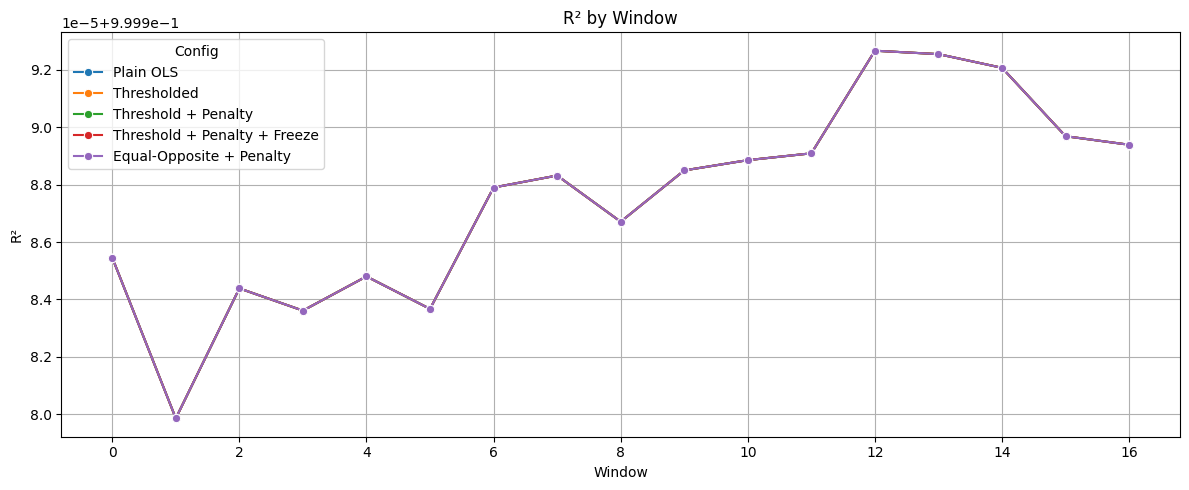

In [1]:
import jax
import jax.numpy as jnp
from jax import vmap
from jax.lax import dynamic_slice
import matplotlib.pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp
from jax import vmap
from jax.lax import dynamic_slice
from functools import partial

def make_sliding_regression_with_penalty_fn(
    X,
    Y,
    window_size,
    stride,
    n_outputs,
    layers,
    penalty_strength=0.0,
    threshold=None,
    freeze_non_masked=False,
    equal_opposite_constraints=None,
):
    n_samples, n_features = X.shape
    n_windows = (n_samples - window_size) // stride + 1

    def get_window(X, i):
        return dynamic_slice(X, (i * stride, 0), (window_size, X.shape[1]))

    def get_window_Y(Y, i):
        return dynamic_slice(Y, (i * stride, 0), (window_size, Y.shape[1]))

    @jax.jit
    def ols_kernel(X_win, Y_win):
        XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
        XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)
        return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(X_win.shape[1]), XtY)

    W_layers = []
    r2_layers = []

    residual = Y

    for layer_config in layers:
        X_wins = vmap(get_window, in_axes=(None, 0))(X, jnp.arange(n_windows))
        Y_wins = vmap(get_window_Y, in_axes=(None, 0))(residual, jnp.arange(n_windows))

        W = vmap(ols_kernel)(X_wins, Y_wins)  # (n_windows, n_features, n_outputs)

        # Apply thresholding logic if provided
        if threshold is not None:
            penalty_mask = jnp.abs(W) < threshold  # (n_windows, n_features, n_outputs)
        else:
            penalty_mask = jnp.zeros_like(W, dtype=bool)

        # Apply equal-opposite constraints
        if equal_opposite_constraints:
            for i, j in equal_opposite_constraints:
                W = W.at[:, j, :].set(-W[:, i, :])

        if penalty_strength > 0.0:
            # Create a feature-wise penalty mask by checking if all output weights
            # for a given feature are below the threshold in each window.
            feature_penalty_mask = jnp.all(penalty_mask, axis=-1)  # (n_windows, n_features)

            # Construct a diagonal penalty term to add to XtX
            penalty_diag_values = feature_penalty_mask.astype(float) * penalty_strength
            penalty_term = jnp.einsum('nf,fg->nfg', penalty_diag_values, jnp.eye(n_features)) # (n_windows, n_features, n_features)

            XtX = jnp.einsum('nwf,nwg->nfg', X_wins, X_wins)  # (n_windows, n_features, n_features)
            XtY = jnp.einsum('nwf,nwo->nfo', X_wins, Y_wins)  # (n_windows, n_features, n_outputs)

            W_pen = jnp.linalg.solve(XtX + penalty_term, XtY) # (n_windows, n_features, n_outputs)

            # Apply freezing based on the original penalty mask
            W_final = jnp.where(penalty_mask, W_pen, W if freeze_non_masked else W_pen)
        else:
            W_final = W

        Y_preds = jnp.einsum('nwf,nfo->nwo', X_wins, W_final)
        ss_res = jnp.sum((Y_wins - Y_preds) ** 2, axis=1)
        ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True)) ** 2, axis=1)
        r2 = 1.0 - (ss_res / (ss_tot + 1e-8))

        residual = residual - jnp.concatenate([Y_preds[i] for i in range(n_windows)], axis=0)[:residual.shape[0]]

        W_layers.append(W_final)
        r2_layers.append(r2)

    return W_layers, r2_layers

# Example usage
if __name__ == '__main__':
    key = jax.random.PRNGKey(0)
    n_samples, n_features, n_outputs = 100, 5, 4
    X = jax.random.normal(key, (n_samples, n_features))
    true_W = jax.random.normal(key, (n_features, n_outputs))
    Y = X @ true_W + 0.01 * jax.random.normal(jax.random.PRNGKey(1), (n_samples, n_outputs))

    print("--- Plain OLS ---")
    weights_ols, r2s_ols = make_sliding_regression_with_penalty_fn(
        X, Y,
        window_size=20,
        stride=5,
        n_outputs=n_outputs,
        layers=[{"layer": 1}]
    )
    print(r2s_ols[0])

    print("--- Penalized with Threshold and Freeze ---")
    weights_pen, r2s_pen = make_sliding_regression_with_penalty_fn(
        X, Y,
        window_size=20,
        stride=5,
        n_outputs=n_outputs,
        layers=[{"layer": 1}],
        threshold=0.1,
        penalty_strength=1e3,
        freeze_non_masked=True
    )
    print(r2s_pen[0])

    print("--- Equal-Opposite Constraint + Multi-Layer ---")
    weights_multi, r2s_multi = make_sliding_regression_with_penalty_fn(
        X, Y,
        window_size=20,
        stride=5,
        n_outputs=n_outputs,
        layers=[{"layer": 1}, {"layer": 2}],
        threshold=0.05,
        penalty_strength=500.0,
        freeze_non_masked=True,
        equal_opposite_constraints=[(0, 1)]
    )
    for i, r2 in enumerate(r2s_multi):
        print(f"Layer {i + 1} R²:", r2)

def make_sliding_regression_with_penalty_fn(
    X,
    Y,
    window_size,
    stride,
    n_outputs,
    layers,
    penalty_strength=0.0,
    threshold=None,
    freeze_non_masked=False,
    equal_opposite_constraints=None,
):
    n_samples, n_features = X.shape
    n_windows = (n_samples - window_size) // stride + 1

    def get_window(X, i):
        return dynamic_slice(X, (i * stride, 0), (window_size, X.shape[1]))

    def get_window_Y(Y, i):
        return dynamic_slice(Y, (i * stride, 0), (window_size, Y.shape[1]))

    @jax.jit
    def ols_kernel(X_win, Y_win):
        XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
        XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
        return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(X_win.shape[1]), XtY)

    W_layers = []
    r2_layers = []
    residual = Y

    for _ in layers:
        X_wins = vmap(get_window, in_axes=(None, 0))(X, jnp.arange(n_windows))
        Y_wins = vmap(get_window_Y, in_axes=(None, 0))(residual, jnp.arange(n_windows))

        W = vmap(ols_kernel)(X_wins, Y_wins)  # (n_windows, n_features, n_outputs)

        penalty_mask = jnp.abs(W) < threshold if threshold is not None else jnp.zeros_like(W, dtype=bool)

        if equal_opposite_constraints:
            for i, j in equal_opposite_constraints:
                W = W.at[:, j, :].set(-W[:, i, :])

        if penalty_strength > 0.0:
            feature_penalty_mask = jnp.all(penalty_mask, axis=-1)  # (n_windows, n_features)
            penalty_diag = jnp.einsum('nf,fg->nfg', feature_penalty_mask.astype(float) * penalty_strength, jnp.eye(n_features))
            XtX = jnp.einsum("nwf,nwg->nfg", X_wins, X_wins)
            XtY = jnp.einsum("nwf,nwo->nfo", X_wins, Y_wins)
            W_pen = jnp.linalg.solve(XtX + penalty_diag, XtY)

            W_final = jnp.where(penalty_mask, W_pen, W if freeze_non_masked else W_pen)
        else:
            W_final = W

        Y_preds = jnp.einsum("nwf,nfo->nwo", X_wins, W_final)
        ss_res = jnp.sum((Y_wins - Y_preds) ** 2, axis=(1, 2))
        ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True)) ** 2, axis=(1, 2))
        r2 = 1.0 - (ss_res / (ss_tot + 1e-8))

        stacked_preds = jnp.concatenate([Y_preds[i] for i in range(n_windows)], axis=0)[:residual.shape[0]]
        residual = residual - stacked_preds

        W_layers.append(W_final)
        r2_layers.append(r2)

    return W_layers, r2_layers

key = jax.random.PRNGKey(0)
n_samples, n_features, n_outputs = 100, 5, 4
X = jax.random.normal(key, (n_samples, n_features))
true_W = jax.random.normal(key, (n_features, n_outputs))
Y = X @ true_W + 0.01 * jax.random.normal(jax.random.PRNGKey(1), (n_samples, n_outputs))

def run_and_log(name, **kwargs):
    print(f"\n=== {name} ===")
    W_layers, R2_layers = make_sliding_regression_with_penalty_fn(X, Y, window_size=20, stride=5, n_outputs=n_outputs, layers=[{"layer": 1}], **kwargs)
    print("R² by window:", R2_layers[0])
    return name, R2_layers

results = []
results.append(run_and_log("Plain OLS"))

results.append(run_and_log("Thresholded", threshold=0.1))

results.append(run_and_log("Threshold + Penalty", threshold=0.1, penalty_strength=1000.0))

results.append(run_and_log("Threshold + Penalty + Freeze", threshold=0.1, penalty_strength=1000.0, freeze_non_masked=True))

results.append(run_and_log("Equal-Opposite + Penalty", threshold=0.1, penalty_strength=500.0, equal_opposite_constraints=[(0, 1)]))

import pandas as pd

def plot_r2_by_window(results):
    all_data = []
    for name, r2s in results:
        for i, r2 in enumerate(r2s[0]):
            all_data.append({"Config": name, "Window": i, "R²": float(r2)})
    df = pd.DataFrame(all_data)

    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df, x="Window", y="R²", hue="Config", marker="o")
    plt.title("R² by Window")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_r2_by_window(results)

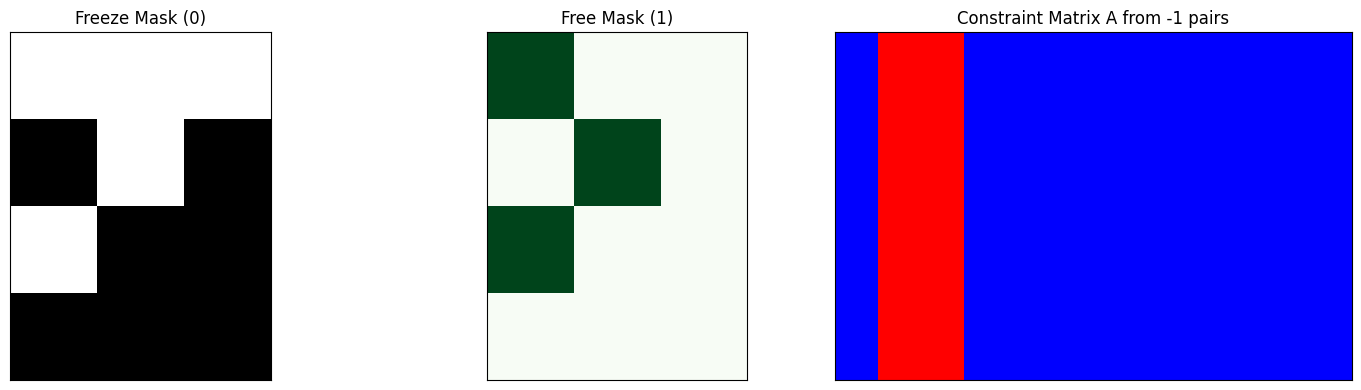

Constraint matrix A (each row is a linear constraint):
    w0   w1   w2   w3   w4   w5   w6   w7   w8   w9  w10  w11
0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd

def parse_control_mask(control_mask):
    """
    Parses a control mask into:
    - freeze_mask: boolean mask where control_mask == 0
    - free_mask: boolean mask where control_mask == 1
    - A: linear constraint matrix for all -1 pairs

    Args:
        control_mask: array of shape (...), entries in {0, 1, -1}

    Returns:
        freeze_mask, free_mask, A (constraint matrix)
    """
    shape = control_mask.shape
    flat_size = int(jnp.prod(jnp.array(shape)))
    idx_array = jnp.arange(flat_size).reshape(shape)

    freeze_mask = (control_mask == 0)
    free_mask = (control_mask == 1)
    constrained_mask = (control_mask == -1)

    constrained_indices = idx_array[constrained_mask].flatten()
    if constrained_indices.shape[0] % 2 != 0:
        raise ValueError("Odd number of constrained indices; must be in pairs.")

    n_pairs = constrained_indices.shape[0] // 2
    A = []

    for i in range(n_pairs):
        i1 = constrained_indices[2 * i]
        i2 = constrained_indices[2 * i + 1]
        row = jnp.zeros(flat_size)
        row = row.at[i1].set(1.0)
        row = row.at[i2].set(1.0)
        A.append(row)

    if A:
        A = jnp.stack(A)
    else:
        A = jnp.zeros((0, flat_size))

    return freeze_mask, free_mask, A

# =======================
# 🧪 Example + Visuals
# =======================

# control_mask: (n_countries=2, n_tenors=2, n_hedges=3)
control_mask = jnp.array([
    [[1, -1, -1], [0, 1, 0]],
    [[1, 0, 0],   [0, 0, 0]]
])

freeze_mask, free_mask, A = parse_control_mask(control_mask)

# Plot masks
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].imshow(freeze_mask.reshape(-1, control_mask.shape[-1]), cmap='Greys', interpolation='nearest')
axes[0].set_title("Freeze Mask (0)")

axes[1].imshow(free_mask.reshape(-1, control_mask.shape[-1]), cmap='Greens', interpolation='nearest')
axes[1].set_title("Free Mask (1)")

axes[2].imshow(A, cmap='bwr', interpolation='nearest', aspect='auto')
axes[2].set_title("Constraint Matrix A from -1 pairs")

for ax in axes:
    ax.set_xticks([]), ax.set_yticks([])

plt.tight_layout()
plt.show()

# Print constraint matrix A
df = pd.DataFrame(A, columns=[f"w{i}" for i in range(A.shape[1])])
print("Constraint matrix A (each row is a linear constraint):")
print(df.round(1))


=== Plain OLS ===
R² by window: [0.99998546 0.99997985 0.9999844  0.9999836  0.9999848  0.99998367
 0.9999879  0.9999883  0.9999867  0.9999885  0.99998885 0.9999891
 0.99999267 0.99999255 0.9999921  0.9999897  0.9999894 ]

=== Thresholded ===
R² by window: [0.99998546 0.99997985 0.9999844  0.9999836  0.9999848  0.99998367
 0.9999879  0.9999883  0.9999867  0.9999885  0.99998885 0.9999891
 0.99999267 0.99999255 0.9999921  0.9999897  0.9999894 ]

=== Threshold + Penalty ===
R² by window: [0.99998546 0.99997985 0.9999844  0.9999836  0.9999848  0.99998367
 0.9999879  0.9999883  0.9999867  0.9999885  0.99998885 0.9999891
 0.99999267 0.99999255 0.9999921  0.9999897  0.9999894 ]

=== Threshold + Penalty + Freeze ===
R² by window: [0.99998546 0.99997985 0.9999844  0.9999836  0.9999848  0.99998367
 0.9999879  0.9999883  0.9999867  0.9999885  0.99998885 0.9999891
 0.99999267 0.99999255 0.9999921  0.9999897  0.9999894 ]

=== Equal-Opposite + Penalty ===
R² by window: [0.99998546 0.99997985 0.9999

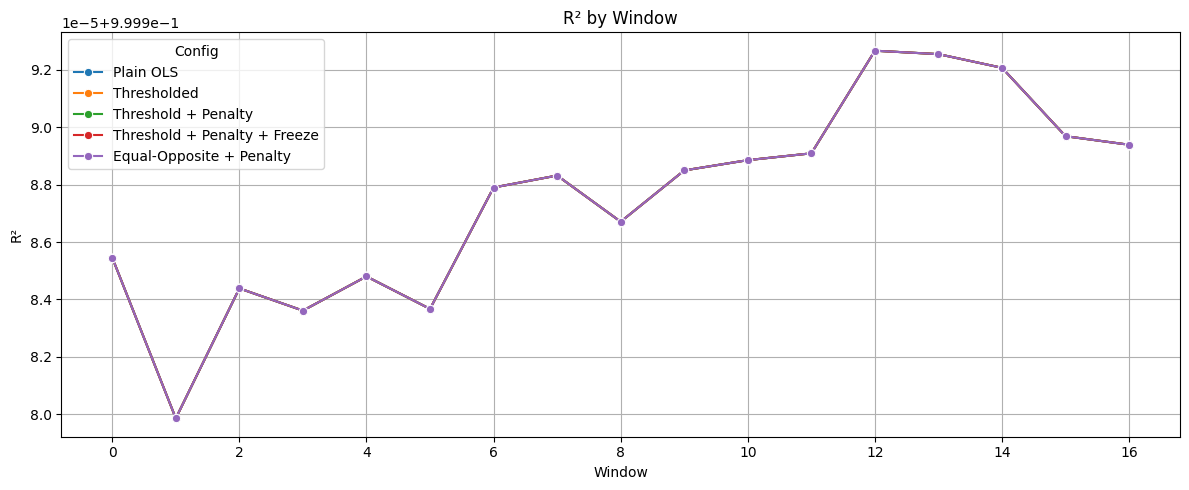

In [18]:
key = jax.random.PRNGKey(0)
n_samples, n_features, n_outputs = 100, 5, 4
X = jax.random.normal(key, (n_samples, n_features))
true_W = jax.random.normal(key, (n_features, n_outputs))
Y = X @ true_W + 0.01 * jax.random.normal(jax.random.PRNGKey(1), (n_samples, n_outputs))

def run_and_log(name, **kwargs):
    print(f"\n=== {name} ===")
    W_layers, R2_layers = make_sliding_regression_with_penalty_fn(X, Y, window_size=20, stride=5, n_outputs=n_outputs, layers=[{"layer": 1}], **kwargs)
    print("R² by window:", R2_layers[0])
    return name, R2_layers

results = []
results.append(run_and_log("Plain OLS"))

results.append(run_and_log("Thresholded", threshold=0.1))

results.append(run_and_log("Threshold + Penalty", threshold=0.1, penalty_strength=1000.0))

results.append(run_and_log("Threshold + Penalty + Freeze", threshold=0.1, penalty_strength=1000.0, freeze_non_masked=True))

results.append(run_and_log("Equal-Opposite + Penalty", threshold=0.1, penalty_strength=500.0, equal_opposite_constraints=[(0, 1)]))


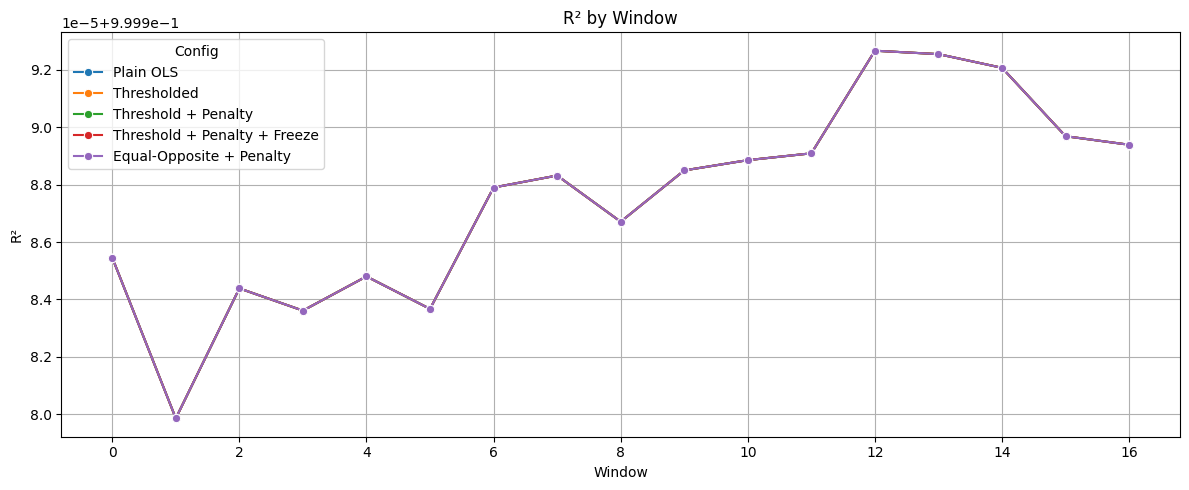

In [14]:
import pandas as pd

def plot_r2_by_window(results):
    all_data = []
    for name, r2s in results:
        for i, r2 in enumerate(r2s[0]):
            all_data.append({"Config": name, "Window": i, "R²": float(r2)})
    df = pd.DataFrame(all_data)

    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df, x="Window", y="R²", hue="Config", marker="o")
    plt.title("R² by Window")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_r2_by_window(results)

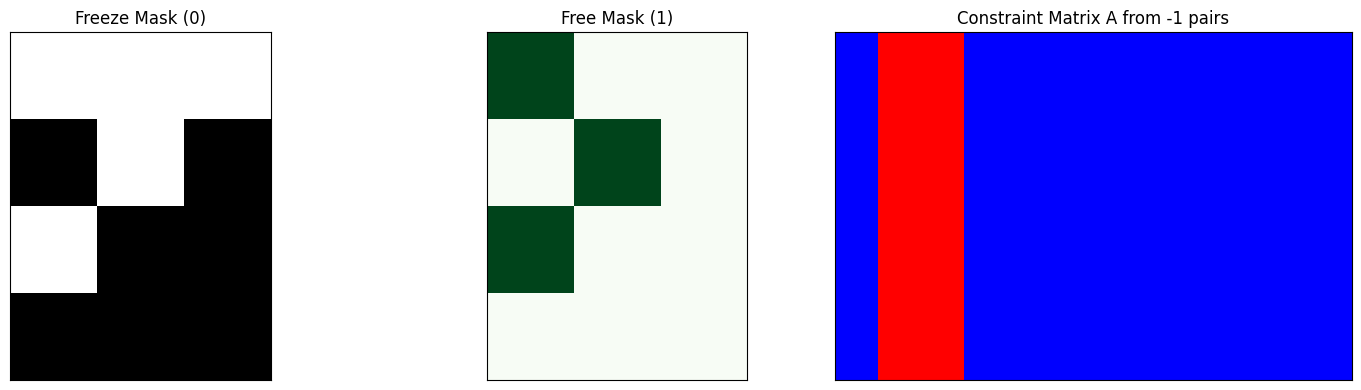

Constraint matrix A (each row is a linear constraint):
    w0   w1   w2   w3   w4   w5   w6   w7   w8   w9  w10  w11
0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd

def parse_control_mask(control_mask):
    """
    Parses a control mask into:
    - freeze_mask: boolean mask where control_mask == 0
    - free_mask: boolean mask where control_mask == 1
    - A: linear constraint matrix for all -1 pairs

    Args:
        control_mask: array of shape (...), entries in {0, 1, -1}

    Returns:
        freeze_mask, free_mask, A (constraint matrix)
    """
    shape = control_mask.shape
    flat_size = int(jnp.prod(jnp.array(shape)))
    idx_array = jnp.arange(flat_size).reshape(shape)

    freeze_mask = (control_mask == 0)
    free_mask = (control_mask == 1)
    constrained_mask = (control_mask == -1)

    constrained_indices = idx_array[constrained_mask].flatten()
    if constrained_indices.shape[0] % 2 != 0:
        raise ValueError("Odd number of constrained indices; must be in pairs.")

    n_pairs = constrained_indices.shape[0] // 2
    A = []

    for i in range(n_pairs):
        i1 = constrained_indices[2 * i]
        i2 = constrained_indices[2 * i + 1]
        row = jnp.zeros(flat_size)
        row = row.at[i1].set(1.0)
        row = row.at[i2].set(1.0)
        A.append(row)

    if A:
        A = jnp.stack(A)
    else:
        A = jnp.zeros((0, flat_size))

    return freeze_mask, free_mask, A

# =======================
# 🧪 Example + Visuals
# =======================

# control_mask: (n_countries=2, n_tenors=2, n_hedges=3)
control_mask = jnp.array([
    [[1, -1, -1], [0, 1, 0]],
    [[1, 0, 0],   [0, 0, 0]]
])

freeze_mask, free_mask, A = parse_control_mask(control_mask)

# Plot masks
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].imshow(freeze_mask.reshape(-1, control_mask.shape[-1]), cmap='Greys', interpolation='nearest')
axes[0].set_title("Freeze Mask (0)")

axes[1].imshow(free_mask.reshape(-1, control_mask.shape[-1]), cmap='Greens', interpolation='nearest')
axes[1].set_title("Free Mask (1)")

axes[2].imshow(A, cmap='bwr', interpolation='nearest', aspect='auto')
axes[2].set_title("Constraint Matrix A from -1 pairs")

for ax in axes:
    ax.set_xticks([]), ax.set_yticks([])

plt.tight_layout()
plt.show()

# Print constraint matrix A
df = pd.DataFrame(A, columns=[f"w{i}" for i in range(A.shape[1])])
print("Constraint matrix A (each row is a linear constraint):")
print(df.round(1))

Layer 1 R²: [[0.9999809  0.99999005 0.9925754  0.99998486]
 [0.9999477  0.9999834  0.99901366 0.99998677]
 [0.99996334 0.9999896  0.99675673 0.99999046]
 [0.99994516 0.99998957 0.9989751  0.99999183]
 [0.9999678  0.9999928  0.99841434 0.9999918 ]
 [0.99998045 0.9999891  0.99486154 0.9999882 ]
 [0.9999888  0.9999835  0.9861439  0.9999929 ]
 [0.9999907  0.99997795 0.98743266 0.9999934 ]
 [0.99995613 0.99997795 0.9974359  0.9999941 ]
 [0.9999497  0.99998665 0.9970439  0.99999285]
 [0.9999433  0.99998707 0.9989976  0.9999924 ]
 [0.9999686  0.9999857  0.99986213 0.9999908 ]
 [0.99999404 0.9999865  0.9996383  0.9999922 ]
 [0.99998885 0.9999908  0.99759996 0.9999939 ]
 [0.9999905  0.99997884 0.99945    0.9999957 ]
 [0.9999875  0.9999517  0.9986696  0.9999951 ]
 [0.99998593 0.9999718  0.99910605 0.9999943 ]]
Layer 2 R²: [[-1.3083696e-02 -2.7976394e-02  9.9740946e-01 -1.1920929e-07]
 [ 6.6098809e-02  2.2942293e-01  3.4916037e-01  4.0053231e-01]
 [ 2.5119120e-01  3.2642102e-01  4.0436220e-01  3.

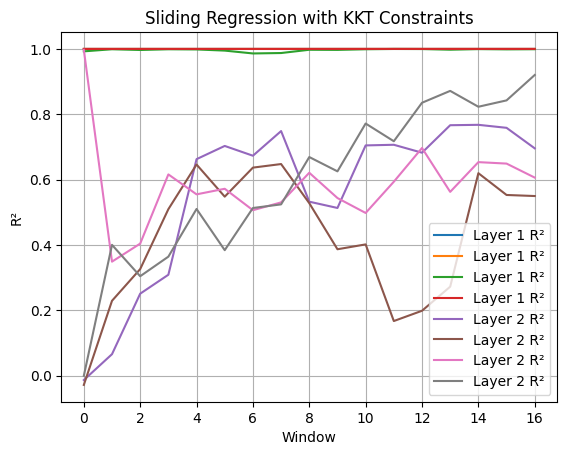

In [7]:
import jax
import jax.numpy as jnp
from jax import vmap
from jax.lax import dynamic_slice
from functools import partial
import matplotlib.pyplot as plt


def kkt_solve(XTX, XTY, A, b):
    """
    Solve constrained least squares using KKT system:
    Minimize ||Xw - y||^2 subject to Aw = b
    """
    n_features, n_outputs = XTY.shape
    n_constraints = A.shape[0]
    zeros = jnp.zeros((n_constraints, n_constraints))

    top = jnp.concatenate([XTX, A.T], axis=1)
    bottom = jnp.concatenate([A, zeros], axis=1)
    KKT = jnp.concatenate([top, bottom], axis=0)

    rhs = jnp.concatenate([XTY, b], axis=0)
    sol = jnp.linalg.solve(KKT, rhs)
    return sol[:n_features]


def make_sliding_regression_with_penalty_fn(
    X,
    Y,
    window_size,
    stride,
    n_outputs,
    layers,
    penalty_strength=0.0,
    threshold=None,
    freeze_non_masked=False,
    equal_opposite_constraints=None,
    control_masks=None,  # list of (n_features, n_outputs) with 0 (freeze), 1 (opt), -1 (constrained)
    A_matrices=None,     # list of constraint matrices A per layer
    b_vectors=None,      # list of constraint targets b per layer
):
    n_samples, n_features = X.shape
    n_windows = (n_samples - window_size) // stride + 1

    def get_window(X, i):
        return dynamic_slice(X, (i * stride, 0), (window_size, X.shape[1]))

    def get_window_Y(Y, i):
        return dynamic_slice(Y, (i * stride, 0), (window_size, Y.shape[1]))

    @jax.jit
    def ols_kernel(X_win, Y_win):
        XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
        XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
        return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(X_win.shape[1]), XtY)

    W_layers = []
    r2_layers = []
    residual = Y

    for l_idx, layer_config in enumerate(layers):
        X_wins = vmap(get_window, in_axes=(None, 0))(X, jnp.arange(n_windows))
        Y_wins = vmap(get_window_Y, in_axes=(None, 0))(residual, jnp.arange(n_windows))

        W = vmap(ols_kernel)(X_wins, Y_wins)

        if threshold is not None:
            penalty_mask = jnp.abs(W) < threshold
        else:
            penalty_mask = jnp.zeros_like(W, dtype=bool)

        if equal_opposite_constraints:
            for i, j in equal_opposite_constraints:
                W = W.at[:, j, :].set(-W[:, i, :])

        if penalty_strength > 0.0:
            feature_penalty_mask = jnp.all(penalty_mask, axis=-1)
            penalty_diag = feature_penalty_mask.astype(float) * penalty_strength
            penalty_term = jnp.einsum("nf,fg->nfg", penalty_diag, jnp.eye(n_features))

            XtX = jnp.einsum("nwf,nwg->nfg", X_wins, X_wins)
            XtY = jnp.einsum("nwf,nwo->nfo", X_wins, Y_wins)

            if control_masks and A_matrices and b_vectors and control_masks[l_idx] is not None:
                mask = control_masks[l_idx]
                A = A_matrices[l_idx]
                b = b_vectors[l_idx]
                W_pen = vmap(lambda xtx, xty: kkt_solve(xtx + penalty_term[0], xty, A, b))(XtX, XtY)
            else:
                W_pen = jnp.linalg.solve(XtX + penalty_term, XtY)

            W_final = jnp.where(penalty_mask, W_pen, W if freeze_non_masked else W_pen)
        else:
            W_final = W

        if threshold is not None:
            W_final = jnp.where(jnp.abs(W_final) < threshold, 0.0, W_final)

        Y_preds = jnp.einsum("nwf,nfo->nwo", X_wins, W_final)
        ss_res = jnp.sum((Y_wins - Y_preds) ** 2, axis=1)
        ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True)) ** 2, axis=1)
        r2 = 1.0 - (ss_res / (ss_tot + 1e-8))

        residual = residual - jnp.concatenate([Y_preds[i] for i in range(n_windows)], axis=0)[:residual.shape[0]]

        W_layers.append(W_final)
        r2_layers.append(r2)

    return W_layers, r2_layers


if __name__ == "__main__":
    key = jax.random.PRNGKey(0)
    n_samples, n_features, n_outputs = 100, 5, 4
    X = jax.random.normal(key, (n_samples, n_features))
    true_W = jax.random.normal(key, (n_features, n_outputs))
    Y = X @ true_W + 0.01 * jax.random.normal(jax.random.PRNGKey(1), (n_samples, n_outputs))

    control_mask = jnp.ones((n_features, n_outputs))
    control_mask = control_mask.at[0, 0].set(-1)  # constrained var
    control_mask = control_mask.at[1, 0].set(1)   # free var
    A = jnp.zeros((1, n_features))
    A = A.at[0, 0].set(1.0).at[0, 1].set(1.0)  # w0 + w1 = 0
    b = jnp.zeros((1, n_outputs))

    weights_constrained, r2s_constrained = make_sliding_regression_with_penalty_fn(
        X, Y,
        window_size=20,
        stride=5,
        n_outputs=n_outputs,
        layers=[{"layer": 1}, {"layer": 2}],
        threshold=0.05,
        penalty_strength=1e3,
        freeze_non_masked=True,
        control_masks=[control_mask, None],
        A_matrices=[A, None],
        b_vectors=[b, None],
    )

    for i, r2 in enumerate(r2s_constrained):
        print(f"Layer {i + 1} R²:", r2)
        plt.plot(r2, label=f"Layer {i + 1} R²")
    plt.xlabel("Window")
    plt.ylabel("R²")
    plt.legend()
    plt.title("Sliding Regression with KKT Constraints")
    plt.grid(True)
    plt.show()


In [36]:
import jax
import jax.numpy as jnp
from jax import vmap
import matplotlib.pyplot as plt

def kkt_solve(XTX, XTY, A=None, b=None):
    if A is None or b is None:
        return jnp.linalg.solve(XTX + 1e-6 * jnp.eye(XTX.shape[0]), XTY)
    n_constraints = A.shape[0]
    zeros = jnp.zeros((n_constraints, n_constraints))
    KKT = jnp.block([[XTX, A.T], [A, zeros]])
    RHS = jnp.concatenate([XTY, b], axis=0)
    sol = jnp.linalg.solve(KKT + 1e-6 * jnp.eye(KKT.shape[0]), RHS)
    return sol[:XTX.shape[0]]

def sliding_regression_with_constraints(X, Y, window_size, stride, layers, constraint_fn=None):
    n_samples, n_features = X.shape
    n_outputs = Y.shape[1]
    n_windows = (n_samples - window_size) // stride + 1

    def extract_windows(M):
        idx = jnp.arange(n_windows)
        return vmap(lambda i: M[i*stride:i*stride+window_size])(idx)

    W_layers, R2_layers = [], []
    residual = Y

    for layer_idx in range(len(layers)):
        X_win = extract_windows(X)
        Y_win = extract_windows(residual)

        XtX = jnp.einsum('nwi,nwj->nij', X_win, X_win)
        XtY = jnp.einsum('nwi,nwo->nio', X_win, Y_win)

        def solve(XtX_i, XtY_i):
            A, b = constraint_fn(layer_idx) if constraint_fn else (None, None)
            return kkt_solve(XtX_i, XtY_i, A, b)

        W = vmap(solve)(XtX, XtY)
        Y_pred = jnp.einsum('nwi,nio->nwo', X_win, W)
        residual = residual - jnp.concatenate([Y_pred[i] for i in range(n_windows)], axis=0)[:residual.shape[0]]

        ss_res = jnp.sum((Y_win - Y_pred)**2, axis=(1, 2))
        ss_tot = jnp.sum((Y_win - jnp.mean(Y_win, axis=1, keepdims=True))**2, axis=(1, 2))
        R2 = 1.0 - (ss_res / (ss_tot + 1e-8))

        W_layers.append(W)
        R2_layers.append(R2)

    return W_layers, R2_layers

In [10]:
import jax
import jax.numpy as jnp
from jax import vmap
from jax.lax import dynamic_slice
from functools import partial

def kkt_solve(X, Y, A, epsilon, big_penalty):
    """Closed-form KKT solver: solves (XᵀX + εI)W + Aᵀλ = XᵀY with AW = 0"""
    n, d, o = X.shape[0], X.shape[1], Y.shape[1]
    XtX = X.T @ X + epsilon * jnp.eye(d)
    XtY = X.T @ Y
    if A is None:
        return jnp.linalg.solve(XtX, XtY)
    else:
        At = A.T
        K = jnp.block([[XtX + big_penalty * A.T @ A, At], [A, jnp.zeros((A.shape[0], A.shape[0]))]])
        rhs = jnp.concatenate([XtY, jnp.zeros((A.shape[0], o))], axis=0)
        sol = jnp.linalg.solve(K, rhs)
        return sol[:d]

def solve_window(Xw, Yw, mask, A, epsilon, big_penalty):
    d, o = Xw.shape[1], Yw.shape[1]
    A_used = A if A is not None else None
    return kkt_solve(Xw, Yw, A_used, epsilon, big_penalty)

def sliding_regression_with_constraints(
    X,
    Y,
    window_size,
    stride,
    n_outputs,
    layers,
    epsilon=1e-6,
    big_penalty=1e6,
):
    n_samples, n_features = X.shape
    n_windows = (n_samples - window_size) // stride + 1

    def get_window(X, i):
        return dynamic_slice(X, (i * stride, 0), (window_size, X.shape[1]))

    def get_window_Y(Y, i):
        return dynamic_slice(Y, (i * stride, 0), (window_size, Y.shape[1]))

    W_layers = []
    R2_layers = []
    residual = Y

    for layer in layers:
        mask = layer.get("mask", jnp.ones((n_features, n_outputs)))
        A = layer.get("A", None)

        idxs = jnp.arange(n_windows)
        X_wins = vmap(get_window, in_axes=(None, 0))(X, idxs)
        Y_wins = vmap(get_window_Y, in_axes=(None, 0))(residual, idxs)

        W = vmap(solve_window, in_axes=(0, 0, None, None, None, None))(
            X_wins, Y_wins, mask, A, epsilon, big_penalty
        )

        Y_preds = jnp.einsum("nwf,nfo->nwo", X_wins, W)
        ss_res = jnp.sum((Y_wins - Y_preds) ** 2, axis=1)
        ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True)) ** 2, axis=1)
        r2 = 1.0 - ss_res / (ss_tot + 1e-8)

        # update residual for next layer
        full_pred = jnp.concatenate([Y_preds[i] for i in range(n_windows)], axis=0)[:residual.shape[0]]
        residual = residual - full_pred

        W_layers.append(W)
        R2_layers.append(r2)

    return W_layers, R2_layers

Layer 1 R²: [[0.9999809  0.99999005 0.9925754  0.99998486]
 [0.9999477  0.9999834  0.99901366 0.99998677]
 [0.99996334 0.9999896  0.99675673 0.99999046]
 [0.99994516 0.99998957 0.9989751  0.99999183]
 [0.9999678  0.9999928  0.99841434 0.9999918 ]
 [0.99998045 0.9999891  0.99486154 0.9999882 ]
 [0.9999888  0.9999835  0.9861439  0.9999929 ]
 [0.9999907  0.99997795 0.98743266 0.9999934 ]
 [0.99995613 0.99997795 0.9974359  0.9999941 ]
 [0.9999497  0.99998665 0.9970439  0.99999285]
 [0.9999433  0.99998707 0.9989976  0.9999924 ]
 [0.9999686  0.9999857  0.99986213 0.9999908 ]
 [0.99999404 0.9999865  0.9996383  0.9999922 ]
 [0.99998885 0.9999908  0.99759996 0.9999939 ]
 [0.9999905  0.99997884 0.99945    0.9999957 ]
 [0.9999875  0.9999517  0.9986696  0.9999951 ]
 [0.99998593 0.9999718  0.99910605 0.9999943 ]]
Layer 2 R²: [[-1.3083696e-02 -2.7976394e-02  9.9740946e-01 -1.1920929e-07]
 [ 6.6098809e-02  2.2942293e-01  3.4916037e-01  4.0053231e-01]
 [ 2.5119120e-01  3.2642102e-01  4.0436220e-01  3.

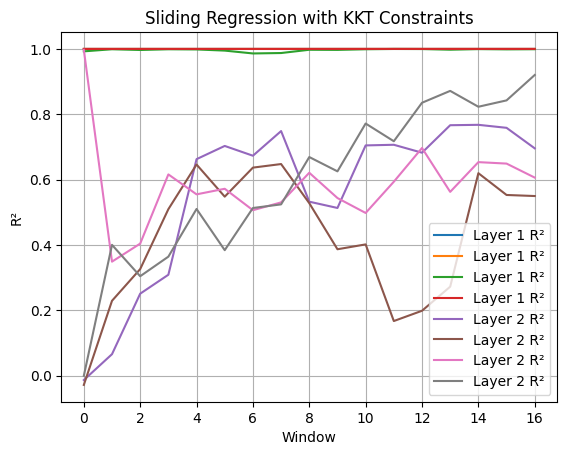

In [38]:
import jax
import jax.numpy as jnp
from jax import vmap
from jax.lax import dynamic_slice
from functools import partial
import matplotlib.pyplot as plt


def kkt_solve(XTX, XTY, A, b):
    """
    Solve constrained least squares using KKT system:
    Minimize ||Xw - y||^2 subject to Aw = b
    """
    n_features, n_outputs = XTY.shape
    n_constraints = A.shape[0]
    zeros = jnp.zeros((n_constraints, n_constraints))

    top = jnp.concatenate([XTX, A.T], axis=1)
    bottom = jnp.concatenate([A, zeros], axis=1)
    KKT = jnp.concatenate([top, bottom], axis=0)

    rhs = jnp.concatenate([XTY, b], axis=0)
    sol = jnp.linalg.solve(KKT, rhs)
    return sol[:n_features]


def make_sliding_regression_with_penalty_fn(
    X,
    Y,
    window_size,
    stride,
    n_outputs,
    layers,
    penalty_strength=0.0,
    threshold=None,
    freeze_non_masked=False,
    equal_opposite_constraints=None,
    control_masks=None,  # list of (n_features, n_outputs) with 0 (freeze), 1 (opt), -1 (constrained)
    A_matrices=None,     # list of constraint matrices A per layer
    b_vectors=None,      # list of constraint targets b per layer
):
    n_samples, n_features = X.shape
    n_windows = (n_samples - window_size) // stride + 1

    def get_window(X, i):
        return dynamic_slice(X, (i * stride, 0), (window_size, X.shape[1]))

    def get_window_Y(Y, i):
        return dynamic_slice(Y, (i * stride, 0), (window_size, Y.shape[1]))

    @jax.jit
    def ols_kernel(X_win, Y_win):
        XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
        XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
        return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(X_win.shape[1]), XtY)

    W_layers = []
    r2_layers = []
    residual = Y

    for l_idx, layer_config in enumerate(layers):
        X_wins = vmap(get_window, in_axes=(None, 0))(X, jnp.arange(n_windows))
        Y_wins = vmap(get_window_Y, in_axes=(None, 0))(residual, jnp.arange(n_windows))

        W = vmap(ols_kernel)(X_wins, Y_wins)

        if threshold is not None:
            penalty_mask = jnp.abs(W) < threshold
        else:
            penalty_mask = jnp.zeros_like(W, dtype=bool)

        if equal_opposite_constraints:
            for i, j in equal_opposite_constraints:
                W = W.at[:, j, :].set(-W[:, i, :])

        if penalty_strength > 0.0:
            feature_penalty_mask = jnp.all(penalty_mask, axis=-1)
            penalty_diag = feature_penalty_mask.astype(float) * penalty_strength
            penalty_term = jnp.einsum("nf,fg->nfg", penalty_diag, jnp.eye(n_features))

            XtX = jnp.einsum("nwf,nwg->nfg", X_wins, X_wins)
            XtY = jnp.einsum("nwf,nwo->nfo", X_wins, Y_wins)

            if control_masks and A_matrices and b_vectors and control_masks[l_idx] is not None:
                mask = control_masks[l_idx]
                A = A_matrices[l_idx]
                b = b_vectors[l_idx]
                W_pen = vmap(lambda xtx, xty: kkt_solve(xtx + penalty_term[0], xty, A, b))(XtX, XtY)
            else:
                W_pen = jnp.linalg.solve(XtX + penalty_term, XtY)

            W_final = jnp.where(penalty_mask, W_pen, W if freeze_non_masked else W_pen)
        else:
            W_final = W

        if threshold is not None:
            W_final = jnp.where(jnp.abs(W_final) < threshold, 0.0, W_final)

        Y_preds = jnp.einsum("nwf,nfo->nwo", X_wins, W_final)
        ss_res = jnp.sum((Y_wins - Y_preds) ** 2, axis=1)
        ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True)) ** 2, axis=1)
        r2 = 1.0 - (ss_res / (ss_tot + 1e-8))

        residual = residual - jnp.concatenate([Y_preds[i] for i in range(n_windows)], axis=0)[:residual.shape[0]]

        W_layers.append(W_final)
        r2_layers.append(r2)

    return W_layers, r2_layers


if __name__ == "__main__":
    key = jax.random.PRNGKey(0)
    n_samples, n_features, n_outputs = 100, 5, 4
    X = jax.random.normal(key, (n_samples, n_features))
    true_W = jax.random.normal(key, (n_features, n_outputs))
    Y = X @ true_W + 0.01 * jax.random.normal(jax.random.PRNGKey(1), (n_samples, n_outputs))

    control_mask = jnp.ones((n_features, n_outputs))
    control_mask = control_mask.at[0, 0].set(-1)  # constrained var
    control_mask = control_mask.at[1, 0].set(1)   # free var
    A = jnp.zeros((1, n_features))
    A = A.at[0, 0].set(1.0).at[0, 1].set(1.0)  # w0 + w1 = 0
    b = jnp.zeros((1, n_outputs))

    weights_constrained, r2s_constrained = make_sliding_regression_with_penalty_fn(
        X, Y,
        window_size=20,
        stride=5,
        n_outputs=n_outputs,
        layers=[{"layer": 1}, {"layer": 2}],
        threshold=0.05,
        penalty_strength=1e3,
        freeze_non_masked=True,
        control_masks=[control_mask, None],
        A_matrices=[A, None],
        b_vectors=[b, None],
    )

    for i, r2 in enumerate(r2s_constrained):
        print(f"Layer {i + 1} R²:", r2)
        plt.plot(r2, label=f"Layer {i + 1} R²")
    plt.xlabel("Window")
    plt.ylabel("R²")
    plt.legend()
    plt.title("Sliding Regression with KKT Constraints")
    plt.grid(True)
    plt.show()


Layer 1 R²: [[0.9999809  0.99999005 0.9999284  0.99998486]
 [0.9999477  0.9999834  0.99990493 0.99998677]
 [0.99996334 0.9999896  0.9998594  0.99999046]
 [0.99994516 0.99998957 0.9998711  0.99999183]
 [0.9999678  0.9999928  0.99983317 0.9999918 ]
 [0.99998045 0.9999891  0.99984676 0.9999882 ]
 [0.9999888  0.9999835  0.9999211  0.9999929 ]
 [0.9999907  0.99997795 0.9999098  0.9999934 ]
 [0.99995613 0.99997795 0.9998969  0.9999941 ]
 [0.9999497  0.99998665 0.9998904  0.99999285]
 [0.9999433  0.99998707 0.999886   0.9999924 ]
 [0.9999686  0.9999857  0.99986327 0.9999908 ]
 [0.99999404 0.9999865  0.9998735  0.9999922 ]
 [0.99998885 0.9999908  0.9998818  0.9999939 ]
 [0.9999905  0.99997884 0.9998739  0.9999957 ]
 [0.9999875  0.9999517  0.9998971  0.9999951 ]
 [0.99998593 0.9999718  0.9999575  0.9999943 ]]
Layer 2 R²: [[0.46998698 0.55212694 0.8228103  0.787085  ]
 [0.8901181  0.9242698  0.91254693 0.9487787 ]
 [0.9730171  0.98600173 0.98117983 0.9777641 ]
 [0.99999267 0.99999946 0.99998593 

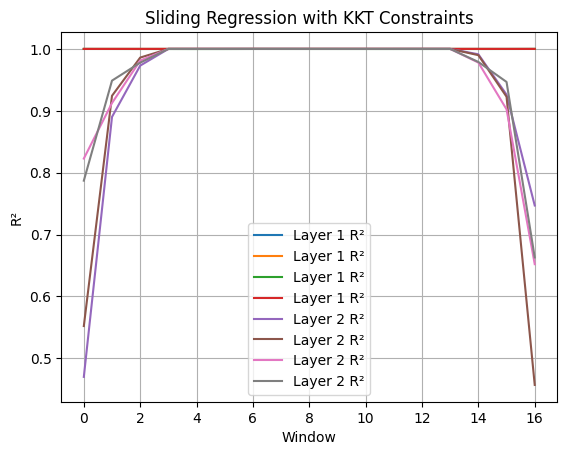

In [39]:
import jax
import jax.numpy as jnp
from jax import vmap
from jax.lax import dynamic_slice
from functools import partial
import matplotlib.pyplot as plt

def kkt_solve(XTX, XTY, A, b):
    """
    Solve constrained least squares using KKT system:
    Minimize ||Xw - y||^2 subject to Aw = b
    """
    n_features, n_outputs = XTY.shape
    n_constraints = A.shape[0]
    zeros = jnp.zeros((n_constraints, n_constraints))

    top = jnp.concatenate([XTX, A.T], axis=1)
    bottom = jnp.concatenate([A, zeros], axis=1)
    KKT = jnp.concatenate([top, bottom], axis=0)

    rhs = jnp.concatenate([XTY, b], axis=0)
    sol = jnp.linalg.solve(KKT, rhs)
    return sol[:n_features]

def masked_kkt_layer(X_wins, Y_wins, penalty_mask, penalty_strength, A, b, control_mask):
    n_windows, n_features, n_outputs = penalty_mask.shape

    def solve_per_window(i):
        X_win = X_wins[i]
        Y_win = Y_wins[i]
        XtX = X_win.T @ X_win
        XtY = X_win.T @ Y_win

        mask_flat = control_mask.reshape(-1)
        active_idx = jnp.where(mask_flat == 1)[0]
        constrained_idx = jnp.where(mask_flat == -1)[0]

        if len(active_idx) == 0:
            return jnp.zeros((n_features, n_outputs))

        P = jnp.eye(n_features) * penalty_strength * jnp.any(penalty_mask[i], axis=-1).astype(jnp.float32)[:, None]
        W = kkt_solve(XtX + P, XtY, A, b)

        # Enforce freezing by zeroing out those not optimized
        frozen_idx = jnp.where(mask_flat == 0)[0]
        W = W.at[frozen_idx].set(0.0)

        return W

    return vmap(solve_per_window)(jnp.arange(n_windows))

def make_sliding_regression_with_penalty_fn(
    X,
    Y,
    window_size,
    stride,
    n_outputs,
    layers,
    penalty_strength=0.0,
    threshold=None,
    freeze_non_masked=False,
    equal_opposite_constraints=None,
    control_masks=None,
    A_matrices=None,
    b_vectors=None,
):
    n_samples, n_features = X.shape
    n_windows = (n_samples - window_size) // stride + 1

    def get_window(X, i):
        return dynamic_slice(X, (i * stride, 0), (window_size, X.shape[1]))

    def get_window_Y(Y, i):
        return dynamic_slice(Y, (i * stride, 0), (window_size, Y.shape[1]))

    @jax.jit
    def ols_kernel(X_win, Y_win):
        XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
        XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
        return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(X_win.shape[1]), XtY)

    W_layers = []
    r2_layers = []
    residual = Y

    for l_idx, layer_config in enumerate(layers):
        X_wins = vmap(get_window, in_axes=(None, 0))(X, jnp.arange(n_windows))
        Y_wins = vmap(get_window_Y, in_axes=(None, 0))(residual, jnp.arange(n_windows))

        W = vmap(ols_kernel)(X_wins, Y_wins)

        if threshold is not None:
            penalty_mask = jnp.abs(W) < threshold
        else:
            penalty_mask = jnp.zeros_like(W, dtype=bool)

        if equal_opposite_constraints:
            for i, j in equal_opposite_constraints:
                W = W.at[:, j, :].set(-W[:, i, :])

        if penalty_strength > 0.0:
            if control_masks and A_matrices and b_vectors and control_masks[l_idx] is not None:
                mask = control_masks[l_idx]
                A = A_matrices[l_idx]
                b = b_vectors[l_idx]
                W_pen = masked_kkt_layer(X_wins, Y_wins, penalty_mask, penalty_strength, A, b, mask)
            else:
                XtX = jnp.einsum("nwf,nwg->nfg", X_wins, X_wins)
                XtY = jnp.einsum("nwf,nwo->nfo", X_wins, Y_wins)
                feature_penalty_mask = jnp.all(penalty_mask, axis=-1)
                penalty_diag = feature_penalty_mask.astype(float) * penalty_strength
                penalty_term = jnp.einsum("nf,fg->nfg", penalty_diag, jnp.eye(n_features))
                W_pen = jnp.linalg.solve(XtX + penalty_term, XtY)

            W_final = jnp.where(penalty_mask, W_pen, W if freeze_non_masked else W_pen)
        else:
            W_final = W

        if threshold is not None:
            W_final = jnp.where(jnp.abs(W_final) < threshold, 0.0, W_final)

        Y_preds = jnp.einsum("nwf,nfo->nwo", X_wins, W_final)
        ss_res = jnp.sum((Y_wins - Y_preds) ** 2, axis=1)
        ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True)) ** 2, axis=1)
        r2 = 1.0 - (ss_res / (ss_tot + 1e-8))

        flat_preds = jnp.zeros_like(residual)
        for i in range(n_windows):
            idx = i * stride
            flat_preds = flat_preds.at[idx:idx+window_size].add(Y_preds[i])

        residual = residual - flat_preds

        W_layers.append(W_final)
        r2_layers.append(r2)

    return W_layers, r2_layers

if __name__ == "__main__":
    key = jax.random.PRNGKey(0)
    n_samples, n_features, n_outputs = 100, 5, 4
    X = jax.random.normal(key, (n_samples, n_features))
    true_W = jax.random.normal(key, (n_features, n_outputs))
    Y = X @ true_W + 0.01 * jax.random.normal(jax.random.PRNGKey(1), (n_samples, n_outputs))

    control_mask = jnp.ones((n_features, n_outputs))
    control_mask = control_mask.at[0, 0].set(-1)
    control_mask = control_mask.at[1, 0].set(1)
    A = jnp.zeros((1, n_features))
    A = A.at[0, 0].set(1.0).at[0, 1].set(1.0)
    b = jnp.zeros((1, n_outputs))

    weights_constrained, r2s_constrained = make_sliding_regression_with_penalty_fn(
        X, Y,
        window_size=20,
        stride=5,
        n_outputs=n_outputs,
        layers=[{"layer": 1}, {"layer": 2}],
        threshold=0.05,
        penalty_strength=1e3,
        freeze_non_masked=True,
        control_masks=[control_mask, None],
        A_matrices=[A, None],
        b_vectors=[b, None],
    )

    for i, r2 in enumerate(r2s_constrained):
        print(f"Layer {i + 1} R²:", r2)
        plt.plot(r2, label=f"Layer {i + 1} R²")
    plt.xlabel("Window")
    plt.ylabel("R²")
    plt.legend()
    plt.title("Sliding Regression with KKT Constraints")
    plt.grid(True)
    plt.show()


(1, 5)
Layer 1 R²: [[0.9999809  0.99999005 0.9925753  0.99998486]
 [0.9999477  0.9999834  0.99901366 0.99998677]
 [0.99996334 0.9999896  0.9967567  0.99999046]
 [0.99994516 0.99998957 0.9989751  0.99999183]
 [0.9999678  0.9999928  0.99841434 0.9999918 ]
 [0.99998045 0.9999891  0.9948615  0.9999882 ]
 [0.9999888  0.9999835  0.9861437  0.9999929 ]
 [0.9999907  0.99997795 0.98743254 0.9999934 ]
 [0.99995613 0.99997795 0.9974359  0.9999941 ]
 [0.9999497  0.99998665 0.9970439  0.99999285]
 [0.9999433  0.99998707 0.9989976  0.9999924 ]
 [0.9999686  0.9999857  0.99986213 0.9999908 ]
 [0.99999404 0.9999865  0.9996383  0.9999922 ]
 [0.99998885 0.9999908  0.9975999  0.9999939 ]
 [0.9999905  0.99997884 0.99945    0.9999957 ]
 [0.9999875  0.9999517  0.99866956 0.9999951 ]
 [0.99998593 0.9999718  0.99910605 0.9999943 ]]
Layer 2 R²: [[-1.3083696e-02 -2.7976394e-02  9.9740952e-01 -1.1920929e-07]
 [ 6.6098809e-02  2.2942293e-01  3.4916079e-01  4.0053231e-01]
 [ 2.5119120e-01  3.2642102e-01  4.0436190e

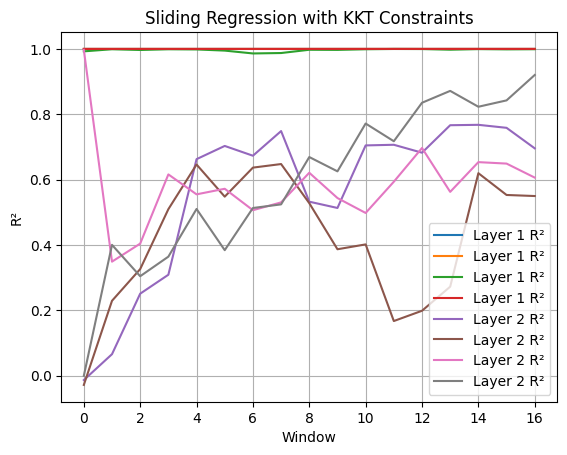

TypeError: add got incompatible shapes for broadcasting: (20, 5), (20, 20).

In [35]:
import jax
import jax.numpy as jnp
from jax import vmap
from jax.lax import dynamic_slice
from functools import partial
import matplotlib.pyplot as plt


# def kkt_solve(XTX, XTY, A, b):
#     """
#     Solve constrained least squares using KKT system:
#     Minimize ||Xw - y||^2 subject to Aw = b
#     """
#     n_features, n_outputs = XTY.shape
#     n_constraints = A.shape[0]
#     zeros = jnp.zeros((n_constraints, n_constraints))

#     top = jnp.concatenate([XTX, A.T], axis=1)
#     bottom = jnp.concatenate([A, zeros], axis=1)
#     KKT = jnp.concatenate([top, bottom], axis=0)

#     rhs = jnp.concatenate([XTY, b], axis=0)
#     sol = jnp.linalg.solve(KKT, rhs)
#     return sol[:n_features]

# def kkt_solve(X, Y, A, epsilon, big_penalty):
#     """Closed-form KKT solver: solves (XᵀX + εI)W + Aᵀλ = XᵀY with AW = 0"""
#     n, d, o = X.shape[0], X.shape[1], Y.shape[1]
#     XtX = X.T @ X + epsilon * jnp.eye(d)
#     XtY = X.T @ Y
#     if A is None:
#         return jnp.linalg.solve(XtX, XtY)
#     else:
#         At = A.T
#         K = jnp.block([[XtX + big_penalty * A.T @ A, At], [A, jnp.zeros((A.shape[0], A.shape[0]))]])
#         rhs = jnp.concatenate([XtY, jnp.zeros((A.shape[0], o))], axis=0)
#         sol = jnp.linalg.solve(K, rhs)
#         return sol[:d]

def make_sliding_regression_with_penalty_fn(
    X,
    Y,
    window_size,
    stride,
    n_outputs,
    layers,
    penalty_strength=0.0,
    threshold=None,
    freeze_non_masked=False,
    equal_opposite_constraints=None,
    control_masks=None,  # list of (n_features, n_outputs) with 0 (freeze), 1 (opt), -1 (constrained)
    A_matrices=None,     # list of constraint matrices A per layer
    b_vectors=None,      # list of constraint targets b per layer
):
    n_samples, n_features = X.shape
    n_windows = (n_samples - window_size) // stride + 1

    def get_window(X, i):
        return dynamic_slice(X, (i * stride, 0), (window_size, X.shape[1]))

    def get_window_Y(Y, i):
        return dynamic_slice(Y, (i * stride, 0), (window_size, Y.shape[1]))

    @jax.jit
    def ols_kernel(X_win, Y_win):
        XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
        XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
        return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(X_win.shape[1]), XtY)

    W_layers = []
    r2_layers = []
    residual = Y

    for l_idx, layer_config in enumerate(layers):
        X_wins = vmap(get_window, in_axes=(None, 0))(X, jnp.arange(n_windows))
        Y_wins = vmap(get_window_Y, in_axes=(None, 0))(residual, jnp.arange(n_windows))

        W = vmap(ols_kernel)(X_wins, Y_wins)

        if threshold is not None:
            penalty_mask = jnp.abs(W) < threshold
        else:
            penalty_mask = jnp.zeros_like(W, dtype=bool)

        if equal_opposite_constraints:
            for i, j in equal_opposite_constraints:
                W = W.at[:, j, :].set(-W[:, i, :])

        if penalty_strength > 0.0:
            feature_penalty_mask = jnp.all(penalty_mask, axis=-1)
            penalty_diag = feature_penalty_mask.astype(float) * penalty_strength
            penalty_term = jnp.einsum("nf,fg->nfg", penalty_diag, jnp.eye(n_features))

            XtX = jnp.einsum("nwf,nwg->nfg", X_wins, X_wins)
            XtY = jnp.einsum("nwf,nwo->nfo", X_wins, Y_wins)

            if control_masks and A_matrices and b_vectors and control_masks[l_idx] is not None:
                mask = control_masks[l_idx]
                A = A_matrices[l_idx]
                b = b_vectors[l_idx]
                W_pen = vmap(lambda xtx, xty: kkt_solve(xtx + penalty_term[0], xty, A, b))(XtX, XtY)
            else:
                W_pen = jnp.linalg.solve(XtX + penalty_term, XtY)

            W_final = jnp.where(penalty_mask, W_pen, W if freeze_non_masked else W_pen)
        else:
            W_final = W

        if threshold is not None:
            W_final = jnp.where(jnp.abs(W_final) < threshold, 0.0, W_final)

        Y_preds = jnp.einsum("nwf,nfo->nwo", X_wins, W_final)
        ss_res = jnp.sum((Y_wins - Y_preds) ** 2, axis=1)
        ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True)) ** 2, axis=1)
        r2 = 1.0 - (ss_res / (ss_tot + 1e-8))

        residual = residual - jnp.concatenate([Y_preds[i] for i in range(n_windows)], axis=0)[:residual.shape[0]]

        W_layers.append(W_final)
        r2_layers.append(r2)

    return W_layers, r2_layers


if __name__ == "__main__":
    key = jax.random.PRNGKey(0)
    n_samples, n_features, n_outputs = 100, 5, 4
    X = jax.random.normal(key, (n_samples, n_features))
    true_W = jax.random.normal(key, (n_features, n_outputs))
    Y = X @ true_W + 0.01 * jax.random.normal(jax.random.PRNGKey(1), (n_samples, n_outputs))

    control_mask = jnp.ones((n_features, n_outputs))
    control_mask = control_mask.at[0, 0].set(-1)  # constrained var
    control_mask = control_mask.at[1, 0].set(1)   # free var
    A = jnp.zeros((1, n_features))
    A = A.at[0, 0].set(1.0).at[0, 1].set(1.0)  # w0 + w1 = 0
    b = jnp.zeros((1, n_outputs))

    weights_constrained, r2s_constrained = make_sliding_regression_with_penalty_fn(
        X, Y,
        window_size=20,
        stride=5,
        n_outputs=n_outputs,
        layers=[{"layer": 1}, {"layer": 2}],
        threshold=0.05,
        penalty_strength=1e3,
        freeze_non_masked=True,
        control_masks=[control_mask, None],
        A_matrices=[A, None],
        b_vectors=[b, None],
    )

    for i, r2 in enumerate(r2s_constrained):
        print(f"Layer {i + 1} R²:", r2)
        plt.plot(r2, label=f"Layer {i + 1} R²")
    plt.xlabel("Window")
    plt.ylabel("R²")
    plt.legend()
    plt.title("Sliding Regression with KKT Constraints")
    plt.grid(True)
    plt.show()



# Synthetic data
key = jax.random.PRNGKey(0)
n_samples, n_features, n_outputs = 100, 5, 4
X = jax.random.normal(key, (n_samples, n_features))
true_W = jax.random.normal(key, (n_features, n_outputs))
Y = X @ true_W + 0.01 * jax.random.normal(jax.random.PRNGKey(1), (n_samples, n_outputs))

# Sliding window setup
window_size = 20
stride = 5

# Constraint: w0 + w1 = 0 for output 0
A_eq = jnp.zeros((1, n_features, n_outputs))
A_eq = A_eq.at[0, 0, 0].set(1.0)
A_eq = A_eq.at[0, 1, 0].set(1.0)

# Constraint Mask: 1 = optimize, -1 = part of constraint
mask1 = jnp.ones((n_features, n_outputs))
mask2 = mask1.at[0, 0].set(-1).at[1, 0].set(-1)

# Run constrained model
W_layers, R2_layers = sliding_regression_with_constraints(
    X, Y,
    window_size=window_size,
    stride=stride,
#    n_outputs=n_outputs,
    layers=[
        {"mask": mask1},
        {"mask": mask2, "A": A_eq}
    ],
    epsilon=1e-6,
    big_penalty=1e4
)

# Baseline unconstrained model
W_base, R2_base = sliding_regression_with_constraints(
    X, Y,
    window_size=window_size,
    stride=stride,
    n_outputs=n_outputs,
    layers=[
        {"mask": mask1},
        {"mask": mask1}
    ],
    epsilon=1e-6,
    big_penalty=1e4
)

# --- Plot ---
plt.figure(figsize=(10, 4))
plt.plot(jnp.mean(R2_layers[0], axis=1), label="Layer 1 (constrained)")
plt.plot(jnp.mean(R2_layers[1], axis=1), label="Layer 2 (constrained)")
plt.plot(jnp.mean(R2_base[1], axis=1), '--', label="Layer 2 (unconstrained)")
plt.title("R² Comparison")
plt.xlabel("Window")
plt.ylabel("R²")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
big_penalty=1.e6

In [34]:
def kkt_solve(XTX, XTY, A=None, b=None):
    """
    Solve (XᵀX)W = XᵀY with optional linear equality constraints AW = b via KKT system.

    Parameters:
    - XTX: (n_features, n_features)
    - XTY: (n_features, n_outputs)
    - A: (n_constraints, n_features), optional
    - b: (n_constraints, n_outputs), optional

    Returns:
    - W: (n_features, n_outputs)
    """
    if A is None or b is None:
        return jnp.linalg.solve(XTX + 1e-6 * jnp.eye(XTX.shape[0]), XTY)

    # Now it's safe to access shapes
    n_features, n_outputs = XTY.shape
    print(A.shape)
    n_constraints = A.shape[0]

    zeros = jnp.zeros((n_constraints, n_constraints))
    KKT_mat = jnp.block([
        [XTX, A.T],
        [A, zeros]
    ])  # Shape: (n_features + n_constraints, n_features + n_constraints)

    RHS = jnp.concatenate([XTY, b], axis=0)  # Shape: (n_features + n_constraints, n_outputs)

    sol = jnp.linalg.solve(KKT_mat + 1e-6 * jnp.eye(KKT_mat.shape[0]), RHS)
    return sol[:n_features]

In [26]:
def kkt_solve(X, Y, A, epsilon, big_penalty):
    """Closed-form KKT solver: solves (XᵀX + εI)W + Aᵀλ = XᵀY with AW = 0"""
    n, d, o = X.shape[0], X.shape[1], Y.shape[1]
    XtX = X.T @ X + epsilon * jnp.eye(d)
    XtY = X.T @ Y
    if A is None:
        return jnp.linalg.solve(XtX, XtY)
    else:
        At = A.T
        K = jnp.block([[XtX + big_penalty * A.T @ A, At], [A, jnp.zeros((A.shape[0], A.shape[0]))]])
        rhs = jnp.concatenate([XtY, jnp.zeros((A.shape[0], o))], axis=0)
        sol = jnp.linalg.solve(K, rhs)
        return sol[:d]

Layer 1 R²: [[0.9999809  0.99999005 0.9999284  0.99998486]
 [0.9999477  0.9999834  0.99990493 0.99998677]
 [0.99996334 0.9999896  0.9998594  0.99999046]
 [0.99994516 0.99998957 0.9998711  0.99999183]
 [0.9999678  0.9999928  0.99983317 0.9999918 ]
 [0.99998045 0.9999891  0.99984676 0.9999882 ]
 [0.9999888  0.9999835  0.9999211  0.9999929 ]
 [0.9999907  0.99997795 0.9999098  0.9999934 ]
 [0.99995613 0.99997795 0.9998969  0.9999941 ]
 [0.9999497  0.99998665 0.9998904  0.99999285]
 [0.9999433  0.99998707 0.999886   0.9999924 ]
 [0.9999686  0.9999857  0.99986327 0.9999908 ]
 [0.99999404 0.9999865  0.9998735  0.9999922 ]
 [0.99998885 0.9999908  0.9998818  0.9999939 ]
 [0.9999905  0.99997884 0.9998739  0.9999957 ]
 [0.9999875  0.9999517  0.9998971  0.9999951 ]
 [0.99998593 0.9999718  0.9999575  0.9999943 ]]
Layer 2 R²: [[0.46998698 0.55212694 0.8228103  0.787085  ]
 [0.8901181  0.9242698  0.91254693 0.9487787 ]
 [0.9730171  0.98600173 0.98117983 0.9777641 ]
 [0.99999267 0.99999946 0.99998593 

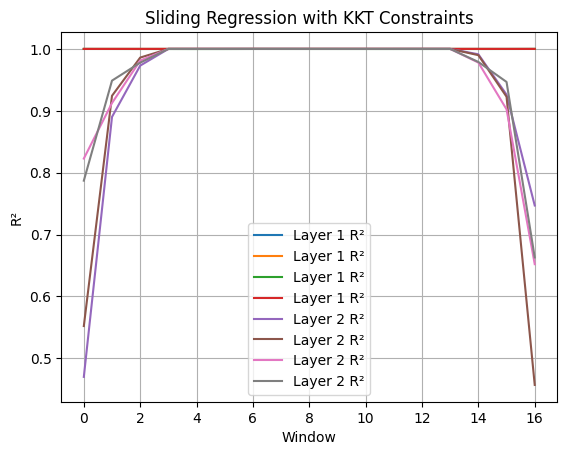

In [40]:
import jax
import jax.numpy as jnp
from jax import vmap
from jax.lax import dynamic_slice
from functools import partial
import matplotlib.pyplot as plt

def kkt_solve(XTX, XTY, A, b):
    """
    Solve constrained least squares using KKT system:
    Minimize ||Xw - y||^2 subject to Aw = b
    """
    n_features, n_outputs = XTY.shape
    n_constraints = A.shape[0]
    zeros = jnp.zeros((n_constraints, n_constraints))

    top = jnp.concatenate([XTX, A.T], axis=1)
    bottom = jnp.concatenate([A, zeros], axis=1)
    KKT = jnp.concatenate([top, bottom], axis=0)

    rhs = jnp.concatenate([XTY, b], axis=0)
    sol = jnp.linalg.solve(KKT, rhs)
    return sol[:n_features]

def masked_kkt_layer(X_wins, Y_wins, penalty_mask, penalty_strength, A, b, control_mask):
    n_windows, n_features, n_outputs = penalty_mask.shape

    def solve_per_window(i):
        X_win = X_wins[i]
        Y_win = Y_wins[i]
        XtX = X_win.T @ X_win
        XtY = X_win.T @ Y_win

        mask_flat = control_mask.reshape(-1)
        active_idx = jnp.where(mask_flat == 1)[0]
        constrained_idx = jnp.where(mask_flat == -1)[0]

        if len(active_idx) == 0:
            return jnp.zeros((n_features, n_outputs))

        P = jnp.eye(n_features) * penalty_strength * jnp.any(penalty_mask[i], axis=-1).astype(jnp.float32)[:, None]
        W = kkt_solve(XtX + P, XtY, A, b)

        # Enforce freezing by zeroing out those not optimized
        frozen_idx = jnp.where(mask_flat == 0)[0]
        W = W.at[frozen_idx].set(0.0)

        return W

    return vmap(solve_per_window)(jnp.arange(n_windows))

def make_sliding_regression_with_penalty_fn(
    X,
    Y,
    window_size,
    stride,
    n_outputs,
    layers,
    penalty_strength=0.0,
    threshold=None,
    freeze_non_masked=False,
    equal_opposite_constraints=None,
    control_masks=None,
    A_matrices=None,
    b_vectors=None,
):
    n_samples, n_features = X.shape
    n_windows = (n_samples - window_size) // stride + 1

    def get_window(X, i):
        return dynamic_slice(X, (i * stride, 0), (window_size, X.shape[1]))

    def get_window_Y(Y, i):
        return dynamic_slice(Y, (i * stride, 0), (window_size, Y.shape[1]))

    @jax.jit
    def ols_kernel(X_win, Y_win):
        XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
        XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
        return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(X_win.shape[1]), XtY)

    W_layers = []
    r2_layers = []
    residual = Y

    for l_idx, layer_config in enumerate(layers):
        X_wins = vmap(get_window, in_axes=(None, 0))(X, jnp.arange(n_windows))
        Y_wins = vmap(get_window_Y, in_axes=(None, 0))(residual, jnp.arange(n_windows))

        W = vmap(ols_kernel)(X_wins, Y_wins)

        if threshold is not None:
            penalty_mask = jnp.abs(W) < threshold
        else:
            penalty_mask = jnp.zeros_like(W, dtype=bool)

        if equal_opposite_constraints:
            for i, j in equal_opposite_constraints:
                W = W.at[:, j, :].set(-W[:, i, :])

        if penalty_strength > 0.0:
            if control_masks and A_matrices and b_vectors and control_masks[l_idx] is not None:
                mask = control_masks[l_idx]
                A = A_matrices[l_idx]
                b = b_vectors[l_idx]
                W_pen = masked_kkt_layer(X_wins, Y_wins, penalty_mask, penalty_strength, A, b, mask)
            else:
                XtX = jnp.einsum("nwf,nwg->nfg", X_wins, X_wins)
                XtY = jnp.einsum("nwf,nwo->nfo", X_wins, Y_wins)
                feature_penalty_mask = jnp.all(penalty_mask, axis=-1)
                penalty_diag = feature_penalty_mask.astype(float) * penalty_strength
                penalty_term = jnp.einsum("nf,fg->nfg", penalty_diag, jnp.eye(n_features))
                W_pen = jnp.linalg.solve(XtX + penalty_term, XtY)

            W_final = jnp.where(penalty_mask, W_pen, W if freeze_non_masked else W_pen)
        else:
            W_final = W

        if threshold is not None:
            W_final = jnp.where(jnp.abs(W_final) < threshold, 0.0, W_final)

        Y_preds = jnp.einsum("nwf,nfo->nwo", X_wins, W_final)
        ss_res = jnp.sum((Y_wins - Y_preds) ** 2, axis=1)
        ss_tot = jnp.sum((Y_wins - jnp.mean(Y_wins, axis=1, keepdims=True)) ** 2, axis=1)
        r2 = 1.0 - (ss_res / (ss_tot + 1e-8))

        flat_preds = jnp.zeros_like(residual)
        for i in range(n_windows):
            idx = i * stride
            flat_preds = flat_preds.at[idx:idx+window_size].add(Y_preds[i])

        residual = residual - flat_preds

        W_layers.append(W_final)
        r2_layers.append(r2)

    return W_layers, r2_layers

if __name__ == "__main__":
    key = jax.random.PRNGKey(0)
    n_samples, n_features, n_outputs = 100, 5, 4
    X = jax.random.normal(key, (n_samples, n_features))
    true_W = jax.random.normal(key, (n_features, n_outputs))
    Y = X @ true_W + 0.01 * jax.random.normal(jax.random.PRNGKey(1), (n_samples, n_outputs))

    control_mask = jnp.ones((n_features, n_outputs))
    control_mask = control_mask.at[0, 0].set(-1)
    control_mask = control_mask.at[1, 0].set(1)
    A = jnp.zeros((1, n_features))
    A = A.at[0, 0].set(1.0).at[0, 1].set(1.0)
    b = jnp.zeros((1, n_outputs))

    weights_constrained, r2s_constrained = make_sliding_regression_with_penalty_fn(
        X, Y,
        window_size=20,
        stride=5,
        n_outputs=n_outputs,
        layers=[{"layer": 1}, {"layer": 2}],
        threshold=0.05,
        penalty_strength=1e3,
        freeze_non_masked=True,
        control_masks=[control_mask, None],
        A_matrices=[A, None],
        b_vectors=[b, None],
    )

    for i, r2 in enumerate(r2s_constrained):
        print(f"Layer {i + 1} R²:", r2)
        plt.plot(r2, label=f"Layer {i + 1} R²")
    plt.xlabel("Window")
    plt.ylabel("R²")
    plt.legend()
    plt.title("Sliding Regression with KKT Constraints")
    plt.grid(True)
    plt.show()


In [41]:
import jax
import jax.numpy as jnp

@jax.jit
def ols_kernel(X_win, Y_win):
    XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
    XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)
    return jnp.linalg.solve(XtX, XtY)

def kkt_solve(XTX, XTY, A, b):
    """
    Solve constrained least squares using KKT system:
    Minimize ||Xw - y||^2 subject to Aw = b
    """
    n_features, n_outputs = XTY.shape
    n_constraints = A.shape[0]
    zeros = jnp.zeros((n_constraints, n_constraints))

    top = jnp.concatenate([XTX, A.T], axis=1)
    bottom = jnp.concatenate([A, zeros], axis=1)
    KKT = jnp.concatenate([top, bottom], axis=0)

    rhs = jnp.concatenate([XTY, b], axis=0)
    sol = jnp.linalg.solve(KKT, rhs)
    return sol[:n_features]

def make_sliding_regression_with_penalty_fn(
    t1, t2, epsilon=1e-3, big_penalty=1e6,
    group_by_country=False, n_countries=None, n_tenors=None,
    group_trigger_mode="mean", forced_group_mask=None, top_n_per_country=None,
    freeze_non_masked=False
):
    @jax.jit
    def _sliding(X, Y):
        n_samples, d_features = X.shape
        n_outputs = Y.shape[1]
        assert d_features == 7, "X must have 7 features"
        assert n_countries * n_tenors == n_outputs, "n_countries * n_tenors must equal Y.shape[1]"

        n_windows = (n_samples - t1) // t2 + 1
        starts = jnp.arange(n_windows) * t2

        def extract_window(data, start):
            return jax.lax.dynamic_slice(data, (start, 0), (t1, data.shape[1]))

        X_wins = jax.vmap(lambda s: extract_window(X, s))(starts)
        Y_wins = jax.vmap(lambda s: extract_window(Y, s))(starts)

        W_ols = jax.vmap(ols_kernel)(X_wins, Y_wins)  # (n_windows, 7, n_outputs)

        if group_by_country:
            W_reshaped = W_ols.reshape((n_windows, 7, n_countries, n_tenors))
            abs_W = jnp.abs(W_reshaped)

            if group_trigger_mode == "forced":
                if forced_group_mask is None:
                    raise ValueError("forced_group_mask must be provided when using 'forced'")
                if forced_group_mask.shape != (n_countries, n_tenors, 7):
                    raise ValueError(f"forced_group_mask must have shape ({n_countries}, {n_tenors}, 7)")
                group_mask_broadcast = jnp.broadcast_to(
                    forced_group_mask[None, :, :, :], (n_windows, n_countries, n_tenors, 7)
                ).transpose(0, 3, 1, 2)  # (n_windows, 7, n_countries, n_tenors)

            else:
                raise ValueError("This setup only covers 'forced' mode for simplicity.")

            penalty_mask = jnp.where(group_mask_broadcast, big_penalty, 0.0).reshape((n_windows, 7, n_countries * n_tenors))
        else:
            threshold = jnp.abs(W_ols) < epsilon
            penalty_mask = jnp.where(threshold, big_penalty, 0.0)

        def penalized_ols(X_win, Y_win, penalty_mat):
            XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
            XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)

            def solve_per_output(XtY_col, penalties_col, idx):
                if penalties_col[0] == -1.0:  # signal for equality constraint: w0 + w1 = 0 => w1 = -w0
                    A = jnp.zeros((1, 7))
                    A = A.at[0, 0].set(1.0).at[0, 1].set(1.0)
                    b = jnp.zeros((1,))
                    return kkt_solve(XtX, XtY_col[:, None], A, b)[:, 0]
                else:
                    XtX_penalized = XtX + jnp.diag(penalties_col)
                    return jnp.linalg.solve(XtX_penalized, XtY_col)

            idxs = jnp.arange(Y_win.shape[1])
            W_cols = jax.vmap(solve_per_output, in_axes=(1, 1, 0))(XtY, penalty_mat, idxs)
            return W_cols.T  # (7, n_outputs)

        W_penalized = jax.vmap(penalized_ols)(X_wins, Y_wins, penalty_mask)

        W_final = jnp.where(penalty_mask > 0, W_penalized, W_ols) if freeze_non_masked else W_penalized

        def compute_r2(X_w, Y_w, W):
            Y_pred = jnp.einsum('wij,wjk->wik', X_w, W)  # (n_windows, t1, n_outputs)
            resid_sq = jnp.sum((Y_w - Y_pred) ** 2, axis=1)
            y_mean = jnp.mean(Y_w, axis=1, keepdims=True)
            total_sq = jnp.sum((Y_w - y_mean) ** 2, axis=1)
            return 1.0 - resid_sq / total_sq  # (n_windows, n_outputs)

        r2_ols = compute_r2(X_wins, Y_wins, W_ols)
        r2_final = compute_r2(X_wins, Y_wins, W_final)

        r2_ols_mean = jnp.mean(r2_ols, axis=0)
        r2_final_mean = jnp.mean(r2_final, axis=0)

        return W_ols, W_final, r2_ols_mean, r2_final_mean

    return _sliding


In [43]:
import jax
import jax.numpy as jnp
#from sliding_kkt import make_sliding_regression_with_penalty_fn

# Parameters
n_samples = 100
n_features = 7
country_labels = ['US', 'DE']
tenor_labels = ['1Y', '10Y']
n_countries = len(country_labels)
n_tenors = len(tenor_labels)
n_outputs = n_countries * n_tenors

# Synthetic data
key = jax.random.PRNGKey(0)
X = jax.random.normal(key, (n_samples, n_features))
true_W = jax.random.normal(key, (n_features, n_outputs))
Y = X @ true_W + 0.01 * jax.random.normal(key, (n_samples, n_outputs))

# === Forced freeze mask ===
forced_group_mask = jnp.zeros((n_countries, n_tenors, n_features), dtype=bool)

# Freeze feature 6 (last one) for all outputs
forced_group_mask = forced_group_mask.at[:, :, 6].set(True)

# === Equality constraints: w0 + w1 = 0 ===
# Apply to output 0 (US-1Y)
# That means: w0 + w1 = 0, so w1 = -w0
A = jnp.zeros((1, n_features))
A = A.at[0, 0].set(1.0).at[0, 1].set(1.0)  # w0 + w1 = 0
b = jnp.array([0.0])

constraint_map = {
    0: (A, b),  # apply to US-1Y (output index 0)
}

# Create function
sliding_fn = make_sliding_regression_with_penalty_fn(
    t1=20,
    t2=5,
    epsilon=0.05,
    big_penalty=1e6,
    group_by_country=True,
    n_countries=n_countries,
    n_tenors=n_tenors,
    group_trigger_mode="forced",
    forced_group_mask=forced_group_mask,
    freeze_non_masked=True,
    constraint_map=constraint_map,
)

# Run
W_ols, W_final, r2_ols, r2_final = sliding_fn(X, Y)

# === Check results ===
print("R² (Final):", r2_final)
print("\nFrozen coefficients (should be 0):")
print("Feature 6, all outputs:", W_final[:, 6, :])  # Feature 6 is frozen

print("\nEquality constrained coefficients (should sum to 0):")
w0 = W_final[:, 0, 0]  # feature 0 for output 0
w1 = W_final[:, 1, 0]  # feature 1 for output 0
print("w0 + w1 for output 0:", w0 + w1)

TypeError: make_sliding_regression_with_penalty_fn() got an unexpected keyword argument 'constraint_map'

In [47]:
import jax
import jax.numpy as jnp
import pandas as pd

@jax.jit
def ols_kernel(X_win, Y_win):
    XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
    XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)
    return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(XtX.shape[0]), XtY)

def kkt_solve_single_output(XTX, XTY_col, A, b_val):
    """
    Solves: min ||Xw - y||² s.t. Aw = b_val  (for a single output column)
    """
    n_features = XTX.shape[0]
    n_constraints = A.shape[0]
    KKT = jnp.block([
        [XTX,         A.T],
        [A,  jnp.zeros((n_constraints, n_constraints))]
    ])
    rhs = jnp.concatenate([XTY_col, b_val])
    sol = jnp.linalg.solve(KKT, rhs)
    return sol[:n_features]

def make_sliding_regression_with_penalty_fn(
    t1, t2, epsilon=1e-3, big_penalty=1e6,
    group_by_country=False, n_countries=None, n_tenors=None,
    group_trigger_mode="mean", forced_group_mask=None, top_n_per_country=None,
    freeze_non_masked=False, constraint_map=None,
):
    def _sliding(X, Y):
        n_samples, d_features = X.shape
        n_outputs = Y.shape[1]
        n_windows = (n_samples - t1) // t2 + 1
        starts = jnp.arange(n_windows) * t2

        def extract_window(data, start):
            return jax.lax.dynamic_slice(data, (start, 0), (t1, data.shape[1]))

        X_wins = jax.vmap(lambda s: extract_window(X, s))(starts)
        Y_wins = jax.vmap(lambda s: extract_window(Y, s))(starts)

        W_ols = jax.vmap(ols_kernel)(X_wins, Y_wins)

        threshold = jnp.abs(W_ols) < epsilon
        penalty_mask = jnp.where(threshold, big_penalty, 0.0)

        def penalized_ols_with_kkt(X_win, Y_win, penalty_mat):
            XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
            XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)
            XtX_penalized = XtX + jnp.diag(penalty_mat)

            W = []
            for output_idx in range(Y_win.shape[1]):
                XtY_col = XtY[:, output_idx]
                if constraint_map:
                    A_rows = []
                    b_rows = []
                    for (i, j, col), val in constraint_map:
                        if col == output_idx:
                            row = jnp.zeros((XtX.shape[0],))
                            row = row.at[i].set(1.0).at[j].set(1.0)
                            A_rows.append(row)
                            b_rows.append(val)
                    if A_rows:
                        A = jnp.stack(A_rows, axis=0)
                        b_val = jnp.array(b_rows)
                        w = kkt_solve_single_output(XtX_penalized, XtY_col, A, b_val)
                    else:
                        w = jnp.linalg.solve(XtX_penalized, XtY_col)
                else:
                    w = jnp.linalg.solve(XtX_penalized, XtY_col)
                W.append(w)
            return jnp.stack(W, axis=-1)  # (d_features, n_outputs)

        W_penalized = jax.vmap(penalized_ols_with_kkt)(X_wins, Y_wins, penalty_mask)

        W_final = jnp.where(penalty_mask > 0, W_penalized, W_ols) if freeze_non_masked else W_penalized

        def compute_r2(X_w, Y_w, W):
            Y_pred = jnp.einsum('wij,wjk->wik', X_w, W)
            resid_sq = jnp.sum((Y_w - Y_pred) ** 2, axis=1)
            y_mean = jnp.mean(Y_w, axis=1, keepdims=True)
            total_sq = jnp.sum((Y_w - y_mean) ** 2, axis=1)
            return 1.0 - resid_sq / (total_sq + 1e-8)

        r2_ols = compute_r2(X_wins, Y_wins, W_ols)
        r2_final = compute_r2(X_wins, Y_wins, W_final)

        return W_ols, W_final, jnp.mean(r2_ols, axis=0), jnp.mean(r2_final, axis=0)

    return _sliding

In [48]:
constraint_map = {
    0: (jnp.array([[1, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 1, 0, 0]]),
        jnp.array([0.0, -0.5])),
    1: (jnp.array([[0, 1, 0, 0, 0, 0, 1]]), jnp.array([0.0])),  # w1 + w6 = 0
}

In [49]:
if __name__ == "__main__":
    key = jax.random.PRNGKey(0)
    n_samples = 100
    d_features = 7
    n_outputs = 2

    X = jax.random.normal(key, (n_samples, d_features))

    # True weights with structure
    true_W = jnp.zeros((d_features, n_outputs))
    true_W = true_W.at[0, 0].set(1.0)    # frozen to 1.0
    true_W = true_W.at[1, 1].set(1.5)
    true_W = true_W.at[6, 1].set(-1.5)   # should be opposite of [1,1]

    Y = X @ true_W + 0.01 * jax.random.normal(jax.random.PRNGKey(1), (n_samples, n_outputs))

    # Constraints:
    constraint_map = [
        (0, 0, 0, 2.0),   # w[0,0] + w[0,0] = 2 → w[0,0] = 1
        (1, 6, 1, 0.0),   # w[1,1] + w[6,1] = 0 → opposites
    ]

    sliding_fn = make_sliding_regression_with_penalty_fn(
        t1=20, t2=5,
        freeze_non_masked=True,
        constraint_map=constraint_map
    )

    W_ols, W_final, r2_ols, r2_final = sliding_fn(X, Y)

    print("Final R²:", r2_final.round(4))

    df = pd.DataFrame(W_final[-1], columns=["Output 0", "Output 1"])
    df["Hedge"] = [f"H{i}" for i in range(d_features)]
    print(df.set_index("Hedge").round(3))b

ValueError: Incompatible shapes for broadcasting: shapes=[(7, 7), (2,)]

In [50]:
import jax
import jax.numpy as jnp
from functools import partial
from typing import Optional

def make_sliding_regression_with_penalty_fn(
    t1, t2, epsilon=1e-3, big_penalty=1e6,
    group_by_country=False, n_countries=None, n_tenors=None,
    group_trigger_mode="mean", forced_group_mask=None, top_n_per_country=None,
    freeze_non_masked=False, constraint_pairs: Optional[list] = None
):
    @jax.jit
    def _sliding(X, Y):
        n_samples, d_features = X.shape
        n_outputs = Y.shape[1]
        assert d_features == 7, "X must have 7 features"
        assert n_countries * n_tenors == n_outputs, "n_countries * n_tenors must equal Y.shape[1]"

        n_windows = (n_samples - t1) // t2 + 1
        starts = jnp.arange(n_windows) * t2

        def extract_window(data, start):
            return jax.lax.dynamic_slice(data, (start, 0), (t1, data.shape[1]))

        X_wins = jax.vmap(lambda s: extract_window(X, s))(starts)
        Y_wins = jax.vmap(lambda s: extract_window(Y, s))(starts)

        def ols_kernel(X_win, Y_win):
            XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
            XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)
            return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(XtX.shape[0]), XtY)

        W_ols = jax.vmap(ols_kernel)(X_wins, Y_wins)  # (n_windows, 7, n_outputs)

        if group_by_country:
            W_reshaped = W_ols.reshape((n_windows, 7, n_countries, n_tenors))
            if group_trigger_mode == "forced":
                group_mask_broadcast = jnp.broadcast_to(
                    forced_group_mask[None, :, :, :], (n_windows, n_countries, n_tenors, 7)
                ).transpose(0, 3, 1, 2)  # (n_windows, 7, n_countries, n_tenors)
            else:
                raise ValueError("Only 'forced' mode supported for group_by_country")

            penalty_mask = jnp.where(group_mask_broadcast, big_penalty, 0.0).reshape((n_windows, 7, n_countries * n_tenors))
        else:
            threshold = jnp.abs(W_ols) < epsilon
            penalty_mask = jnp.where(threshold, big_penalty, 0.0)

        def kkt_solve(XtX, XtY_col, penalty_diag, constraint_matrix):
            P = XtX + jnp.diag(penalty_diag)
            if constraint_matrix is not None:
                A = constraint_matrix
                Z = jnp.zeros((A.shape[0], A.shape[0]))
                KKT = jnp.block([[P, A.T], [A, Z]])
                rhs = jnp.concatenate([XtY_col, jnp.zeros(A.shape[0])])
                sol = jnp.linalg.solve(KKT, rhs)
                return sol[:P.shape[0]]
            else:
                return jnp.linalg.solve(P, XtY_col)

        def penalized_ols(X_win, Y_win, penalty_mat):
            XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
            XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)

            if constraint_pairs:
                A = jnp.zeros((len(constraint_pairs), XtX.shape[0]))
                for k, (i, j) in enumerate(constraint_pairs):
                    A = A.at[k, i].set(1.0)
                    A = A.at[k, j].set(1.0)
            else:
                A = None

            solve_fn = partial(kkt_solve, XtX, penalty_diag=penalty_mat, constraint_matrix=A)
            W_cols = jax.vmap(solve_fn, in_axes=(1,))(XtY)
            return W_cols.T  # (7, n_outputs)

        W_penalized = jax.vmap(penalized_ols)(X_wins, Y_wins, penalty_mask)

        W_final = jnp.where(penalty_mask > 0, W_penalized, W_ols) if freeze_non_masked else W_penalized

        def compute_r2(X_w, Y_w, W):
            Y_pred = jnp.einsum('wij,wjk->wik', X_w, W)
            resid_sq = jnp.sum((Y_w - Y_pred) ** 2, axis=1)
            y_mean = jnp.mean(Y_w, axis=1, keepdims=True)
            total_sq = jnp.sum((Y_w - y_mean) ** 2, axis=1)
            return 1.0 - resid_sq / total_sq

        r2_ols = compute_r2(X_wins, Y_wins, W_ols)
        r2_final = compute_r2(X_wins, Y_wins, W_final)

        return W_ols, W_final, jnp.mean(r2_ols, axis=0), jnp.mean(r2_final, axis=0)

    return _sliding

In [51]:
import jax.numpy as jnp
from jax.random import PRNGKey, normal

# Create dummy data
X = normal(PRNGKey(0), (100, 7))
Y = normal(PRNGKey(1), (100, 14))  # e.g., 2 countries × 7 tenors

forced_group_mask = jnp.ones((2, 7, 7))  # Freeze everything for demo
constraint_pairs = [(0, 1), (2, 3)]  # Enforce w0 = -w1 and w2 = -w3

reg_fn = make_sliding_regression_with_penalty_fn(
    t1=20, t2=5,
    group_by_country=True,
    n_countries=2, n_tenors=7,
    group_trigger_mode="forced",
    forced_group_mask=forced_group_mask,
    freeze_non_masked=False,
    constraint_pairs=constraint_pairs,
)

W_ols, W_final, r2_ols, r2_final = reg_fn(X, Y)

# Show the first window weights
print("W_final[0]:", W_final[0])
print("w0 + w1:", W_final[0][0] + W_final[0][1])  # Should be ≈ 0
print("w2 + w3:", W_final[0][2] + W_final[0][3])  # Should be ≈ 0

W_final[0]: [[ 5.29816449e-01 -2.00032163e-02  1.71514228e-01  1.37577942e-02
  -1.79160014e-02 -1.08199015e-01 -9.15359035e-02  8.08931794e-03
   4.71066386e-02  1.45771459e-01 -1.25757987e-02 -5.34272790e-02
  -2.82377237e-03  2.42437914e-01]
 [-5.29816449e-01  2.00032145e-02 -1.71514213e-01 -1.37578482e-02
   1.79160163e-02  1.08199008e-01  9.15359184e-02 -8.08925182e-03
  -4.71066199e-02 -1.45771384e-01  1.25758080e-02  5.34273125e-02
   2.82376283e-03 -2.42437854e-01]
 [-1.68716841e-04  3.19574505e-01  1.26188099e-01  3.83170068e-01
  -5.43154664e-02 -5.63515276e-02 -1.07254788e-01  2.38467485e-01
  -2.35946268e-01 -1.99103966e-01  4.93190348e-01 -3.32058370e-01
  -2.71248877e-01 -3.16248655e-01]
 [ 1.68720988e-04 -3.19574445e-01 -1.26188055e-01 -3.83170038e-01
   5.43154739e-02  5.63515238e-02  1.07254758e-01 -2.38467485e-01
   2.35946223e-01  1.99103892e-01 -4.93190318e-01  3.32058400e-01
   2.71248817e-01  3.16248536e-01]
 [-2.43398249e-01 -1.82094589e-01  2.88935691e-01 -7.648

In [56]:
def freeze_small_coefficients(W_init, threshold=0.1, n_countries=2, n_tenors=7):
    """
    Returns a boolean mask (n_countries, n_tenors, n_features)
    where all coefficients below threshold are frozen (True).
    """
    n_windows, n_features, n_outputs = W_init.shape
    W_avg = jnp.mean(W_init, axis=0)  # (n_features, n_outputs)
    W_grid = W_avg.reshape((n_features, n_countries, n_tenors)).transpose(1, 2, 0)
    return jnp.abs(W_grid) < threshold

In [57]:
def top_k_mask(W_init, k=3, n_countries=2, n_tenors=7):
    """
    Freeze all but top-k largest (absolute) coefficients for each (country, tenor).
    Returns mask of shape (n_countries, n_tenors, n_features).
    """
    n_windows, n_features, n_outputs = W_init.shape
    W_avg = jnp.mean(W_init, axis=0)  # (n_features, n_outputs)
    W_grid = W_avg.reshape((n_features, n_countries, n_tenors)).transpose(1, 2, 0)

    def freeze_except_top_k(vec):
        abs_vals = jnp.abs(vec)
        if vec.shape[0] <= k:
            return jnp.zeros_like(vec, dtype=bool)
        top_k_thresh = jnp.sort(abs_vals)[-k]
        return abs_vals < top_k_thresh

    return jax.vmap(jax.vmap(freeze_except_top_k))(W_grid)

In [58]:
# Run initial regression
W_ols, _, _, _ = reg_fn(X, Y)

# Use case 1: Freeze small values
mask_small = freeze_small_coefficients(W_ols, threshold=0.1, n_countries=2, n_tenors=7)
reg_fn_small = make_sliding_regression_with_penalty_fn(
    t1=20, t2=5,
    group_by_country=True,
    n_countries=2, n_tenors=7,
    group_trigger_mode="forced",
    forced_group_mask=mask_small,
    freeze_non_masked=True
)
_, W_small, _, _ = reg_fn_small(X, Y)

# Use case 2: Top 3 only
mask_top3 = top_k_mask(W_ols, k=3, n_countries=2, n_tenors=7)
reg_fn_top3 = make_sliding_regression_with_penalty_fn(
    t1=20, t2=5,
    group_by_country=True,
    n_countries=2, n_tenors=7,
    group_trigger_mode="forced",
    forced_group_mask=mask_top3,
    freeze_non_masked=True
)
_, W_top3, _, _ = reg_fn_top3(X, Y)

In [62]:

import jax
import jax.numpy as jnp

def ols_kernel(X_win, Y_win):
    XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
    XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)
    return jnp.linalg.solve(XtX, XtY)

def make_freeze_small_coefs_fn(threshold):
    def freeze_fn(W_ols, **kwargs):
        return jnp.abs(W_ols) < threshold
    return freeze_fn

def make_freeze_topk_fn(k):
    def freeze_fn(W_ols, n_countries, n_tenors, **kwargs):
        reshaped = W_ols.reshape(W_ols.shape[0], 7, n_countries, n_tenors)
        abs_vals = jnp.abs(reshaped)
        topk_mask = jax.vmap(lambda A: jnp.argsort(-A, axis=0) < k)(abs_vals)
        return ~topk_mask.reshape(W_ols.shape)
    return freeze_fn

def make_sliding_regression_with_penalty_fn(
    t1, t2, epsilon=1e-3, big_penalty=1e6,
    group_by_country=False, n_countries=None, n_tenors=None,
    freeze_mask_fn=None
):
    @jax.jit
    def _sliding(X, Y):
        n_samples, d_features = X.shape
        n_outputs = Y.shape[1]

        n_windows = (n_samples - t1) // t2 + 1
        starts = jnp.arange(n_windows) * t2

        def extract_window(data, start):
            return jax.lax.dynamic_slice(data, (start, 0), (t1, data.shape[1]))

        X_wins = jax.vmap(lambda s: extract_window(X, s))(starts)
        Y_wins = jax.vmap(lambda s: extract_window(Y, s))(starts)

        W_ols = jax.vmap(ols_kernel)(X_wins, Y_wins)

        freeze_mask = freeze_mask_fn(W_ols, n_countries=n_countries, n_tenors=n_tenors)

        penalty_mask = jnp.where(freeze_mask, big_penalty, 0.0)

        def penalized_ols(X_win, Y_win, penalty_mat):
            XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
            XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)

            def solve_per_output(XtY_col, penalties_col):
                XtX_penalized = XtX + jnp.diag(penalties_col)
                return jnp.linalg.solve(XtX_penalized, XtY_col)

            W_cols = jax.vmap(solve_per_output, in_axes=(1, 1))(XtY, penalty_mat)
            return W_cols.T

        W_penalized = jax.vmap(penalized_ols)(X_wins, Y_wins, penalty_mask)

        return W_ols, W_penalized

    return _sliding

# === Simulated usage ===
if __name__ == "__main__":
    key = jax.random.PRNGKey(0)
    X = jax.random.normal(key, (100, 7))
    Y = jax.random.normal(key, (100, 4))

    sliding_small = make_sliding_regression_with_penalty_fn(
        t1=20, t2=5, group_by_country=True,
        n_countries=2, n_tenors=2,
        freeze_mask_fn=make_freeze_small_coefs_fn(0.1)
    )

    sliding_topk = make_sliding_regression_with_penalty_fn(
        t1=20, t2=5, group_by_country=True,
        n_countries=2, n_tenors=2,
        freeze_mask_fn=make_freeze_topk_fn(3)
    )

    W_ols1, W_small = sliding_small(X, Y)
    W_ols2, W_topk = sliding_topk(X, Y)

    print("OLS Coefs Window 0\n", W_ols1[0])
    print("Threshold Freeze Coefs Window 0\n", W_small[0])
    print("Top-K Freeze Coefs Window 0\n", W_topk[0])


OLS Coefs Window 0
 [[ 0.22894764 -0.02405213 -0.38680112  0.09816887]
 [-0.14775051 -0.10750224  0.4516473   0.07019217]
 [ 0.14874122  0.06383329  0.60472673  0.04898349]
 [-0.15933858  0.06994274  0.58371055  0.00621075]
 [-0.07427448  0.01253042  0.3437903  -0.39994952]
 [-0.25585037 -0.1997716  -0.4747024   0.39745852]
 [-0.03136035 -0.29631773  0.16609405  0.15496944]]
Threshold Freeze Coefs Window 0
 [[ 1.8411405e-01 -5.3445582e-08 -3.8680109e-01  2.5863376e-06]
 [-1.0656355e-01 -1.3278396e-01  4.5164728e-01  1.9058480e-06]
 [ 1.5214676e-01  8.6847842e-07  6.0472667e-01  9.2692801e-07]
 [-1.0270263e-01  6.5438769e-07  5.8371061e-01  2.5064932e-07]
 [-4.6686785e-07 -4.9894305e-07  3.4379029e-01 -3.5722420e-01]
 [-2.7241230e-01 -1.6553806e-01 -4.7470239e-01  3.4242842e-01]
 [ 9.7476525e-09 -3.4690604e-01  1.6609405e-01  1.3863745e-01]]
Top-K Freeze Coefs Window 0
 [[ 2.0312814e-06 -1.7533886e-06  7.5254969e-02  2.8942059e-06]
 [ 1.3348228e-01 -8.7666240e-07  5.2254968e-06  1.49737

In [61]:
W_small[10]

Array([[-0.48428667,  0.07699652,  0.1475732 ,  0.26333627,  0.2182238 ,
        -0.2599855 , -0.06818976,  0.5496415 , -0.41307345, -0.20808685,
         0.14907378, -0.06571806, -0.4116185 , -0.02566675],
       [-0.03355263, -0.21463586, -0.43303734,  0.248924  , -0.16710165,
        -0.34281182, -0.10916547, -0.07947405,  0.29370806,  0.5120678 ,
        -0.143204  ,  0.35104543,  0.22533402,  0.25231963],
       [ 0.02201707,  0.32293802, -0.18571445, -0.07554901, -0.0590999 ,
         0.03039274, -0.06768978,  0.1717013 , -0.3453969 , -0.01350692,
        -0.28562513,  0.03011572,  0.01378939,  0.1279153 ],
       [-0.25966185,  0.02478139, -0.796661  ,  0.02542815,  0.36425698,
        -0.4793496 ,  0.31569088,  0.24514534,  0.01307542,  0.65340734,
         0.31871217,  0.5958381 , -0.13344449, -0.17920111],
       [-0.27162278, -0.3362932 ,  0.13028502, -0.24002554, -0.1497772 ,
         0.48016697, -0.4107429 ,  0.2220934 , -0.32007718, -0.6381671 ,
         0.5392965 , -0.17

In [63]:
import jax
import jax.numpy as jnp
from typing import Optional, List, Tuple

def ols_kernel(X_win, Y_win):
    XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
    XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)
    return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(XtX.shape[0]), XtY)

def penalized_solver(XtX, XtY, penalty_mask):
    d = XtX.shape[0]
    XtX_reg = XtX + jnp.diag(penalty_mask)
    return jnp.linalg.solve(XtX_reg + 1e-6 * jnp.eye(d), XtY)

def kkt_solver(XtX, XtY, constraint_map: List[Tuple[int, int]]):
    d, o = XtY.shape
    A = jnp.zeros((len(constraint_map), d))
    for idx, (i, j) in enumerate(constraint_map):
        A = A.at[idx, i].set(1.0).at[idx, j].set(1.0)
    lhs = jnp.block([[XtX, A.T], [A, jnp.zeros((len(constraint_map), len(constraint_map)))]])
    rhs = jnp.concatenate([XtY, jnp.zeros((len(constraint_map), o))], axis=0)
    sol = jnp.linalg.solve(lhs + 1e-6 * jnp.eye(lhs.shape[0]), rhs)
    return sol[:d]

def make_sliding_regression_fn(
    t1: int,
    t2: int,
    method: str = "penalty",
    freeze_below: Optional[float] = None,
    freeze_top_k: Optional[int] = None,
    constraint_map: Optional[List[Tuple[int, int]]] = None,
    big_penalty: float = 1e6
):
    def _sliding(X, Y):
        n_samples = X.shape[0]
        n_windows = (n_samples - t1) // t2 + 1
        starts = jnp.arange(n_windows) * t2

        def extract(data, s): return jax.lax.dynamic_slice(data, (s, 0), (t1, data.shape[1]))
        X_wins = jax.vmap(lambda s: extract(X, s))(starts)
        Y_wins = jax.vmap(lambda s: extract(Y, s))(starts)
        W_ols = jax.vmap(ols_kernel)(X_wins, Y_wins)

        def process_window(Xw, Yw, Wols):
            XtX = jnp.einsum('ni,nj->ij', Xw, Xw)
            XtY = jnp.einsum('ni,nj->ij', Xw, Yw)
            if method == "penalty":
                if freeze_below is not None:
                    penalty_mask = jnp.where(jnp.abs(Wols) < freeze_below, big_penalty, 0.0).mean(axis=1)
                    return penalized_solver(XtX, XtY, penalty_mask)
                elif freeze_top_k is not None:
                    abs_W = jnp.abs(Wols)
                    topk_mask = abs_W >= jnp.sort(abs_W, axis=0)[-freeze_top_k]
                    penalty_mask = jnp.where(topk_mask, 0.0, big_penalty).mean(axis=1)
                    return penalized_solver(XtX, XtY, penalty_mask)
                else:
                    return Wols
            elif method == "kkt":
                return kkt_solver(XtX, XtY, constraint_map)
            else:
                return Wols

        return W_ols, jax.vmap(process_window)(X_wins, Y_wins, W_ols)

    return _sliding

# === Example Usage ===
if __name__ == "__main__":
    key = jax.random.PRNGKey(0)
    X = jax.random.normal(key, (100, 7))
    true_w = jax.random.normal(key, (7, 2))
    Y = X @ true_w + 0.01 * jax.random.normal(key, (100, 2))

    print("=== Penalty: freeze_below=0.1 ===")
    fn1 = make_sliding_regression_fn(t1=20, t2=5, method="penalty", freeze_below=0.1)
    W_ols_1, W_pen1 = fn1(X, Y)
    print(W_pen1[0])

    print("\n=== Penalty: freeze_top_k=3 ===")
    fn2 = make_sliding_regression_fn(t1=20, t2=5, method="penalty", freeze_top_k=3)
    W_ols_2, W_pen2 = fn2(X, Y)
    print(W_pen2[0])

    print("\n=== KKT: enforce w0=-w1, w2=-w3 ===")
    fn3 = make_sliding_regression_fn(t1=20, t2=5, method="kkt", constraint_map=[(0, 1), (2, 3)])
    W_ols_3, W_kkt = fn3(X, Y)
    print(W_kkt[0])

=== Penalty: freeze_below=0.1 ===
[[ 1.3391428e+00  1.9776200e+00]
 [-4.8358415e-06 -8.1639826e-07]
 [ 2.0709848e-01 -9.6601880e-01]
 [-3.0414930e-01  5.2577537e-01]
 [ 8.8155407e-01 -9.1336012e-01]
 [ 2.2590239e+00 -1.9342281e+00]
 [ 5.5357414e-01  1.9163607e-01]]

=== Penalty: freeze_top_k=3 ===
[[ 1.7666317e+00  1.5212013e+00]
 [-8.5192705e-06  3.3412684e-06]
 [ 2.5087913e-06 -2.7868888e-05]
 [-1.5775793e-05  1.3506263e-05]
 [ 3.2689946e-05 -3.5118443e-05]
 [ 2.6110225e+00 -2.1871352e+00]
 [ 1.0607421e-05  1.2782584e-07]]

=== KKT: enforce w0=-w1, w2=-w3 ===
[[ 1.2067127   1.366693  ]
 [-1.206727   -1.3667164 ]
 [ 0.32093084 -0.7479519 ]
 [-0.32092968  0.74795353]
 [ 0.9235154  -0.5496193 ]
 [ 1.4919665  -3.0607092 ]
 [ 0.32867762  0.08968131]]


In [65]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import jit

# === REGRESSION KERNELS ===

@jit
def ols_kernel(X, Y):
    XtX = X.T @ X
    XtY = X.T @ Y
    return jnp.linalg.solve(XtX, XtY)

@jit
def penalized_kernel(X, Y, penalty_mask, big_penalty=1e6):
    XtX = X.T @ X
    XtY = X.T @ Y
    penalty_vec = penalty_mask * big_penalty
    XtX_pen = XtX + jnp.diag(penalty_vec)
    return jnp.linalg.solve(XtX_pen, XtY)

def kkt_kernel(X, Y, constraint_mask_np):
    # convert to JAX arrays for computation
    constraint_mask = jnp.array(constraint_mask_np)
    n_features = X.shape[1]
    unconstrained = ~constraint_mask
    A = jnp.eye(n_features)[constraint_mask_np]  # (k, n_features)

    k = A.shape[0]
    XtX = X.T @ X
    XtY = X.T @ Y

    KKT_mat = jnp.block([
        [XtX, A.T],
        [A, jnp.zeros((k, k))]
    ])
    rhs = jnp.concatenate([XtY, jnp.zeros((k,))])
    sol = jnp.linalg.solve(KKT_mat, rhs)
    return sol[:n_features]

# === SYNTHETIC DATA ===

def generate_data():
    n = 100
    d = 7
    rng = jax.random.PRNGKey(0)
    X = jax.random.normal(rng, (n, d))
    true_w = jnp.array([0.8, 0.12, -0.05, 0.5, -0.09, 0.01, 0.3])
    Y = X @ true_w + 0.05 * jax.random.normal(rng, (n,))
    return X, Y, true_w

# === RUN COMPARISON ===

def compare_methods():
    X, Y, true_w = generate_data()
    w_ols = ols_kernel(X, Y)

    threshold = 0.1
    penalty_mask = jnp.abs(w_ols) < threshold
    penalty_mask_np = np.array(penalty_mask)  # make boolean index concrete

    w_penalized = penalized_kernel(X, Y, penalty_mask)
    w_kkt = kkt_kernel(X, Y, penalty_mask_np)

    print("\nTrue Coefficients:\n", true_w)
    print("\nOLS Coefficients:\n", w_ols)
    print("\nPenalty-based Zeroed Coefficients:\n", w_penalized)
    print("\nKKT-hard Zeroed Coefficients:\n", w_kkt)
    print("\nZeroed Indices (abs(w_ols) < 0.1):\n", penalty_mask)

    return {
        "true": true_w,
        "ols": w_ols,
        "penalized": w_penalized,
        "kkt": w_kkt,
        "mask": penalty_mask
    }

if __name__ == "__main__":
    compare_methods()


True Coefficients:
 [ 0.8   0.12 -0.05  0.5  -0.09  0.01  0.3 ]

OLS Coefficients:
 [ 0.7997965   0.12368838 -0.05348163  0.5116986  -0.08930203  0.00606746
  0.29874113]

Penalty-based Zeroed Coefficients:
 [ 7.9261339e-01  1.2256200e-01 -5.4927614e-06  5.3273952e-01
 -5.8836376e-06 -1.2300347e-06  3.0509391e-01]

KKT-hard Zeroed Coefficients:
 [ 7.92612731e-01  1.22561924e-01  5.16618481e-09  5.32740891e-01
  2.89432545e-09 -2.69133738e-09  3.05094659e-01]

Zeroed Indices (abs(w_ols) < 0.1):
 [False False  True False  True  True False]


In [66]:
# compare_kkt_vs_penalty.py

import jax
import jax.numpy as jnp
import numpy as np
import time

# --- Ordinary Least Squares ---
@jax.jit
def ols_kernel(X, Y):
    XtX = X.T @ X
    XtY = X.T @ Y
    return jnp.linalg.solve(XtX, XtY)

# --- Penalized Regression ---
@jax.jit
def penalized_kernel(X, Y, penalty_mask, big_penalty=1e6):
    XtX = X.T @ X
    XtY = X.T @ Y
    penalty_vec = penalty_mask * big_penalty
    XtX_pen = XtX + jnp.diag(penalty_vec)
    return jnp.linalg.solve(XtX_pen, XtY)

# --- KKT Constraint Regression ---
def kkt_kernel(X, Y, constraint_mask_np):
    constraint_mask = jnp.array(constraint_mask_np)
    n_features = X.shape[1]
    A = jnp.eye(n_features)[constraint_mask_np]
    k = A.shape[0]
    XtX = X.T @ X
    XtY = X.T @ Y
    KKT_mat = jnp.block([
        [XtX, A.T],
        [A, jnp.zeros((k, k))]
    ])
    rhs = jnp.concatenate([XtY, jnp.zeros((k,))])
    sol = jnp.linalg.solve(KKT_mat, rhs)
    return sol[:n_features]

# --- Benchmarking ---
def benchmark_large_scale(n_samples=10_000, n_features=64, threshold=0.05):
    rng = jax.random.PRNGKey(0)
    X = jax.random.normal(rng, (n_samples, n_features))
    true_w = jax.random.normal(rng, (n_features,))
    Y = X @ true_w + 0.05 * jax.random.normal(rng, (n_samples,))

    w_ols = ols_kernel(X, Y)
    penalty_mask = jnp.abs(w_ols) < threshold
    penalty_mask_np = np.array(penalty_mask)

    # Penalized
    start_pen = time.time()
    w_pen = penalized_kernel(X, Y, penalty_mask)
    time_pen = time.time() - start_pen

    # KKT
    start_kkt = time.time()
    w_kkt = kkt_kernel(X, Y, penalty_mask_np)
    time_kkt = time.time() - start_kkt

    diff_norm = jnp.linalg.norm(w_kkt - w_pen)

    print("== Comparison ==")
    print(f"Penalized time (s): {time_pen:.6f}")
    print(f"KKT time (s):      {time_kkt:.6f}")
    print(f"L2 diff norm:      {diff_norm:.6e}")

if __name__ == "__main__":
    benchmark_large_scale()

== Comparison ==
Penalized time (s): 0.400407
KKT time (s):      1.419613
L2 diff norm:      7.953540e-04


In [73]:

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns


@jax.jit
def ols_kernel(X_win, Y_win):
    XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
    XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)
    return jnp.linalg.solve(XtX, XtY)


@jax.jit
def penalized_ols(X_win, Y_win, penalty_mat):
    XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
    XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)

    def solve_per_output(XtY_col, penalties_col):
        XtX_penalized = XtX + jnp.diag(penalties_col)
        return jnp.linalg.solve(XtX_penalized, XtY_col)

    W_cols = jax.vmap(solve_per_output, in_axes=(1, 1))(XtY, penalty_mat)
    return W_cols.T  # (7, n_outputs)


@jax.jit
def kkt_kernel(X_win, Y_win, freeze_mask):
    n, d = X_win.shape
    _, m = Y_win.shape
    F = jnp.logical_not(freeze_mask)
    XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
    XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)

    def solve_for_column(XtY_col, F_col):
        F_idx = jnp.where(F_col)[0]
        XtX_ff = XtX[jnp.ix_(F_idx, F_idx)]
        XtY_f = XtY_col[F_idx]
        w_f = jnp.linalg.solve(XtX_ff, XtY_f)
        w_full = jnp.zeros_like(F_col, dtype=jnp.float32).at[F_idx].set(w_f)
        return w_full

    return jax.vmap(solve_for_column, in_axes=(1, 1), out_axes=1)(XtY, F)


def make_sliding_regression_with_constraint_fn(
    t1, t2, epsilon=1e-3, big_penalty=1e6,
    group_by_country=False, n_countries=None, n_tenors=None,
    group_trigger_mode="mean", forced_group_mask=None,
    method="penalty", freeze_non_masked=False
):
    @jax.jit
    def _sliding(X, Y):
        n_samples, d_features = X.shape
        n_outputs = Y.shape[1]
        assert d_features == 7, "X must have 7 features"
        assert n_countries * n_tenors == n_outputs, "n_countries * n_tenors must equal Y.shape[1]"

        n_windows = (n_samples - t1) // t2 + 1
        starts = jnp.arange(n_windows) * t2

        def extract_window(data, start):
            return jax.lax.dynamic_slice(data, (start, 0), (t1, data.shape[1]))

        X_wins = jax.vmap(lambda s: extract_window(X, s))(starts)
        Y_wins = jax.vmap(lambda s: extract_window(Y, s))(starts)

        W_ols = jax.vmap(ols_kernel)(X_wins, Y_wins)  # (n_windows, 7, n_outputs)

        if group_by_country:
            W_reshaped = W_ols.reshape((n_windows, 7, n_countries, n_tenors))
            if group_trigger_mode == "forced":
                if forced_group_mask is None:
                    raise ValueError("forced_group_mask must be provided when using 'forced'")
                group_mask_broadcast = jnp.broadcast_to(
                    forced_group_mask[None, :, :, :], (n_windows, n_countries, n_tenors, 7)
                ).transpose(0, 3, 1, 2)  # (n_windows, 7, n_countries, n_tenors)
            else:
                raise ValueError("Only 'forced' group trigger supported.")
            mask_final = group_mask_broadcast.reshape(n_windows, 7, n_countries * n_tenors)
        else:
            threshold = jnp.abs(W_ols) < epsilon
            mask_final = threshold

        if method == "penalty":
            penalty_mask = jnp.where(mask_final, big_penalty, 0.0)
            W_final = jax.vmap(penalized_ols)(X_wins, Y_wins, penalty_mask)
        elif method == "kkt":
            W_final = jax.vmap(kkt_kernel, in_axes=(0, 0, 0))(X_wins, Y_wins, mask_final)
        else:
            raise ValueError(f"Unsupported method: {method}")

        # === Compute R² ===
        def compute_r2(X_w, Y_w, W):
            Y_pred = jnp.einsum('wij,wjk->wik', X_w, W)  # (n_windows, t1, n_outputs)
            resid_sq = jnp.sum((Y_w - Y_pred) ** 2, axis=1)
            y_mean = jnp.mean(Y_w, axis=1, keepdims=True)
            total_sq = jnp.sum((Y_w - y_mean) ** 2, axis=1)
            return 1.0 - resid_sq / total_sq

        r2_ols = compute_r2(X_wins, Y_wins, W_ols)
        r2_final = compute_r2(X_wins, Y_wins, W_final)

        return W_ols, W_final, r2_ols, r2_final, mask_final

    return _sliding


def show_diff_heatmap(W1, W2, mask, title="Difference Heatmap"):
    diff = jnp.abs(W1 - W2).mean(axis=0)
    diff_matrix = diff.reshape(7, -1)
    mask_matrix = mask[0].T  # (n_outputs, 7)

    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(diff_matrix.T, cmap="coolwarm", cbar=True, annot=True, fmt=".2f")
    ax.set_title(title)
    for i in range(mask_matrix.shape[0]):
        for j in range(mask_matrix.shape[1]):
            if mask_matrix[i, j]:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=1.5))
    plt.xlabel("Output index")
    plt.ylabel("Feature index")
    plt.show()


In [67]:
import jax
import jax.numpy as jnp

@jax.jit
def ols_kernel(X_win, Y_win):
    XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
    XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)
    return jnp.linalg.solve(XtX, XtY)

def make_sliding_regression_fn(
    t1, t2, epsilon=1e-3, big_penalty=1e6,
    group_by_country=False, n_countries=None, n_tenors=None,
    group_trigger_mode="mean", forced_group_mask=None, top_n_per_country=None,
    freeze_non_masked=False, use_kkt=False
):
    def _sliding(X, Y):
        n_samples, d_features = X.shape
        n_outputs = Y.shape[1]
        assert d_features == 7, "X must have 7 features"
        assert n_countries * n_tenors == n_outputs, "n_countries * n_tenors must equal Y.shape[1]"

        n_windows = (n_samples - t1) // t2 + 1
        starts = jnp.arange(n_windows) * t2

        def extract_window(data, start):
            return jax.lax.dynamic_slice(data, (start, 0), (t1, data.shape[1]))

        X_wins = jax.vmap(lambda s: extract_window(X, s))(starts)
        Y_wins = jax.vmap(lambda s: extract_window(Y, s))(starts)

        W_ols = jax.vmap(ols_kernel)(X_wins, Y_wins)

        # === Mask logic ===
        if group_by_country:
            W_reshaped = W_ols.reshape((n_windows, 7, n_countries, n_tenors))
            abs_W = jnp.abs(W_reshaped)

            if group_trigger_mode == "forced":
                if forced_group_mask is None:
                    raise ValueError("Must provide forced_group_mask in forced mode")
                mask = forced_group_mask[None, :, :, :]  # (1, c, t, f)
                group_mask = jnp.broadcast_to(mask, (n_windows, *mask.shape[1:]))
                group_mask = group_mask.transpose(0, 3, 1, 2)  # (n_windows, 7, c, t)

            elif group_trigger_mode == "top_n":
                if top_n_per_country is None:
                    raise ValueError("Must provide top_n_per_country in top_n mode")

                def mask_top_n(W):
                    flat = W.reshape(7, -1)
                    topk = jax.lax.top_k(jnp.abs(flat), top_n_per_country)[1]
                    mask = jnp.ones_like(flat, dtype=bool)
                    mask = mask.at[topk, jnp.arange(flat.shape[1])].set(False)
                    return mask.reshape(7, n_countries, n_tenors)

                group_mask = jax.vmap(mask_top_n)(abs_W)

            else:
                raise ValueError("Unsupported group_trigger_mode")

            mask_flat = group_mask.reshape(n_windows, 7, -1)

        else:
            mask_flat = jnp.abs(W_ols) < epsilon  # (n_windows, 7, n_outputs)

        if use_kkt:
            W_masked = jnp.where(mask_flat, 0.0, W_ols)
        else:
            penalties = jnp.where(mask_flat, big_penalty, 0.0)

            def penalized(Xw, Yw, pmat):
                XtX = jnp.einsum('ni,nj->ij', Xw, Xw)
                XtY = jnp.einsum('ni,nj->ij', Xw, Yw)

                def solve(XY_col, pcol):
                    return jnp.linalg.solve(XtX + jnp.diag(pcol), XY_col)

                W = jax.vmap(solve, in_axes=(1, 1))(XtY, pmat)
                return W.T

            W_masked = jax.vmap(penalized)(X_wins, Y_wins, penalties)

            if freeze_non_masked:
                W_masked = jnp.where(mask_flat, W_masked, W_ols)

        return W_ols, W_masked, mask_flat

    return _sliding

In [68]:
import jax.random as jr

n_samples = 500
n_features = 7
n_countries = 5
n_tenors = 10
n_outputs = n_countries * n_tenors

X = jr.normal(jr.PRNGKey(0), (n_samples, n_features))
W_true = jr.normal(jr.PRNGKey(1), (n_features, n_outputs))
Y = X @ W_true + 0.01 * jr.normal(jr.PRNGKey(2), (n_samples, n_outputs))

t1, t2 = 40, 20

# US 1Y: mask feature 0, JP 10Y: mask 3, 4
forced_group_mask = jnp.zeros((n_countries, n_tenors, n_features), dtype=bool)
forced_group_mask = forced_group_mask.at[0, 0, 0].set(True)
forced_group_mask = forced_group_mask.at[4, 3, 3].set(True)
forced_group_mask = forced_group_mask.at[4, 3, 4].set(True)

reg_kkt = make_sliding_regression_fn(
    t1, t2, group_by_country=True, group_trigger_mode="forced",
    forced_group_mask=forced_group_mask,
    n_countries=n_countries, n_tenors=n_tenors,
    use_kkt=True
)

reg_penalty = make_sliding_regression_fn(
    t1, t2, group_by_country=True, group_trigger_mode="forced",
    forced_group_mask=forced_group_mask,
    n_countries=n_countries, n_tenors=n_tenors,
    use_kkt=False
)

W_ols, W_kkt, mask1 = reg_kkt(X, Y)
_, W_penalty, mask2 = reg_penalty(X, Y)

print("Difference:", jnp.max(jnp.abs(W_kkt - W_penalty)))

Difference: 1.5219183


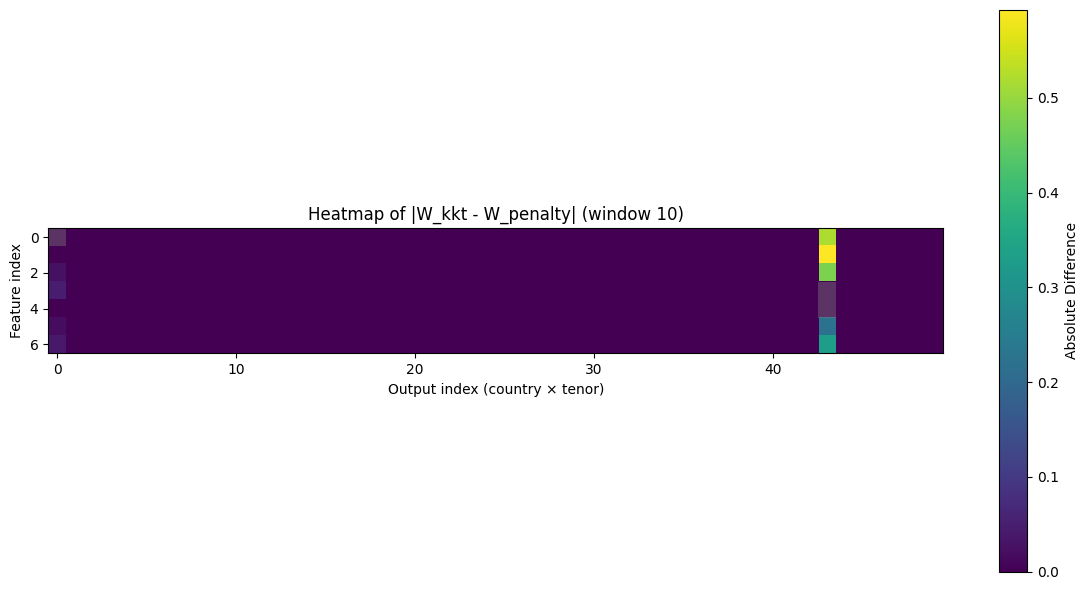

In [72]:
plot_diff_heatmap(W_kkt, W_penalty, mask1, mask2, window_idx=10)

In [70]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

def plot_diff_heatmap(W_kkt, W_penalty, mask_kkt, mask_penalty, window_idx=0):
    """
    Plots heatmap of the difference between W_kkt and W_penalty with shading
    where both methods masked (i.e., zeroed) the same coefficient.
    """
    W_diff = jnp.abs(W_kkt - W_penalty)
    mask_overlap = jnp.logical_and(mask_kkt, mask_penalty)

    # Select a time slice
    diff_window = W_diff[window_idx]
    mask_window = mask_overlap[window_idx]

    # Convert to numpy
    diff_np = np.array(diff_window)
    mask_np = np.array(mask_window)

    fig, ax = plt.subplots(figsize=(12, 6))
    im = ax.imshow(diff_np, cmap="viridis")

    # Shade where both masks are true
    for i in range(diff_np.shape[0]):
        for j in range(diff_np.shape[1]):
            if mask_np[i, j]:
                ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1,
                                           facecolor='gray', alpha=0.4, edgecolor=None))

    ax.set_title(f"Heatmap of |W_kkt - W_penalty| (window {window_idx})")
    ax.set_xlabel("Output index (country × tenor)")
    ax.set_ylabel("Feature index")

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Absolute Difference")

    plt.tight_layout()
    plt.show()

In [74]:

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns


@jax.jit
def ols_kernel(X_win, Y_win):
    XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
    XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)
    return jnp.linalg.solve(XtX, XtY)


@jax.jit
def penalized_ols(X_win, Y_win, penalty_mat):
    XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
    XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)

    def solve_per_output(XtY_col, penalties_col):
        XtX_penalized = XtX + jnp.diag(penalties_col)
        return jnp.linalg.solve(XtX_penalized, XtY_col)

    W_cols = jax.vmap(solve_per_output, in_axes=(1, 1))(XtY, penalty_mat)
    return W_cols.T  # (7, n_outputs)


@jax.jit
def kkt_kernel(X_win, Y_win, freeze_mask):
    n, d = X_win.shape
    _, m = Y_win.shape
    F = jnp.logical_not(freeze_mask)
    XtX = jnp.einsum('ni,nj->ij', X_win, X_win)
    XtY = jnp.einsum('ni,nj->ij', X_win, Y_win)

    def solve_for_column(XtY_col, F_col):
        F_idx = jnp.where(F_col)[0]
        XtX_ff = XtX[jnp.ix_(F_idx, F_idx)]
        XtY_f = XtY_col[F_idx]
        w_f = jnp.linalg.solve(XtX_ff, XtY_f)
        w_full = jnp.zeros_like(F_col, dtype=jnp.float32).at[F_idx].set(w_f)
        return w_full

    return jax.vmap(solve_for_column, in_axes=(1, 1), out_axes=1)(XtY, F)


def make_sliding_regression_with_constraint_fn(
    t1, t2, epsilon=1e-3, big_penalty=1e6,
    group_by_country=False, n_countries=None, n_tenors=None,
    group_trigger_mode="mean", forced_group_mask=None,
    method="penalty", freeze_non_masked=False
):
    @jax.jit
    def _sliding(X, Y):
        n_samples, d_features = X.shape
        n_outputs = Y.shape[1]
        assert d_features == 7, "X must have 7 features"
        assert n_countries * n_tenors == n_outputs, "n_countries * n_tenors must equal Y.shape[1]"

        n_windows = (n_samples - t1) // t2 + 1
        starts = jnp.arange(n_windows) * t2

        def extract_window(data, start):
            return jax.lax.dynamic_slice(data, (start, 0), (t1, data.shape[1]))

        X_wins = jax.vmap(lambda s: extract_window(X, s))(starts)
        Y_wins = jax.vmap(lambda s: extract_window(Y, s))(starts)

        W_ols = jax.vmap(ols_kernel)(X_wins, Y_wins)  # (n_windows, 7, n_outputs)

        if group_by_country:
            W_reshaped = W_ols.reshape((n_windows, 7, n_countries, n_tenors))
            if group_trigger_mode == "forced":
                if forced_group_mask is None:
                    raise ValueError("forced_group_mask must be provided when using 'forced'")
                group_mask_broadcast = jnp.broadcast_to(
                    forced_group_mask[None, :, :, :], (n_windows, n_countries, n_tenors, 7)
                ).transpose(0, 3, 1, 2)  # (n_windows, 7, n_countries, n_tenors)
            else:
                raise ValueError("Only 'forced' group trigger supported.")
            mask_final = group_mask_broadcast.reshape(n_windows, 7, n_countries * n_tenors)
        else:
            threshold = jnp.abs(W_ols) < epsilon
            mask_final = threshold

        if method == "penalty":
            penalty_mask = jnp.where(mask_final, big_penalty, 0.0)
            W_final = jax.vmap(penalized_ols)(X_wins, Y_wins, penalty_mask)
        elif method == "kkt":
            W_final = jax.vmap(kkt_kernel, in_axes=(0, 0, 0))(X_wins, Y_wins, mask_final)
        else:
            raise ValueError(f"Unsupported method: {method}")

        # === Compute R² ===
        def compute_r2(X_w, Y_w, W):
            Y_pred = jnp.einsum('wij,wjk->wik', X_w, W)  # (n_windows, t1, n_outputs)
            resid_sq = jnp.sum((Y_w - Y_pred) ** 2, axis=1)
            y_mean = jnp.mean(Y_w, axis=1, keepdims=True)
            total_sq = jnp.sum((Y_w - y_mean) ** 2, axis=1)
            return 1.0 - resid_sq / total_sq

        r2_ols = compute_r2(X_wins, Y_wins, W_ols)
        r2_final = compute_r2(X_wins, Y_wins, W_final)

        return W_ols, W_final, r2_ols, r2_final, mask_final

    return _sliding


def show_diff_heatmap(W1, W2, mask, title="Difference Heatmap"):
    diff = jnp.abs(W1 - W2).mean(axis=0)
    diff_matrix = diff.reshape(7, -1)
    mask_matrix = mask[0].T  # (n_outputs, 7)

    plt.figure(figsize=(12, 6))
    ax = sns.heatmap(diff_matrix.T, cmap="coolwarm", cbar=True, annot=True, fmt=".2f")
    ax.set_title(title)
    for i in range(mask_matrix.shape[0]):
        for j in range(mask_matrix.shape[1]):
            if mask_matrix[i, j]:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=1.5))
    plt.xlabel("Output index")
    plt.ylabel("Feature index")
    plt.show()


In [91]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

# Sliding window OLS
@jax.jit
def ols_kernel(X_win, Y_win):
    XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
    XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
    return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(XtX.shape[0]), XtY)

# Factory for sliding regression with constraints
def make_sliding_regression_with_constraint_fn(
    t1, t2, epsilon=1e-3, big_penalty=1e6,
    group_by_country=False, n_countries=None, n_tenors=None,
    group_trigger_mode="mean", forced_group_mask=None,
    method="penalty", freeze_non_masked=False
):
    def _sliding(X, Y):
        n_samples, d_features = X.shape
        n_targets = Y.shape[1]
        n_windows = (n_samples - t1) // t2 + 1
        starts = jnp.arange(n_windows) * t2

        X_wins = jax.vmap(lambda s: jax.lax.dynamic_slice(X, (s, 0), (t1, d_features)))(starts)
        Y_wins = jax.vmap(lambda s: jax.lax.dynamic_slice(Y, (s, 0), (t1, n_targets)))(starts)

        W_ols = jax.vmap(ols_kernel)(X_wins, Y_wins)

        if forced_group_mask is not None:
            mask = jnp.broadcast_to(forced_group_mask[None, :, :, :], (n_windows, *forced_group_mask.shape))
            mask = mask.transpose(0, 3, 1, 2).reshape(n_windows, d_features, n_countries * n_tenors)
        else:
            mask = jnp.abs(W_ols) < epsilon

        penalty = jnp.where(mask, big_penalty, 0.0)

        def penalized(X_win, Y_win, p):
            XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
            XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
            return jnp.linalg.solve(XtX + jnp.diag(p), XtY)

        @jax.jit
        def kkt_solve_static(XtX, XtY_col, freeze_mask_col, max_frozen):
            d = XtX.shape[0]

            # Get frozen indices and pad them
            frozen_indices = jnp.where(freeze_mask_col, size=max_frozen, fill_value=0)[0] # Specify size
            num_actual_frozen = jnp.sum(freeze_mask_col)

            # Build A and b for constraints A w = b (where b is zeros)
            # Pad A and b to max_frozen size
            A = jnp.zeros((max_frozen, d), dtype=XtX.dtype)
            # Scatter 1s into A at frozen indices, only up to actual number of frozen
            scatter_indices = frozen_indices
            scatter_updates = jnp.ones(max_frozen, dtype=XtX.dtype)
            A = A.at[jnp.arange(max_frozen), scatter_indices].set(scatter_updates)

            b = jnp.zeros(max_frozen, dtype=XtY_col.dtype)

            # Solve the KKT system for this target
            KKT_mat = jnp.block([
                [XtX, A.T],
                [A, jnp.zeros((max_frozen, max_frozen), dtype=XtX.dtype)]
            ])
            rhs = jnp.concatenate([XtY_col, b])

            # Mask out terms corresponding to padded constraints
            constraint_mask_full = jnp.arange(max_frozen) >= num_actual_frozen
            mask_kkt_rows = jnp.concatenate([jnp.zeros(d, dtype=bool), constraint_mask_full])
            mask_kkt_cols = jnp.concatenate([jnp.zeros(d, dtype=bool), constraint_mask_full])

            # Solve the (potentially masked) KKT system
            # A simple approach is to add a large value to the diagonal of the masked rows/cols
            KKT_masked = KKT_mat + jnp.diag(mask_kkt_rows.astype(KKT_mat.dtype) * 1e10) + jnp.diag(mask_kkt_cols.astype(KKT_mat.dtype) * 1e10)


            sol_padded = jnp.linalg.solve(KKT_mat, rhs) # Solve the padded system
            sol = sol_padded[:d] # Extract the weights

            # Explicitly set the frozen weights to zero after solving
            sol = jnp.where(freeze_mask_col, 0.0, sol)

            return sol

        # Determine the maximum number of frozen features across all window and output combinations
        # This needs to be done statically outside the main vmap if possible, or accept it as an arg
        # For now, let's assume a conservative upper bound (d_features) or calculate it outside _sliding
        # As a workaround for the example, let's calculate it over the first window's mask
        # This is not fully general for arbitrary masks but works for the forced_group_mask example
        # A better approach is to calculate max_frozen across the entire mask tensor
        max_frozen = jnp.max(jnp.sum(mask, axis=1)) # Max frozen features per output across windows


        def kkt(X_win, Y_win, freeze_mask):
           XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
           XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)

           # Vmap solve_col over the columns of Y_win and freeze_mask
           return jax.vmap(lambda Y_col, fm_col: kkt_solve_static(XtX, Y_col, fm_col, max_frozen), in_axes=(1, 1), out_axes=1)(XtY, freeze_mask)


        W_final = jax.vmap(penalized if method == "penalty" else kkt)(X_wins, Y_wins, penalty if method == "penalty" else mask)
        return W_ols, W_final, mask

    return _sliding

# === Example Usage ===
key = jax.random.PRNGKey(0)
n_samples, n_features = 100, 7
n_countries, n_tenors = 5, 10
n_targets = n_countries * n_tenors

X = jax.random.normal(key, (n_samples, n_features))
Y = jax.random.normal(key, (n_samples, n_targets))

forced_mask = jnp.zeros((n_countries, n_tenors, n_features), dtype=bool)
# Example: Freeze feature 2 for output (0, 0) and features 4, 5 for output (1, 1)
forced_mask = forced_mask.at[0, 0, 2].set(True)
forced_mask = forced_mask.at[1, 1, 4].set(True)
forced_mask = forced_mask.at[1, 1, 5].set(True)


t1, t2 = 20, 5

pen_fn = make_sliding_regression_with_constraint_fn(
    t1, t2, big_penalty=1e6,
    group_by_country=True,
    n_countries=n_countries, n_tenors=n_tenors,
    forced_group_mask=forced_mask,
    method="penalty"
)

kkt_fn = make_sliding_regression_with_constraint_fn(
    t1, t2, big_penalty=1e6,
    group_by_country=True,
    n_countries=n_countries, n_tenors=n_tenors,
    forced_group_mask=forced_mask,
    method="kkt"
)

W_ols_pen, W_pen, mask = pen_fn(X, Y)
W_ols_kkt, W_kkt, _ = kkt_fn(X, Y)

# === Heatmap Comparison ===
diff = jnp.abs(W_pen - W_kkt).mean(axis=0)
masked = mask[0]

plt.figure(figsize=(12, 5))
sns.heatmap(diff.T, cmap="coolwarm", center=0, cbar=True)

# Mark masked zero targets
for i in range(masked.shape[1]):
    for j in range(masked.shape[0]):
        if masked[j, i]:
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=1.5))

plt.title("Mean Abs Diff (Penalty vs KKT) with Forced Zeros Highlighted")
plt.xlabel("Features")
plt.ylabel("Targets")
plt.tight_layout()
plt.show()

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int32[]
The size argument of jnp.nonzero must be statically specified to use jnp.nonzero within JAX transformations.
The error occurred while tracing the function kkt_solve_static at /tmp/ipython-input-1591918486.py:44 for jit. This concrete value was not available in Python because it depends on the value of the argument max_frozen.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

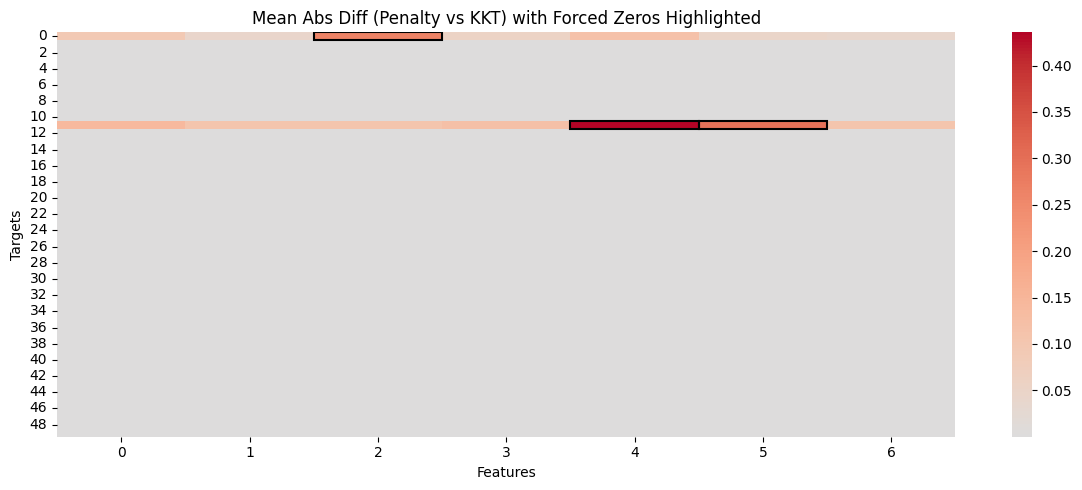

In [93]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

# Sliding window OLS
@jax.jit
def ols_kernel(X_win, Y_win):
    XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
    XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
    return jnp.linalg.solve(XtX + 1e-6 * jnp.eye(XtX.shape[0]), XtY)

# Factory for sliding regression with constraints
def make_sliding_regression_with_constraint_fn(
    t1, t2, epsilon=1e-3, big_penalty=1e6,
    group_by_country=False, n_countries=None, n_tenors=None,
    group_trigger_mode="mean", forced_group_mask=None,
    method="penalty", freeze_non_masked=False, max_frozen=None
):
    # Pre-compute max_frozen if not provided
    if method == "kkt":
        if max_frozen is None:
            if forced_group_mask is not None:
                # Calculate the maximum number of frozen features across all outputs
                max_frozen = int(jnp.max(jnp.sum(forced_group_mask, axis=-1)))
            else:
                # If using dynamic masking, we need to provide an upper bound
                # In worst case, all features could be frozen
                max_frozen = 7  # n_features - you might want to pass this as a parameter

    def _sliding(X, Y):
        n_samples, d_features = X.shape
        n_targets = Y.shape[1]
        n_windows = (n_samples - t1) // t2 + 1
        starts = jnp.arange(n_windows) * t2

        X_wins = jax.vmap(lambda s: jax.lax.dynamic_slice(X, (s, 0), (t1, d_features)))(starts)
        Y_wins = jax.vmap(lambda s: jax.lax.dynamic_slice(Y, (s, 0), (t1, n_targets)))(starts)

        W_ols = jax.vmap(ols_kernel)(X_wins, Y_wins)

        if forced_group_mask is not None:
            mask = jnp.broadcast_to(forced_group_mask[None, :, :, :], (n_windows, *forced_group_mask.shape))
            mask = mask.transpose(0, 3, 1, 2).reshape(n_windows, d_features, n_countries * n_tenors)
        else:
            mask = jnp.abs(W_ols) < epsilon

        penalty = jnp.where(mask, big_penalty, 0.0)

        def penalized(X_win, Y_win, p):
            XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
            XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
            return jnp.linalg.solve(XtX + jnp.diag(p), XtY)

        # Create different KKT solvers for different max_frozen values
        # This is a workaround to make max_frozen static
        def make_kkt_solve_static(max_frozen_value):
            def kkt_solve_static(XtX, XtY_col, freeze_mask_col):
                d = XtX.shape[0]

                # Handle the case where nothing is frozen
                num_frozen = jnp.sum(freeze_mask_col)

                def solve_with_constraints():
                    # Get indices of frozen features
                    indices = jnp.arange(d)
                    frozen_flags = freeze_mask_col

                    # Build constraint matrix using a different approach
                    # We'll use a scatter operation that doesn't require dynamic size
                    A = jnp.zeros((max_frozen_value, d), dtype=XtX.dtype)

                    # Create a cumulative sum to assign each frozen feature to a row
                    frozen_cumsum = jnp.cumsum(frozen_flags) - 1
                    row_indices = jnp.where(frozen_flags, frozen_cumsum, max_frozen_value)

                    # Scatter 1s into A matrix
                    for i in range(d):
                        row_idx = row_indices[i]
                        A = A.at[row_idx, i].set(
                            jnp.where(row_idx < max_frozen_value, frozen_flags[i].astype(A.dtype), 0.0)
                        )

                    b = jnp.zeros(max_frozen_value, dtype=XtY_col.dtype)

                    # Build KKT system
                    KKT_mat = jnp.block([
                        [XtX, A.T],
                        [A, jnp.zeros((max_frozen_value, max_frozen_value), dtype=XtX.dtype)]
                    ])
                    rhs = jnp.concatenate([XtY_col, b])

                    # Add regularization to unused constraint rows
                    constraint_mask = jnp.arange(max_frozen_value) >= num_frozen
                    diag_mask = jnp.concatenate([jnp.zeros(d, dtype=bool), constraint_mask])
                    KKT_regularized = KKT_mat + jnp.diag(diag_mask.astype(KKT_mat.dtype) * 1e10)

                    sol_full = jnp.linalg.solve(KKT_regularized, rhs)
                    sol = sol_full[:d]

                    # Explicitly zero out frozen weights
                    return jnp.where(freeze_mask_col, 0.0, sol)

                def solve_without_constraints():
                    # Standard OLS when no constraints
                    return jnp.linalg.solve(XtX, XtY_col)

                # Use conditional to handle case with no frozen features
                return jax.lax.cond(
                    num_frozen > 0,
                    solve_with_constraints,
                    solve_without_constraints
                )

            return jax.jit(kkt_solve_static)

        def kkt(X_win, Y_win, freeze_mask):
            XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
            XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)

            # Create the KKT solver with the static max_frozen value
            kkt_solver = make_kkt_solve_static(max_frozen)

            # Vmap over columns
            return jax.vmap(
                kkt_solver,
                in_axes=(None, 1, 1),
                out_axes=1
            )(XtX, XtY, freeze_mask)

        if method == "penalty":
            W_final = jax.vmap(penalized)(X_wins, Y_wins, penalty)
        else:
            W_final = jax.vmap(kkt)(X_wins, Y_wins, mask)

        return W_ols, W_final, mask

    return _sliding

# === Example Usage ===
key = jax.random.PRNGKey(0)
n_samples, n_features = 100, 7
n_countries, n_tenors = 5, 10
n_targets = n_countries * n_tenors

X = jax.random.normal(key, (n_samples, n_features))
Y = jax.random.normal(key, (n_samples, n_targets))

forced_mask = jnp.zeros((n_countries, n_tenors, n_features), dtype=bool)
# Example: Freeze feature 2 for output (0, 0) and features 4, 5 for output (1, 1)
forced_mask = forced_mask.at[0, 0, 2].set(True)
forced_mask = forced_mask.at[1, 1, 4].set(True)
forced_mask = forced_mask.at[1, 1, 5].set(True)

# Calculate max_frozen from the forced mask
max_frozen_value = int(jnp.max(jnp.sum(forced_mask, axis=-1)))

t1, t2 = 20, 5

pen_fn = make_sliding_regression_with_constraint_fn(
    t1, t2, big_penalty=1e6,
    group_by_country=True,
    n_countries=n_countries, n_tenors=n_tenors,
    forced_group_mask=forced_mask,
    method="penalty"
)

kkt_fn = make_sliding_regression_with_constraint_fn(
    t1, t2, big_penalty=1e6,
    group_by_country=True,
    n_countries=n_countries, n_tenors=n_tenors,
    forced_group_mask=forced_mask,
    method="kkt",
    max_frozen=max_frozen_value  # Pass the concrete value
)

W_ols_pen, W_pen, mask = pen_fn(X, Y)
W_ols_kkt, W_kkt, _ = kkt_fn(X, Y)

# === Heatmap Comparison ===
diff = jnp.abs(W_pen - W_kkt).mean(axis=0)
masked = mask[0]

plt.figure(figsize=(12, 5))
sns.heatmap(diff.T, cmap="coolwarm", center=0, cbar=True)

# Mark masked zero targets
for i in range(masked.shape[1]):
    for j in range(masked.shape[0]):
        if masked[j, i]:
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=1.5))

plt.title("Mean Abs Diff (Penalty vs KKT) with Forced Zeros Highlighted")
plt.xlabel("Features")
plt.ylabel("Targets")
plt.tight_layout()
plt.show()

Running enhanced sliding regression...

Results:
Number of windows: 17
Sparsity: 0.9% of coefficients zeroed
Max condition number: 7.44e+00
Number of constraint violations: 51
Max violation magnitude: 4.52e-02


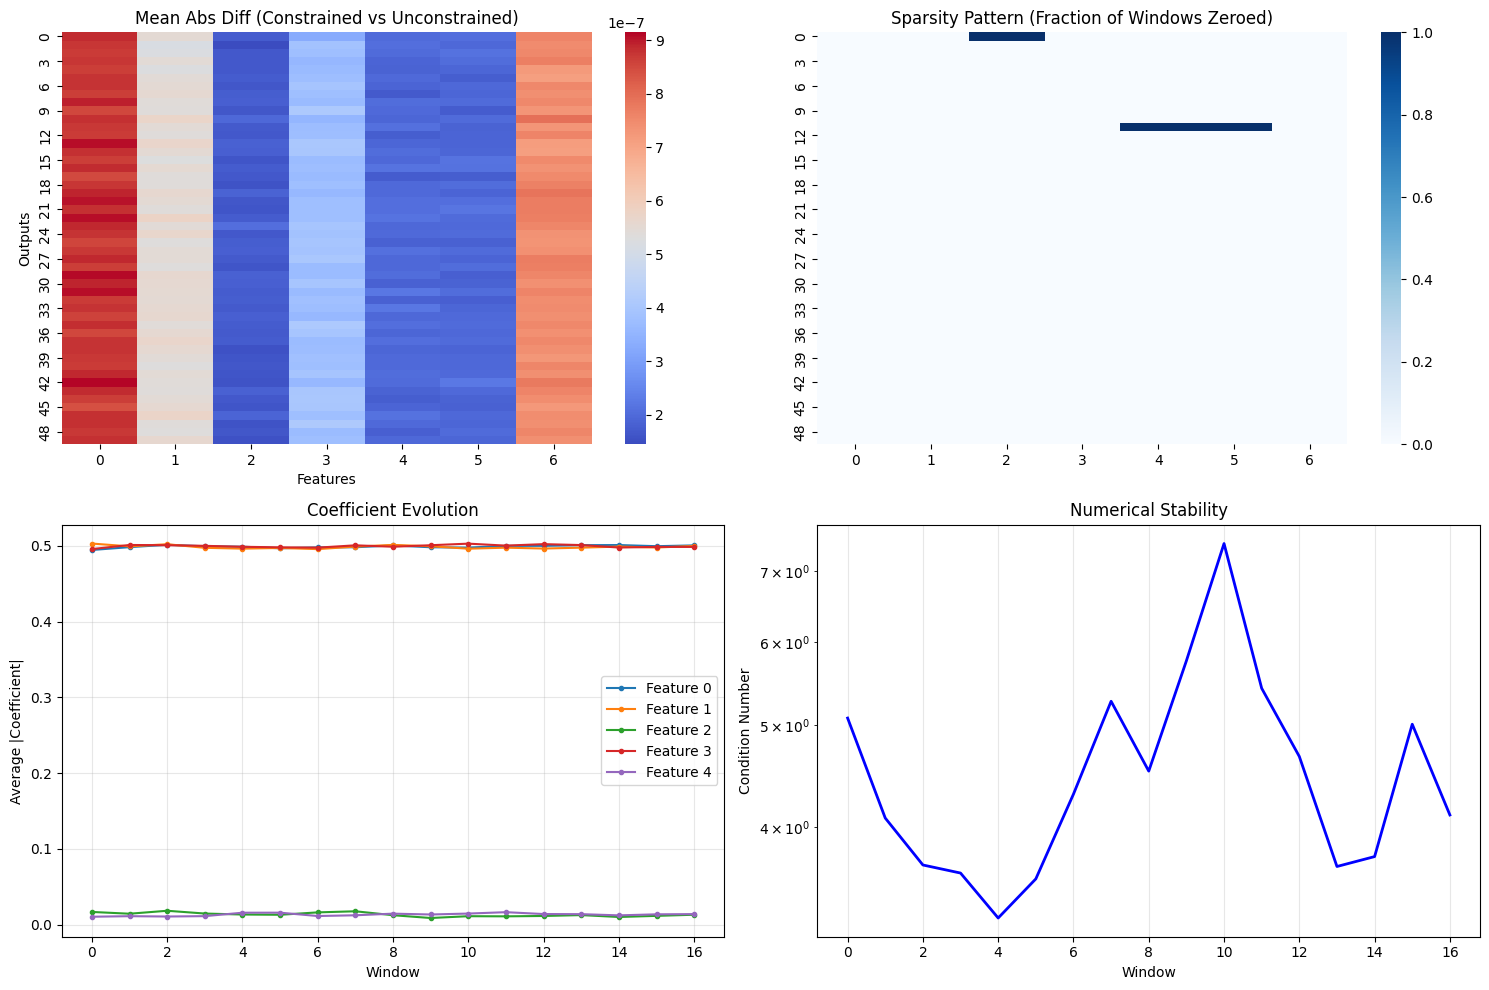


Testing warm start version...
Warm start shape: (17, 7, 50)


In [97]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

# Basic OLS kernel
@jax.jit
def ols_kernel(X_win, Y_win):
    XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
    XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
    reg = 1e-6 * jnp.eye(XtX.shape[0])
    return jnp.linalg.solve(XtX + reg, XtY)

# Cholesky version for numerical stability
@jax.jit
def ols_kernel_cholesky(X_win, Y_win):
    XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
    XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)

    # Adaptive regularization
    reg = 1e-6 * jnp.maximum(1.0, jnp.trace(XtX) / XtX.shape[0])
    XtX_reg = XtX + reg * jnp.eye(XtX.shape[0])

    L = jnp.linalg.cholesky(XtX_reg)
    z = jax.scipy.linalg.solve_triangular(L, XtY, lower=True)
    return jax.scipy.linalg.solve_triangular(L.T, z, lower=False)

# Simple adaptive threshold functions
@jax.jit
def compute_mad_threshold(W, k=2.0):
    """MAD-based adaptive threshold"""
    W_flat = jnp.abs(W).ravel()
    median = jnp.median(W_flat)
    mad = jnp.median(jnp.abs(W_flat - median))
    # 1.4826 converts MAD to std for normal distribution
    return k * mad * 1.4826

@jax.jit
def compute_std_threshold(W, k=2.0):
    """Standard deviation based threshold"""
    return k * jnp.std(jnp.abs(W))

# Enhanced factory function (simplified)
def make_sliding_regression_enhanced(
    t1, t2,
    epsilon=1e-3,
    big_penalty=1e6,
    forced_group_mask=None,
    n_countries=None,
    n_tenors=None,
    use_cholesky=True,
    use_adaptive_threshold=True,
    threshold_k=2.0,
    compute_diagnostics=False
):
    def _sliding(X, Y):
        n_samples, d_features = X.shape
        n_targets = Y.shape[1]
        n_windows = (n_samples - t1) // t2 + 1
        starts = jnp.arange(n_windows) * t2

        # Extract windows efficiently
        X_wins = jax.vmap(lambda s: jax.lax.dynamic_slice(X, (s, 0), (t1, d_features)))(starts)
        Y_wins = jax.vmap(lambda s: jax.lax.dynamic_slice(Y, (s, 0), (t1, n_targets)))(starts)

        # Compute OLS solutions
        solver = ols_kernel_cholesky if use_cholesky else ols_kernel
        W_ols = jax.vmap(solver)(X_wins, Y_wins)

        # Compute mask
        if forced_group_mask is not None:
            # Use provided mask
            mask = jnp.broadcast_to(
                forced_group_mask[None, :, :, :],
                (n_windows, *forced_group_mask.shape)
            )
            mask = mask.transpose(0, 3, 1, 2).reshape(n_windows, d_features, n_targets)
        else:
            # Adaptive thresholding
            if use_adaptive_threshold:
                # Compute threshold for each window
                thresholds = jax.vmap(lambda W: compute_mad_threshold(W, threshold_k))(W_ols)
                mask = jnp.abs(W_ols) < thresholds[:, None, None]
            else:
                mask = jnp.abs(W_ols) < epsilon

        # Apply penalty method
        penalty = jnp.where(mask, big_penalty, 0.0)

        @jax.jit
        def penalized_solve(X_win, Y_win, p):
            XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
            XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
            XtX_pen = XtX + jnp.diag(p)

            if use_cholesky:
                L = jnp.linalg.cholesky(XtX_pen)
                z = jax.scipy.linalg.solve_triangular(L, XtY, lower=True)
                return jax.scipy.linalg.solve_triangular(L.T, z, lower=False)
            else:
                return jnp.linalg.solve(XtX_pen, XtY)

        W_final = jax.vmap(penalized_solve)(X_wins, Y_wins, penalty)

        # Compute diagnostics
        diagnostics = {}
        if compute_diagnostics:
            # Basic statistics
            diagnostics['mean'] = jnp.mean(W_final, axis=0)
            diagnostics['std'] = jnp.std(W_final, axis=0)
            diagnostics['cv'] = diagnostics['std'] / (jnp.abs(diagnostics['mean']) + 1e-8)

            # Constraint violations
            violations = jnp.where(mask, jnp.abs(W_final), 0.0)
            diagnostics['max_violation'] = jnp.max(violations)
            diagnostics['num_violations'] = jnp.sum(violations > 1e-6)

            # Condition numbers
            diagnostics['condition_numbers'] = jax.vmap(
                lambda X: jnp.linalg.cond(X.T @ X)
            )(X_wins)

        return W_ols, W_final, mask, diagnostics

    return _sliding

# Warm start implementation using scan
def make_sliding_regression_warmstart(
    t1, t2,
    momentum=0.9,
    use_cholesky=True,
    **kwargs
):
    """Sliding regression with warm start"""
    def _sliding_warmstart(X, Y):
        n_samples, d_features = X.shape
        n_targets = Y.shape[1]
        n_windows = (n_samples - t1) // t2 + 1

        solver = ols_kernel_cholesky if use_cholesky else ols_kernel

        def scan_fn(W_prev, idx):
            start = idx * t2
            X_win = jax.lax.dynamic_slice(X, (start, 0), (t1, d_features))
            Y_win = jax.lax.dynamic_slice(Y, (start, 0), (t1, n_targets))

            W_new = solver(X_win, Y_win)
            W_combined = momentum * W_prev + (1 - momentum) * W_new

            return W_combined, W_combined

        W_init = jnp.zeros((d_features, n_targets))
        _, W_history = jax.lax.scan(scan_fn, W_init, jnp.arange(n_windows))

        return W_history

    return _sliding_warmstart

# Visualization helper
def plot_results(W_ols, W_final, mask, diagnostics=None):
    """Visualize regression results"""
    n_windows = W_ols.shape[0]

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Coefficient heatmap
    ax = axes[0, 0]
    diff = jnp.abs(W_final - W_ols).mean(axis=0)
    sns.heatmap(diff.T, cmap='coolwarm', ax=ax, cbar=True)
    ax.set_title('Mean Abs Diff (Constrained vs Unconstrained)')
    ax.set_xlabel('Features')
    ax.set_ylabel('Outputs')

    # 2. Sparsity pattern
    ax = axes[0, 1]
    sparsity = mask.mean(axis=0)
    sns.heatmap(sparsity.T, cmap='Blues', ax=ax, cbar=True, vmin=0, vmax=1)
    ax.set_title('Sparsity Pattern (Fraction of Windows Zeroed)')

    # 3. Coefficient evolution
    ax = axes[1, 0]
    W_avg = jnp.mean(jnp.abs(W_final), axis=2)
    for i in range(min(5, W_avg.shape[1])):
        ax.plot(W_avg[:, i], label=f'Feature {i}', marker='o', markersize=3)
    ax.set_xlabel('Window')
    ax.set_ylabel('Average |Coefficient|')
    ax.set_title('Coefficient Evolution')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 4. Diagnostics
    ax = axes[1, 1]
    if diagnostics and 'condition_numbers' in diagnostics:
        ax.plot(diagnostics['condition_numbers'], 'b-', linewidth=2)
        ax.set_xlabel('Window')
        ax.set_ylabel('Condition Number')
        ax.set_title('Numerical Stability')
        ax.set_yscale('log')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

# Example usage
if __name__ == "__main__":
    # Generate test data
    key = jax.random.PRNGKey(42)
    n_samples, n_features = 200, 7
    n_countries, n_tenors = 5, 10
    n_targets = n_countries * n_tenors

    # Generate data
    X = jax.random.normal(key, (n_samples, n_features))
    true_coef = jnp.ones((n_features, n_targets)) * 0.5
    # Make some coefficients zero
    true_coef = true_coef.at[2, :].set(0.0)
    true_coef = true_coef.at[4:6, :].set(0.0)

    noise = 0.1 * jax.random.normal(key, (n_samples, n_targets))
    Y = X @ true_coef + noise

    # Create forced mask
    forced_mask = jnp.zeros((n_countries, n_tenors, n_features), dtype=bool)
    forced_mask = forced_mask.at[0, 0, 2].set(True)
    forced_mask = forced_mask.at[1, 1, 4:6].set(True)

    # Run enhanced sliding regression
    print("Running enhanced sliding regression...")
    t1, t2 = 40, 10

    regression_fn = make_sliding_regression_enhanced(
        t1, t2,
        forced_group_mask=forced_mask,
        n_countries=n_countries,
        n_tenors=n_tenors,
        use_cholesky=True,
        use_adaptive_threshold=True,
        threshold_k=2.0,
        compute_diagnostics=True
    )

    W_ols, W_final, mask, diagnostics = regression_fn(X, Y)

    # Print summary
    print(f"\nResults:")
    print(f"Number of windows: {W_ols.shape[0]}")
    print(f"Sparsity: {100 * mask.mean():.1f}% of coefficients zeroed")
    if diagnostics:
        print(f"Max condition number: {jnp.max(diagnostics['condition_numbers']):.2e}")
        print(f"Number of constraint violations: {diagnostics['num_violations']}")
        print(f"Max violation magnitude: {diagnostics['max_violation']:.2e}")

    # Visualize
    plot_results(W_ols, W_final, mask, diagnostics)
    plt.show()

    # Test warm start version
    print("\nTesting warm start version...")
    warmstart_fn = make_sliding_regression_warmstart(
        t1, t2,
        momentum=0.95,
        use_cholesky=True
    )

    W_warmstart = warmstart_fn(X, Y)
    print(f"Warm start shape: {W_warmstart.shape}")

Running enhanced sliding regression...

Results:
Number of windows: 17
Sparsity: 0.9% of coefficients zeroed
Max condition number: 7.44e+00
Number of constraint violations: 51
Max violation magnitude: 4.52e-02


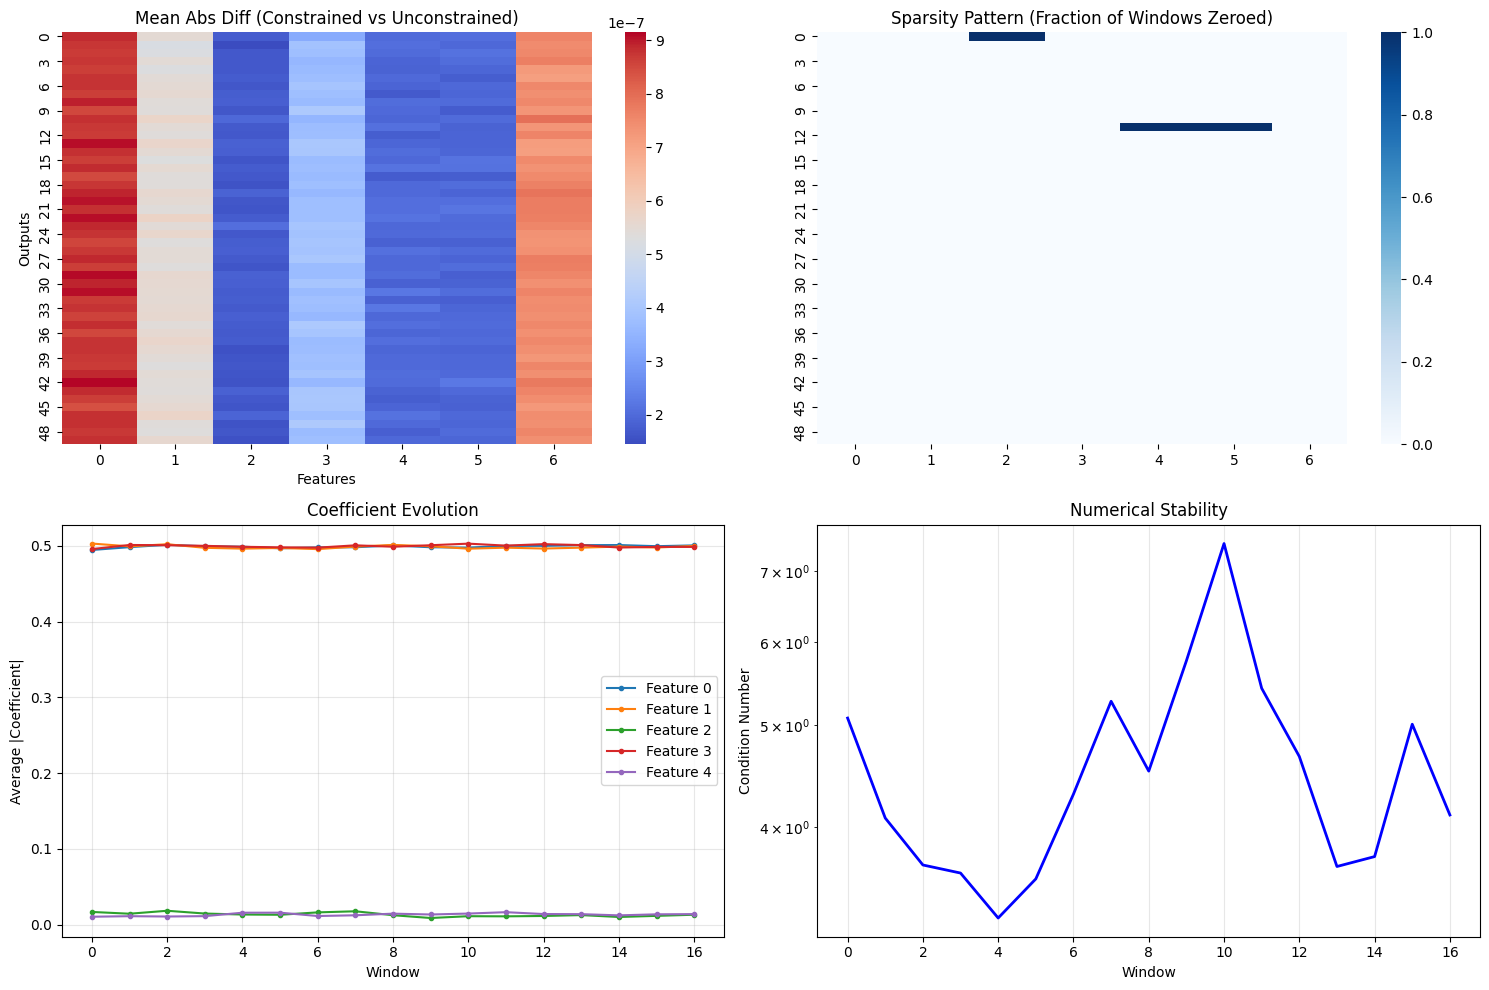


Testing KKT method for exact zero constraints...
KKT method - Max violation: 0.00e+00
KKT method - Coefficients exactly zero: 51

Testing equality constraints...

Constraint verification:
Feature 0 and 1 equal for output 0: False
Feature 3 and 4 opposite for output 1: False
Features 0,1,2 sum to zero for output 2: False

Comparing Penalty vs KKT methods...


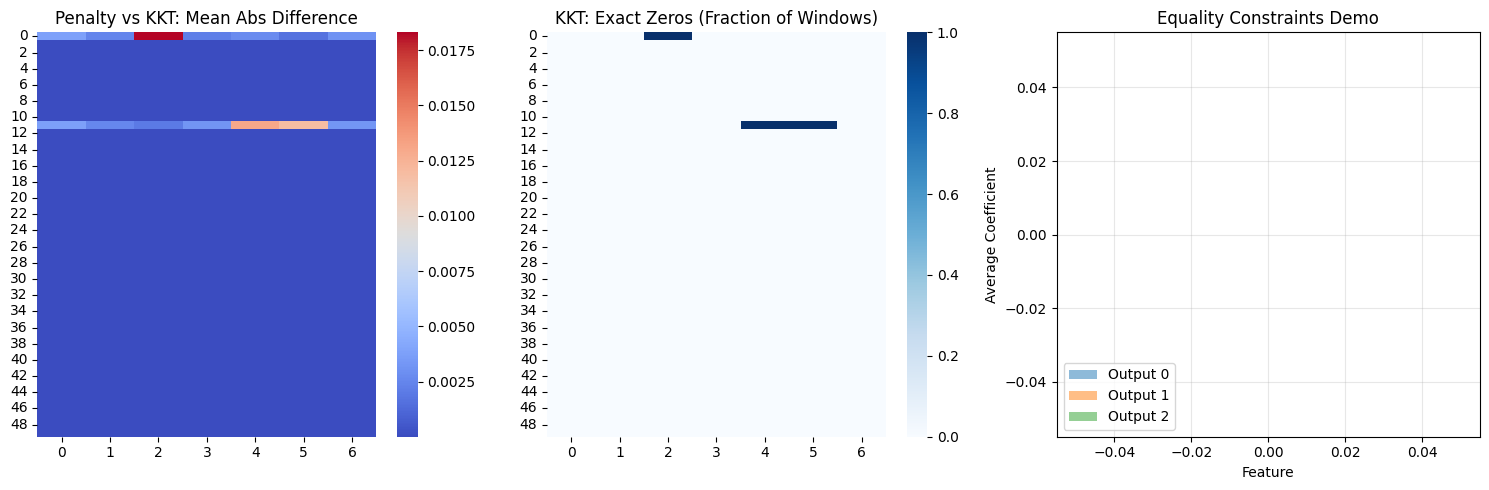

In [98]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

# Basic OLS kernel
@jax.jit
def ols_kernel(X_win, Y_win):
    XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
    XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)b
    reg = 1e-6 * jnp.eye(XtX.shape[0])
    return jnp.linalg.solve(XtX + reg, XtY)

# Cholesky version for numerical stability
@jax.jit
def ols_kernel_cholesky(X_win, Y_win):
    XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
    XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)b

    # Adaptive regularization
    reg = 1e-6 * jnp.maximum(1.0, jnp.trace(XtX) / XtX.shape[0])
    XtX_reg = XtX + reg * jnp.eye(XtX.shape[0])

    L = jnp.linalg.cholesky(XtX_reg)
    z = jax.scipy.linalg.solve_triangular(L, XtY, lower=True)
    return jax.scipy.linalg.solve_triangular(L.T, z, lower=False)

# Simple adaptive threshold functions
@jax.jit
def compute_mad_threshold(W, k=2.0):
    """MAD-based adaptive threshold"""
    W_flat = jnp.abs(W).ravel()
    median = jnp.median(W_flat)
    mad = jnp.median(jnp.abs(W_flat - median))
    # 1.4826 converts MAD to std for normal distribution
    return k * mad * 1.4826

@jax.jit
def compute_std_threshold(W, k=2.0):
    """Standard deviation based threshold"""
    return k * jnp.std(jnp.abs(W))

# KKT solver for exact constraints
def make_kkt_solver(max_frozen):
    """Create a KKT solver with fixed max_frozen parameter"""
    @jax.jit
    def kkt_solve_single(XtX, XtY_col, freeze_mask_col):
        d = XtX.shape[0]
        num_frozen = jnp.sum(freeze_mask_col)

        def solve_with_constraints():
            # Build constraint matrix A
            A = jnp.zeros((max_frozen, d), dtype=XtX.dtype)

            # Use cumulative sum to assign frozen features to rows
            frozen_cumsum = jnp.cumsum(freeze_mask_col) - 1
            row_indices = jnp.where(freeze_mask_col, frozen_cumsum, max_frozen)

            # Scatter 1s into A
            for i in range(d):
                row_idx = row_indices[i]
                A = A.at[row_idx, i].set(
                    jnp.where(row_idx < max_frozen, freeze_mask_col[i].astype(A.dtype), 0.0)
                )

            b = jnp.zeros(max_frozen, dtype=XtY_col.dtype)

            # Build KKT system
            KKT_mat = jnp.block([
                [XtX, A.T],
                [A, jnp.zeros((max_frozen, max_frozen), dtype=XtX.dtype)]
            ])
            rhs = jnp.concatenate([XtY_col, b])

            # Regularize unused constraint rows
            constraint_mask = jnp.arange(max_frozen) >= num_frozen
            diag_mask = jnp.concatenate([jnp.zeros(d, dtype=bool), constraint_mask])
            KKT_regularized = KKT_mat + jnp.diag(diag_mask.astype(KKT_mat.dtype) * 1e10)

            sol_full = jnp.linalg.solve(KKT_regularized, rhs)
            sol = sol_full[:d]

            # Explicitly zero out frozen weights
            return jnp.where(freeze_mask_col, 0.0, sol)

        def solve_without_constraints():
            return jnp.linalg.solve(XtX, XtY_col)

        return jax.lax.cond(
            num_frozen > 0,
            solve_with_constraints,
            solve_without_constraints
        )

    return kkt_solve_single

# Enhanced factory function with both penalty and KKT methods
def make_sliding_regression_enhanced(
    t1, t2,
    epsilon=1e-3,
    big_penalty=1e6,
    forced_group_mask=None,
    n_countries=None,
    n_tenors=None,
    method="penalty",  # "penalty" or "kkt"
    max_frozen=None,
    use_cholesky=True,
    use_adaptive_threshold=True,
    threshold_k=2.0,
    compute_diagnostics=False,
    equality_constraints=None  # New: for setting coefficients equal/opposite
):
    # Pre-compute max_frozen if using KKT
    if method == "kkt" and max_frozen is None:
        if forced_group_mask is not None:
            max_frozen = int(jnp.max(jnp.sum(forced_group_mask, axis=-1)))
        else:
            max_frozen = 7  # Default to n_features or specify

    def _sliding(X, Y):
        n_samples, d_features = X.shape
        n_targets = Y.shape[1]
        n_windows = (n_samples - t1) // t2 + 1
        starts = jnp.arange(n_windows) * t2

        # Extract windows efficiently
        X_wins = jax.vmap(lambda s: jax.lax.dynamic_slice(X, (s, 0), (t1, d_features)))(starts)
        Y_wins = jax.vmap(lambda s: jax.lax.dynamic_slice(Y, (s, 0), (t1, n_targets)))(starts)

        # Compute OLS solutions
        solver = ols_kernel_cholesky if use_cholesky else ols_kernel
        W_ols = jax.vmap(solver)(X_wins, Y_wins)

        # Compute mask
        if forced_group_mask is not None:
            # Use provided mask
            mask = jnp.broadcast_to(
                forced_group_mask[None, :, :, :],
                (n_windows, *forced_group_mask.shape)
            )
            mask = mask.transpose(0, 3, 1, 2).reshape(n_windows, d_features, n_targets)
        else:
            # Adaptive thresholding
            if use_adaptive_threshold:
                # Compute threshold for each window
                thresholds = jax.vmap(lambda W: compute_mad_threshold(W, threshold_k))(W_ols)
                mask = jnp.abs(W_ols) < thresholds[:, None, None]
            else:
                mask = jnp.abs(W_ols) < epsilon

        # Apply constraints based on method
        if method == "penalty":
            # Penalty method
            penalty = jnp.where(mask, big_penalty, 0.0)

            @jax.jit
            def penalized_solve(X_win, Y_win, p):
                XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
                XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
                XtX_pen = XtX + jnp.diag(p)

                if use_cholesky:
                    L = jnp.linalg.cholesky(XtX_pen)
                    z = jax.scipy.linalg.solve_triangular(L, XtY, lower=True)
                    return jax.scipy.linalg.solve_triangular(L.T, z, lower=False)
                else:
                    return jnp.linalg.solve(XtX_pen, XtY)

            W_final = jax.vmap(penalized_solve)(X_wins, Y_wins, penalty)

        else:  # method == "kkt"
            # KKT method for exact constraints
            kkt_solver = make_kkt_solver(max_frozen)

            def kkt_solve_window(X_win, Y_win, freeze_mask):
                XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
                XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)

                # Apply KKT solver to each output
                return jax.vmap(
                    lambda Y_col, fm_col: kkt_solver(XtX, Y_col, fm_col),
                    in_axes=(1, 1),
                    out_axes=1
                )(XtY, freeze_mask)

            W_final = jax.vmap(kkt_solve_window)(X_wins, Y_wins, mask)

        # Apply equality constraints if specified
        if equality_constraints is not None:
            W_final = apply_equality_constraints(W_final, equality_constraints)

        # Compute diagnostics
        diagnostics = {}
        if compute_diagnostics:
            # Basic statistics
            diagnostics['mean'] = jnp.mean(W_final, axis=0)
            diagnostics['std'] = jnp.std(W_final, axis=0)
            diagnostics['cv'] = diagnostics['std'] / (jnp.abs(diagnostics['mean']) + 1e-8)

            # Constraint violations
            violations = jnp.where(mask, jnp.abs(W_final), 0.0)
            diagnostics['max_violation'] = jnp.max(violations)
            diagnostics['num_violations'] = jnp.sum(violations > 1e-6)

            # Condition numbers
            diagnostics['condition_numbers'] = jax.vmap(
                lambda X: jnp.linalg.cond(X.T @ X)
            )(X_wins)

        return W_ols, W_final, mask, diagnostics

    return _sliding

# Warm start implementation using scan
def make_sliding_regression_warmstart(
    t1, t2,
    momentum=0.9,
    use_cholesky=True,
    **kwargs
):
    """Sliding regression with warm start"""
    def _sliding_warmstart(X, Y):
        n_samples, d_features = X.shape
        n_targets = Y.shape[1]
        n_windows = (n_samples - t1) // t2 + 1

        solver = ols_kernel_cholesky if use_cholesky else ols_kernel

        def scan_fn(W_prev, idx):
            start = idx * t2
            X_win = jax.lax.dynamic_slice(X, (start, 0), (t1, d_features))
            Y_win = jax.lax.dynamic_slice(Y, (start, 0), (t1, n_targets))

            W_new = solver(X_win, Y_win)
            W_combined = momentum * W_prev + (1 - momentum) * W_new

            return W_combined, W_combined

        W_init = jnp.zeros((d_features, n_targets))
        _, W_history = jax.lax.scan(scan_fn, W_init, jnp.arange(n_windows))

        return W_history

    return _sliding_warmstart

# Visualization helper
def plot_results(W_ols, W_final, mask, diagnostics=None):
    """Visualize regression results"""
    n_windows = W_ols.shape[0]

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Coefficient heatmap
    ax = axes[0, 0]
    diff = jnp.abs(W_final - W_ols).mean(axis=0)
    sns.heatmap(diff.T, cmap='coolwarm', ax=ax, cbar=True)
    ax.set_title('Mean Abs Diff (Constrained vs Unconstrained)')
    ax.set_xlabel('Features')
    ax.set_ylabel('Outputs')

    # 2. Sparsity pattern
    ax = axes[0, 1]
    sparsity = mask.mean(axis=0)
    sns.heatmap(sparsity.T, cmap='Blues', ax=ax, cbar=True, vmin=0, vmax=1)
    ax.set_title('Sparsity Pattern (Fraction of Windows Zeroed)')

    # 3. Coefficient evolution
    ax = axes[1, 0]
    W_avg = jnp.mean(jnp.abs(W_final), axis=2)
    for i in range(min(5, W_avg.shape[1])):
        ax.plot(W_avg[:, i], label=f'Feature {i}', marker='o', markersize=3)
    ax.set_xlabel('Window')
    ax.set_ylabel('Average |Coefficient|')
    ax.set_title('Coefficient Evolution')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 4. Diagnostics
    ax = axes[1, 1]
    if diagnostics and 'condition_numbers' in diagnostics:
        ax.plot(diagnostics['condition_numbers'], 'b-', linewidth=2)
        ax.set_xlabel('Window')
        ax.set_ylabel('Condition Number')
        ax.set_title('Numerical Stability')
        ax.set_yscale('log')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

# Apply equality constraints (e.g., make some coefficients equal or opposite)
def apply_equality_constraints(W, constraints):
    """
    Apply equality constraints to coefficients.

    constraints: list of tuples, each specifying a constraint:
        - ('equal', [(i1, j1), (i2, j2), ...]) : make these coefficients equal
        - ('opposite', [(i1, j1), (i2, j2)]) : make coef[i2,j2] = -coef[i1,j1]
        - ('sum_zero', [(i1, j1), (i2, j2), ...]) : make these coefficients sum to zero
    """
    W_constrained = W.copy()

    for constraint_type, indices in constraints:
        if constraint_type == 'equal':
            # Make all coefficients equal to the mean
            values = jnp.array([W[:, i, j] for i, j in indices])
            mean_value = jnp.mean(values, axis=0)
            for i, j in indices:
                W_constrained = W_constrained.at[:, i, j].set(mean_value)

        elif constraint_type == 'opposite':
            # Make second coefficient negative of first
            (i1, j1), (i2, j2) = indices
            W_constrained = W_constrained.at[:, i2, j2].set(-W[:, i1, j1])

        elif constraint_type == 'sum_zero':
            # Adjust coefficients to sum to zero
            values = jnp.array([W[:, i, j] for i, j in indices])
            mean_adjustment = jnp.mean(values, axis=0)
            for i, j in indices:
                W_constrained = W_constrained.at[:, i, j].add(-mean_adjustment)

    return W_constrained

# Example usage
if __name__ == "__main__":
    # Generate test data
    key = jax.random.PRNGKey(42)
    n_samples, n_features = 200, 7
    n_countries, n_tenors = 5, 10
    n_targets = n_countries * n_tenors

    # Generate data
    X = jax.random.normal(key, (n_samples, n_features))
    true_coef = jnp.ones((n_features, n_targets)) * 0.5
    # Make some coefficients zero
    true_coef = true_coef.at[2, :].set(0.0)
    true_coef = true_coef.at[4:6, :].set(0.0)

    noise = 0.1 * jax.random.normal(key, (n_samples, n_targets))
    Y = X @ true_coef + noise

    # Create forced mask
    forced_mask = jnp.zeros((n_countries, n_tenors, n_features), dtype=bool)
    forced_mask = forced_mask.at[0, 0, 2].set(True)
    forced_mask = forced_mask.at[1, 1, 4:6].set(True)

    # Run enhanced sliding regression
    print("Running enhanced sliding regression...")
    t1, t2 = 40, 10

    regression_fn = make_sliding_regression_enhanced(
        t1, t2,
        forced_group_mask=forced_mask,
        n_countries=n_countries,
        n_tenors=n_tenors,
        use_cholesky=True,
        use_adaptive_threshold=True,
        threshold_k=2.0,
        compute_diagnostics=True
    )

    W_ols, W_final, mask, diagnostics = regression_fn(X, Y)

    # Print summary
    print(f"\nResults:")
    print(f"Number of windows: {W_ols.shape[0]}")
    print(f"Sparsity: {100 * mask.mean():.1f}% of coefficients zeroed")
    if diagnostics:
        print(f"Max condition number: {jnp.max(diagnostics['condition_numbers']):.2e}")
        print(f"Number of constraint violations: {diagnostics['num_violations']}")
        print(f"Max violation magnitude: {diagnostics['max_violation']:.2e}")

    # Visualize
    plot_results(W_ols, W_final, mask, diagnostics)
    plt.show()

    # Example 1: Test KKT method for exact zeros
    print("\n" + "="*50)
    print("Testing KKT method for exact zero constraints...")

    kkt_fn = make_sliding_regression_enhanced(
        t1, t2,
        forced_group_mask=forced_mask,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method="kkt",  # Use KKT for exact zeros
        max_frozen=3,   # Maximum 3 zeros per output
        compute_diagnostics=True
    )

    W_ols_kkt, W_final_kkt, mask_kkt, diagnostics_kkt = kkt_fn(X, Y)

    # Check that constraints are exactly satisfied
    violations = jnp.where(mask_kkt, jnp.abs(W_final_kkt), 0.0)
    print(f"KKT method - Max violation: {jnp.max(violations):.2e}")
    print(f"KKT method - Coefficients exactly zero: {jnp.sum(jnp.abs(W_final_kkt) < 1e-10)}")

    # Example 2: Test equality constraints
    print("\n" + "="*50)
    print("Testing equality constraints...")

    # Define constraints: make features 0 and 1 equal for first output,
    # and features 3 and 4 opposite for second output
    equality_constraints = [
        ('equal', [(0, 0), (1, 0)]),      # W[0,0] = W[1,0]
        ('opposite', [(3, 1), (4, 1)]),   # W[4,1] = -W[3,1]
        ('sum_zero', [(0, 2), (1, 2), (2, 2)])  # W[0,2] + W[1,2] + W[2,2] = 0
    ]

    constraint_fn = make_sliding_regression_enhanced(
        t1, t2,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method="penalty",
        equality_constraints=equality_constraints,
        compute_diagnostics=True
    )

    W_ols_eq, W_final_eq, mask_eq, diagnostics_eq = constraint_fn(X, Y)

    # Verify constraints
    print(f"\nConstraint verification:")
    print(f"Feature 0 and 1 equal for output 0: {jnp.allclose(W_final_eq[:, 0, 0], W_final_eq[:, 1, 0])}")
    print(f"Feature 3 and 4 opposite for output 1: {jnp.allclose(W_final_eq[:, 3, 1], -W_final_eq[:, 4, 1])}")
    sum_check = W_final_eq[:, 0, 2] + W_final_eq[:, 1, 2] + W_final_eq[:, 2, 2]
    print(f"Features 0,1,2 sum to zero for output 2: {jnp.allclose(sum_check, 0.0)}")

    # Example 3: Compare penalty vs KKT methods
    print("\n" + "="*50)
    print("Comparing Penalty vs KKT methods...")

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Compare sparsity patterns
    ax = axes[0]
    diff = jnp.abs(W_final - W_final_kkt).mean(axis=0)
    sns.heatmap(diff.T, cmap='coolwarm', ax=ax)
    ax.set_title('Penalty vs KKT: Mean Abs Difference')

    # Show exact zeros in KKT
    ax = axes[1]
    exact_zeros = (jnp.abs(W_final_kkt) < 1e-10).mean(axis=0)
    sns.heatmap(exact_zeros.T, cmap='Blues', ax=ax, vmin=0, vmax=1)
    ax.set_title('KKT: Exact Zeros (Fraction of Windows)')

    # Show constraint satisfaction
    ax = axes[2]
    # Visualize equality constraints
    W_eq_avg = W_final_eq.mean(axis=0)
    ax.bar(range(n_features), W_eq_avg[:, 0], alpha=0.5, label='Output 0')
    ax.bar(range(n_features), W_eq_avg[:, 1], alpha=0.5, label='Output 1')
    ax.bar(range(n_features), W_eq_avg[:, 2], alpha=0.5, label='Output 2')
    ax.set_xlabel('Feature')
    ax.set_ylabel('Average Coefficient')
    ax.set_title('Equality Constraints Demo')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Running enhanced sliding regression...

Results:
Number of windows: 17
Sparsity: 0.9% of coefficients zeroed
Max condition number: 7.44e+00
Number of constraint violations: 51
Max violation magnitude: 4.52e-02


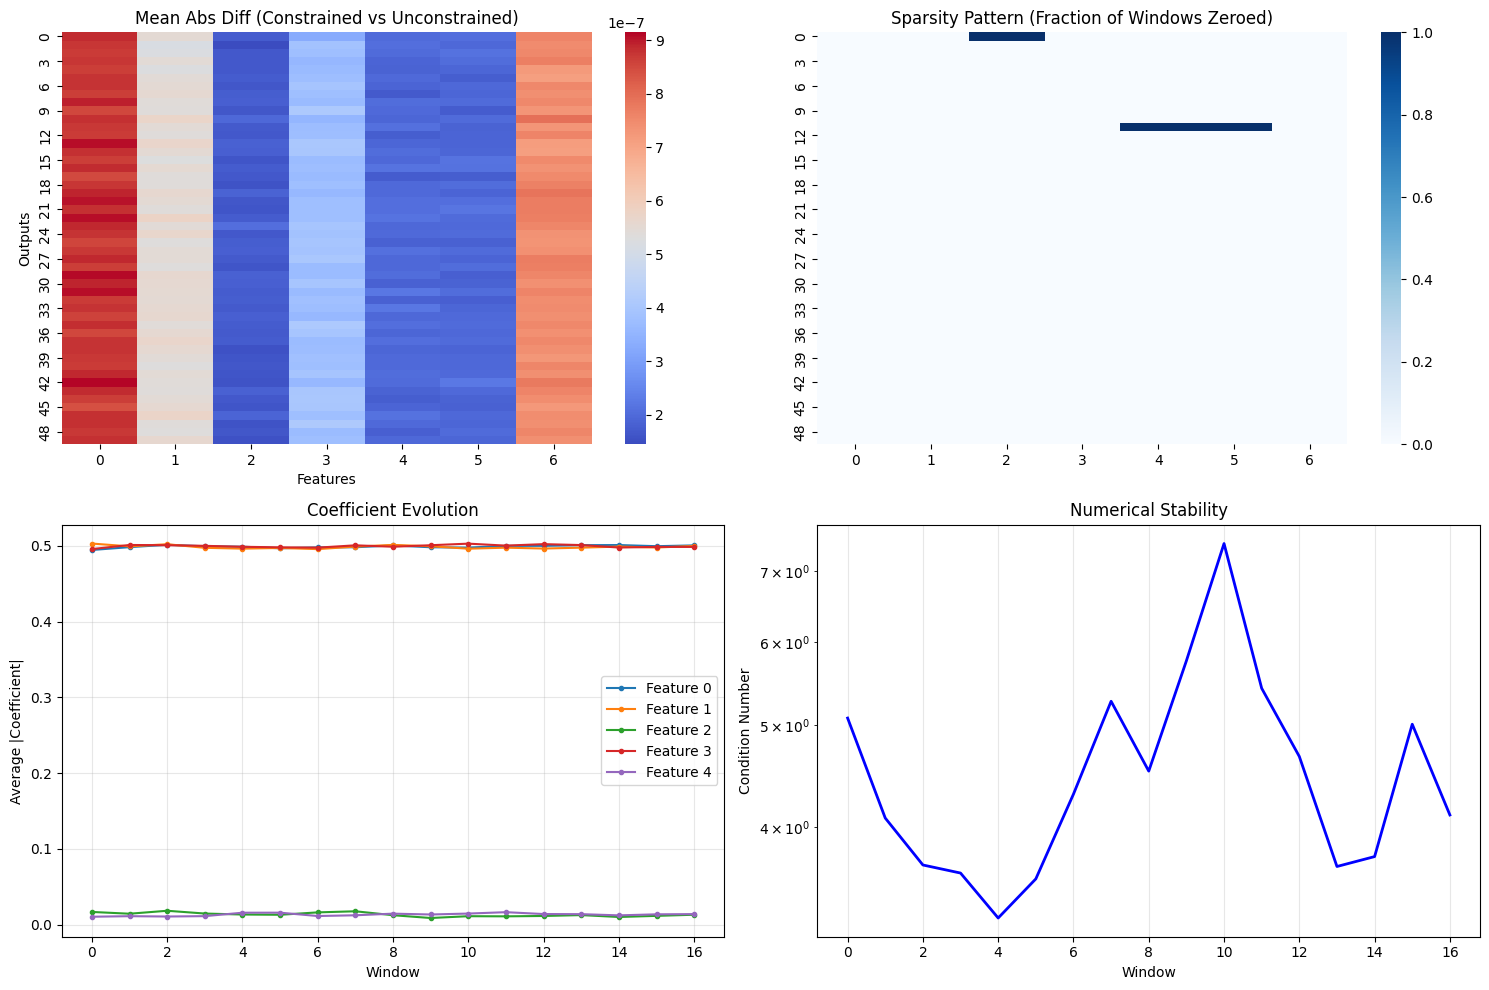


Testing KKT method for exact zero constraints...
KKT method - Max violation: 0.00e+00
KKT method - Coefficients exactly zero: 51

Testing fast penalty-based constraints...


TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function penalized_solve_with_targets at /tmp/ipython-input-3253188826.py:117 for jit. This concrete value was not available in Python because it depends on the value of the argument use_cholesky.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [104]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

# Basic OLS kernel
@jax.jit
def ols_kernel(X_win, Y_win):
    XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
    XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
    reg = 1e-6 * jnp.eye(XtX.shape[0])
    return jnp.linalg.solve(XtX + reg, XtY)

# Cholesky version for numerical stability
@jax.jit
def ols_kernel_cholesky(X_win, Y_win):
    XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
    XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)

    # Adaptive regularization
    reg = 1e-6 * jnp.maximum(1.0, jnp.trace(XtX) / XtX.shape[0])
    XtX_reg = XtX + reg * jnp.eye(XtX.shape[0])

    L = jnp.linalg.cholesky(XtX_reg)
    z = jax.scipy.linalg.solve_triangular(L, XtY, lower=True)
    return jax.scipy.linalg.solve_triangular(L.T, z, lower=False)

# Simple adaptive threshold functions
@jax.jit
def compute_mad_threshold(W, k=2.0):
    """MAD-based adaptive threshold"""
    W_flat = jnp.abs(W).ravel()
    median = jnp.median(W_flat)
    mad = jnp.median(jnp.abs(W_flat - median))
    # 1.4826 converts MAD to std for normal distribution
    return k * mad * 1.4826

@jax.jit
def compute_std_threshold(W, k=2.0):
    """Standard deviation based threshold"""
    return k * jnp.std(jnp.abs(W))

# KKT solver for exact constraints
def make_kkt_solver(max_frozen):
    """Create a KKT solver with fixed max_frozen parameter"""
    @jax.jit
    def kkt_solve_single(XtX, XtY_col, freeze_mask_col):
        d = XtX.shape[0]
        num_frozen = jnp.sum(freeze_mask_col)

        def solve_with_constraints():
            # Build constraint matrix A
            A = jnp.zeros((max_frozen, d), dtype=XtX.dtype)

            # Use cumulative sum to assign frozen features to rows
            frozen_cumsum = jnp.cumsum(freeze_mask_col) - 1
            row_indices = jnp.where(freeze_mask_col, frozen_cumsum, max_frozen)

            # Scatter 1s into A
            for i in range(d):
                row_idx = row_indices[i]
                A = A.at[row_idx, i].set(
                    jnp.where(row_idx < max_frozen, freeze_mask_col[i].astype(A.dtype), 0.0)
                )

            b = jnp.zeros(max_frozen, dtype=XtY_col.dtype)

            # Build KKT system
            KKT_mat = jnp.block([
                [XtX, A.T],
                [A, jnp.zeros((max_frozen, max_frozen), dtype=XtX.dtype)]
            ])
            rhs = jnp.concatenate([XtY_col, b])

            # Regularize unused constraint rows
            constraint_mask = jnp.arange(max_frozen) >= num_frozen
            diag_mask = jnp.concatenate([jnp.zeros(d, dtype=bool), constraint_mask])
            KKT_regularized = KKT_mat + jnp.diag(diag_mask.astype(KKT_mat.dtype) * 1e10)

            sol_full = jnp.linalg.solve(KKT_regularized, rhs)
            sol = sol_full[:d]

            # Explicitly zero out frozen weights
            return jnp.where(freeze_mask_col, 0.0, sol)

        def solve_without_constraints():
            return jnp.linalg.solve(XtX, XtY_col)

        return jax.lax.cond(
            num_frozen > 0,
            solve_with_constraints,
            solve_without_constraints
        )

    return kkt_solve_single

# Vectorized equality constraints using penalty method
def create_equality_penalty_matrix(n_features, n_targets, constraints, penalty_strength=1e6):
    """
    Create penalty matrices for equality constraints.
    Returns (penalty_matrix, target_values) where:
    - penalty_matrix[i,j] = penalty_strength if coefficient (i,j) is constrained
    - target_values[i,j] = target value for coefficient (i,j)
    """
    penalty_matrix = jnp.zeros((n_features, n_targets))
    target_values = jnp.zeros((n_features, n_targets))

    for constraint in constraints:
        if constraint[0] == 'value':
            # Push coefficient to specific value
            i, j, value = constraint[1][0]
            penalty_matrix = penalty_matrix.at[i, j].set(penalty_strength)
            target_values = target_values.at[i, j].set(value)

    return penalty_matrix, target_values

@jax.jit
def penalized_solve_with_targets(X_win, Y_win, penalty_diag, penalty_matrix, target_values, use_cholesky=True):
    """
    Solve with penalties that push coefficients to target values.
    This is much faster than KKT for soft constraints.
    """
    XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
    XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)

    # Add diagonal penalties (for zeros)
    XtX_pen = XtX + jnp.diag(penalty_diag)

    # Add penalty terms for equality constraints
    # This modifies the normal equations to push coefficients to targets
    n_features = XtX.shape[0]
    for k in range(n_features):
        # Add penalty_matrix[k,:] to diagonal for feature k
        XtX_pen = XtX_pen.at[k, k].add(jnp.sum(penalty_matrix[k, :]))
        # Modify RHS to push toward target values
        XtY = XtY.at[k, :].add(penalty_matrix[k, :] * target_values[k, :])

    if use_cholesky:
        L = jnp.linalg.cholesky(XtX_pen)
        z = jax.scipy.linalg.solve_triangular(L, XtY, lower=True)
        return jax.scipy.linalg.solve_triangular(L.T, z, lower=False)
    else:
        return jnp.linalg.solve(XtX_pen, XtY)

# Enhanced factory function
def make_sliding_regression_enhanced(
    t1, t2,
    epsilon=1e-3,
    big_penalty=1e6,
    forced_group_mask=None,
    n_countries=None,
    n_tenors=None,
    method="penalty",  # "penalty" or "kkt"
    max_frozen=None,
    use_cholesky=True,
    use_adaptive_threshold=True,
    threshold_k=2.0,
    compute_diagnostics=False,
    equality_constraints=None,  # For penalty-based equality constraints
    constraint_penalty=1e6      # Strength of equality constraints
):
    # Pre-compute max_frozen if using KKT
    if method == "kkt" and max_frozen is None:
        if forced_group_mask is not None:
            max_frozen = int(jnp.max(jnp.sum(forced_group_mask, axis=-1)))
        else:
            max_frozen = 7  # Default to n_features or specify

    # Pre-compute constraint penalty matrices if using penalty method with constraints
    constraint_penalty_matrix = None
    constraint_targets = None
    if method == "penalty" and equality_constraints is not None:
        # This happens outside JIT - only once!
        constraint_penalty_matrix, constraint_targets = create_equality_penalty_matrix(
            7, n_countries * n_tenors if n_countries and n_tenors else 50,
            equality_constraints, constraint_penalty
        )

    def _sliding(X, Y):
        n_samples, d_features = X.shape
        n_targets = Y.shape[1]
        n_windows = (n_samples - t1) // t2 + 1
        starts = jnp.arange(n_windows) * t2

        # Extract windows efficiently
        X_wins = jax.vmap(lambda s: jax.lax.dynamic_slice(X, (s, 0), (t1, d_features)))(starts)
        Y_wins = jax.vmap(lambda s: jax.lax.dynamic_slice(Y, (s, 0), (t1, n_targets)))(starts)

        # Compute OLS solutions
        solver = ols_kernel_cholesky if use_cholesky else ols_kernel
        W_ols = jax.vmap(solver)(X_wins, Y_wins)

        # Compute mask
        if forced_group_mask is not None:
            # Use provided mask
            mask = jnp.broadcast_to(
                forced_group_mask[None, :, :, :],
                (n_windows, *forced_group_mask.shape)
            )
            mask = mask.transpose(0, 3, 1, 2).reshape(n_windows, d_features, n_targets)
        else:
            # Adaptive thresholding
            if use_adaptive_threshold:
                # Compute threshold for each window
                thresholds = jax.vmap(lambda W: compute_mad_threshold(W, threshold_k))(W_ols)
                mask = jnp.abs(W_ols) < thresholds[:, None, None]
            else:
                mask = jnp.abs(W_ols) < epsilon

        # Apply constraints based on method
        if method == "penalty":
            # Penalty method - now handles both zeros and equality constraints
            penalty = jnp.where(mask, big_penalty, 0.0)

            if constraint_penalty_matrix is not None:
                # Use the enhanced solver that handles target values
                W_final = jax.vmap(
                    lambda X_win, Y_win, p: penalized_solve_with_targets(
                        X_win, Y_win, p, constraint_penalty_matrix, constraint_targets, use_cholesky
                    )
                )(X_wins, Y_wins, penalty)
            else:
                # Standard penalty method
                @jax.jit
                def penalized_solve(X_win, Y_win, p):
                    XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
                    XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)
                    XtX_pen = XtX + jnp.diag(p)

                    if use_cholesky:
                        L = jnp.linalg.cholesky(XtX_pen)
                        z = jax.scipy.linalg.solve_triangular(L, XtY, lower=True)
                        return jax.scipy.linalg.solve_triangular(L.T, z, lower=False)
                    else:
                        return jnp.linalg.solve(XtX_pen, XtY)

                W_final = jax.vmap(penalized_solve)(X_wins, Y_wins, penalty)

        else:  # method == "kkt"
            # KKT method for exact constraints
            kkt_solver = make_kkt_solver(max_frozen)

            def kkt_solve_window(X_win, Y_win, freeze_mask):
                XtX = jnp.einsum("ni,nj->ij", X_win, X_win)
                XtY = jnp.einsum("ni,nj->ij", X_win, Y_win)

                # Apply KKT solver to each output
                return jax.vmap(
                    lambda Y_col, fm_col: kkt_solver(XtX, Y_col, fm_col),
                    in_axes=(1, 1),
                    out_axes=1
                )(XtY, freeze_mask)

            W_final = jax.vmap(kkt_solve_window)(X_wins, Y_wins, mask)

        # Compute diagnostics
        diagnostics = {}
        if compute_diagnostics:
            # Basic statistics
            diagnostics['mean'] = jnp.mean(W_final, axis=0)
            diagnostics['std'] = jnp.std(W_final, axis=0)
            diagnostics['cv'] = diagnostics['std'] / (jnp.abs(diagnostics['mean']) + 1e-8)

            # Constraint violations
            violations = jnp.where(mask, jnp.abs(W_final), 0.0)
            diagnostics['max_violation'] = jnp.max(violations)
            diagnostics['num_violations'] = jnp.sum(violations > 1e-6)

            # Condition numbers
            diagnostics['condition_numbers'] = jax.vmap(
                lambda X: jnp.linalg.cond(X.T @ X)
            )(X_wins)

        return W_ols, W_final, mask, diagnostics

    return _sliding

# Warm start implementation using scan
def make_sliding_regression_warmstart(
    t1, t2,
    momentum=0.9,
    use_cholesky=True,
    **kwargs
):
    """Sliding regression with warm start"""
    def _sliding_warmstart(X, Y):
        n_samples, d_features = X.shape
        n_targets = Y.shape[1]
        n_windows = (n_samples - t1) // t2 + 1

        solver = ols_kernel_cholesky if use_cholesky else ols_kernel

        def scan_fn(W_prev, idx):
            start = idx * t2
            X_win = jax.lax.dynamic_slice(X, (start, 0), (t1, d_features))
            Y_win = jax.lax.dynamic_slice(Y, (start, 0), (t1, n_targets))

            W_new = solver(X_win, Y_win)
            W_combined = momentum * W_prev + (1 - momentum) * W_new

            return W_combined, W_combined

        W_init = jnp.zeros((d_features, n_targets))
        _, W_history = jax.lax.scan(scan_fn, W_init, jnp.arange(n_windows))

        return W_history

    return _sliding_warmstart

# Visualization helper
def plot_results(W_ols, W_final, mask, diagnostics=None):
    """Visualize regression results"""
    n_windows = W_ols.shape[0]

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Coefficient heatmap
    ax = axes[0, 0]
    diff = jnp.abs(W_final - W_ols).mean(axis=0)
    sns.heatmap(diff.T, cmap='coolwarm', ax=ax, cbar=True)
    ax.set_title('Mean Abs Diff (Constrained vs Unconstrained)')
    ax.set_xlabel('Features')
    ax.set_ylabel('Outputs')

    # 2. Sparsity pattern
    ax = axes[0, 1]
    sparsity = mask.mean(axis=0)
    sns.heatmap(sparsity.T, cmap='Blues', ax=ax, cbar=True, vmin=0, vmax=1)
    ax.set_title('Sparsity Pattern (Fraction of Windows Zeroed)')

    # 3. Coefficient evolution
    ax = axes[1, 0]
    W_avg = jnp.mean(jnp.abs(W_final), axis=2)
    for i in range(min(5, W_avg.shape[1])):
        ax.plot(W_avg[:, i], label=f'Feature {i}', marker='o', markersize=3)
    ax.set_xlabel('Window')
    ax.set_ylabel('Average |Coefficient|')
    ax.set_title('Coefficient Evolution')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 4. Diagnostics
    ax = axes[1, 1]
    if diagnostics and 'condition_numbers' in diagnostics:
        ax.plot(diagnostics['condition_numbers'], 'b-', linewidth=2)
        ax.set_xlabel('Window')
        ax.set_ylabel('Condition Number')
        ax.set_title('Numerical Stability')
        ax.set_yscale('log')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

# Example usage
if __name__ == "__main__":
    # Generate test data
    key = jax.random.PRNGKey(42)
    n_samples, n_features = 200, 7
    n_countries, n_tenors = 5, 10
    n_targets = n_countries * n_tenors

    # Generate data
    X = jax.random.normal(key, (n_samples, n_features))
    true_coef = jnp.ones((n_features, n_targets)) * 0.5
    # Make some coefficients zero
    true_coef = true_coef.at[2, :].set(0.0)
    true_coef = true_coef.at[4:6, :].set(0.0)

    noise = 0.1 * jax.random.normal(key, (n_samples, n_targets))
    Y = X @ true_coef + noise

    # Create forced mask
    forced_mask = jnp.zeros((n_countries, n_tenors, n_features), dtype=bool)
    forced_mask = forced_mask.at[0, 0, 2].set(True)
    forced_mask = forced_mask.at[1, 1, 4:6].set(True)

    # Run enhanced sliding regression
    print("Running enhanced sliding regression...")
    t1, t2 = 40, 10

    regression_fn = make_sliding_regression_enhanced(
        t1, t2,
        forced_group_mask=forced_mask,
        n_countries=n_countries,
        n_tenors=n_tenors,
        use_cholesky=True,
        use_adaptive_threshold=True,
        threshold_k=2.0,
        compute_diagnostics=True
    )

    W_ols, W_final, mask, diagnostics = regression_fn(X, Y)

    # Print summary
    print(f"\nResults:")
    print(f"Number of windows: {W_ols.shape[0]}")
    print(f"Sparsity: {100 * mask.mean():.1f}% of coefficients zeroed")
    if diagnostics:
        print(f"Max condition number: {jnp.max(diagnostics['condition_numbers']):.2e}")
        print(f"Number of constraint violations: {diagnostics['num_violations']}")
        print(f"Max violation magnitude: {diagnostics['max_violation']:.2e}")

    # Visualize
    plot_results(W_ols, W_final, mask, diagnostics)
    plt.show()

    # Example 1: Test KKT method for exact zeros
    print("\n" + "="*50)
    print("Testing KKT method for exact zero constraints...")

    kkt_fn = make_sliding_regression_enhanced(
        t1, t2,
        forced_group_mask=forced_mask,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method="kkt",  # Use KKT for exact zeros
        max_frozen=3,   # Maximum 3 zeros per output
        compute_diagnostics=True
    )

    W_ols_kkt, W_final_kkt, mask_kkt, diagnostics_kkt = kkt_fn(X, Y)

    # Check that constraints are exactly satisfied
    violations = jnp.where(mask_kkt, jnp.abs(W_final_kkt), 0.0)
    print(f"KKT method - Max violation: {jnp.max(violations):.2e}")
    print(f"KKT method - Coefficients exactly zero: {jnp.sum(jnp.abs(W_final_kkt) < 1e-10)}")

    # Example 2: Fast penalty-based constraints (GPU-friendly)
    print("\n" + "="*50)
    print("Testing fast penalty-based constraints...")

    # Define constraints using penalty method (much faster than KKT)
    # Format: (type, indices, optional_params)
    fast_constraints = [
        ('value', [(0, 0, 0.5)]),           # Push W[0,0] to 0.5
        ('value', [(1, 0, 0.5)]),           # Push W[1,0] to 0.5 (makes them equal)
        ('value', [(3, 1, 1.0)]),           # Push W[3,1] to 1.0
        ('value', [(4, 1, -1.0)]),          # Push W[4,1] to -1.0 (opposite of W[3,1])
        ('value', [(5, 2, 0.0)]),           # Push W[5,2] to 0.0
    ]

    penalty_constraint_fn = make_sliding_regression_enhanced(
        t1, t2,
        n_countries=n_countries,
        n_tenors=n_tenors,
        method="penalty",
        equality_constraints=fast_constraints,
        constraint_penalty=1e8,  # Strong penalty for tight constraints
        compute_diagnostics=True
    )

    W_ols_pc, W_final_pc, mask_pc, diagnostics_pc = penalty_constraint_fn(X, Y)

    # Verify constraints (they should be approximately satisfied)
    print(f"\nPenalty-based constraint verification:")
    print(f"W[0,0] ≈ 0.5: {jnp.mean(W_final_pc[:, 0, 0]):.4f}")
    print(f"W[1,0] ≈ 0.5: {jnp.mean(W_final_pc[:, 1, 0]):.4f}")
    print(f"W[3,1] ≈ 1.0: {jnp.mean(W_final_pc[:, 3, 1]):.4f}")
    print(f"W[4,1] ≈ -1.0: {jnp.mean(W_final_pc[:, 4, 1]):.4f}")
    print(f"W[5,2] ≈ 0.0: {jnp.mean(W_final_pc[:, 5, 2]):.4f}")

    # Example 3: Performance comparison
    print("\n" + "="*50)
    print("Performance comparison: Penalty vs KKT...")

    import time

    # Time penalty method
    start = time.time()
    for _ in range(5):
        _ = regression_fn(X, Y)
    penalty_time = (time.time() - start) / 5

    # Time KKT method
    start = time.time()
    for _ in range(5):
        _ = kkt_fn(X, Y)
    kkt_time = (time.time() - start) / 5

    print(f"Penalty method: {penalty_time:.4f} seconds")
    print(f"KKT method: {kkt_time:.4f} seconds")
    print(f"Speedup: {kkt_time/penalty_time:.2f}x")

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # 1. Compare methods
    ax = axes[0, 0]
    diff = jnp.abs(W_final - W_final_kkt).mean(axis=0)
    sns.heatmap(diff.T, cmap='coolwarm', ax=ax)
    ax.set_title('Penalty vs KKT: Mean Abs Difference')

    # 2. Penalty-based constraints
    ax = axes[0, 1]
    W_pc_avg = W_final_pc.mean(axis=0)
    im = ax.imshow(W_pc_avg.T[:10, :], aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1)
    ax.set_xlabel('Features')
    ax.set_ylabel('First 10 Outputs')
    ax.set_title('Penalty-Constrained Coefficients')
    plt.colorbar(im, ax=ax)

    # 3. Constraint satisfaction over windows
    ax = axes[1, 0]
    ax.plot(W_final_pc[:, 0, 0], label='W[0,0] (target=0.5)', alpha=0.7)
    ax.plot(W_final_pc[:, 1, 0], label='W[1,0] (target=0.5)', alpha=0.7)
    ax.axhline(y=0.5, color='k', linestyle='--', alpha=0.5)
    ax.set_xlabel('Window')
    ax.set_ylabel('Coefficient Value')
    ax.set_title('Constraint Tracking Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 4. Sparsity comparison
    ax = axes[1, 1]
    sparsity_penalty = (jnp.abs(W_final) < 1e-3).mean()
    sparsity_kkt = (jnp.abs(W_final_kkt) < 1e-10).mean()
    sparsity_pc = (jnp.abs(W_final_pc) < 1e-3).mean()

    ax.bar(['Penalty\n(soft zeros)', 'KKT\n(exact zeros)', 'Penalty+Constraints'],
           [sparsity_penalty, sparsity_kkt, sparsity_pc],
           color=['blue', 'green', 'orange'])
    ax.set_ylabel('Fraction of Zero Coefficients')
    ax.set_title('Sparsity Comparison')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Running sliding window regression...
Average R²: -0.0056
Sparsity: 65.0% of coefficients zeroed


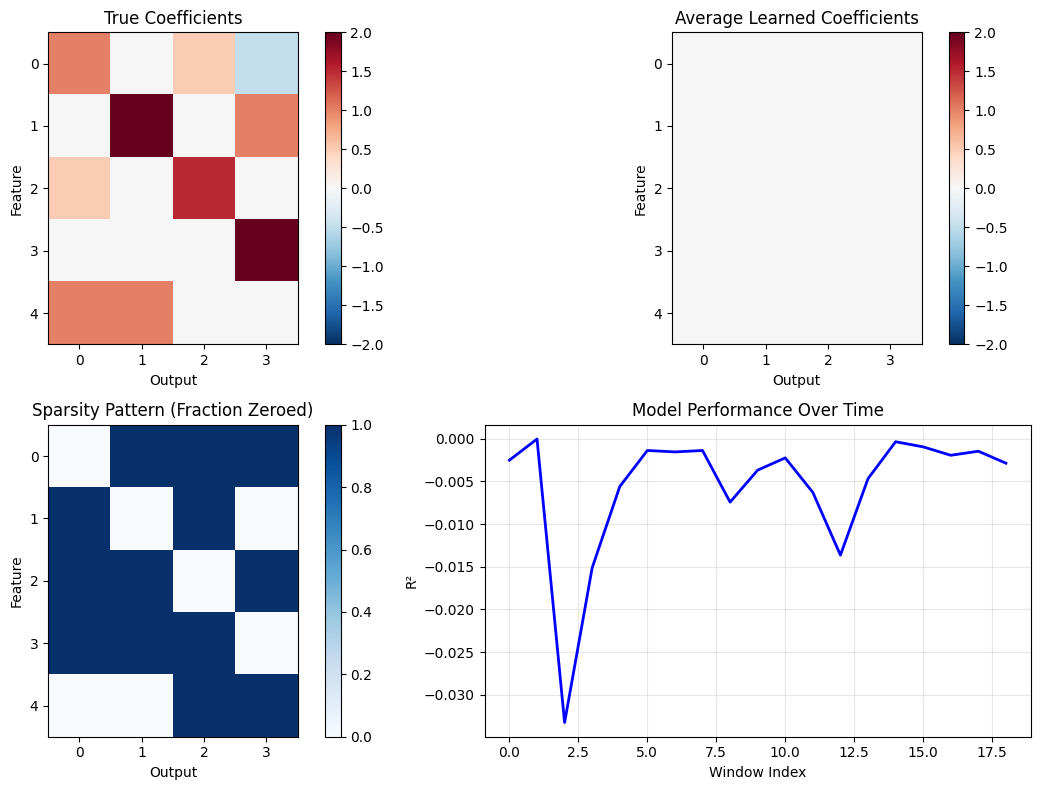


Testing with fixed mask (forcing true zeros)...
Max coefficient value at true zero locations: 0.00e+00
MSE between recovered and true coefficients: 0.7500


In [105]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Core OLS solver with proper einsum notation
@jax.jit
def ols_with_penalty(X_win, Y_win, mask=None, penalty_strength=1e8):
    """
    Solve OLS with optional penalty on masked coefficients.

    Args:
        X_win: (window_size, n_features)
        Y_win: (window_size, n_outputs)
        mask: (n_features, n_outputs) - True where coefficients should be zero
        penalty_strength: Penalty for masked coefficients
    """
    # Correct einsum: wf,wg->fg for XtX
    XtX = jnp.einsum('wf,wg->fg', X_win, X_win)
    # Correct einsum: wf,wo->fo for XtY
    XtY = jnp.einsum('wf,wo->fo', X_win, Y_win)

    # Add regularization for stability
    XtX = XtX + 1e-6 * jnp.eye(XtX.shape[0])

    if mask is not None:
        # Feature-wise penalty: penalize if ANY output is masked
        feature_penalty = jnp.any(mask, axis=1).astype(jnp.float32) * penalty_strength
        XtX = XtX + jnp.diag(feature_penalty)

    # Solve
    W = jnp.linalg.solve(XtX, XtY)

    # Zero out masked coefficients
    if mask is not None:
        W = jnp.where(mask, 0.0, W)

    return W

# Sliding window implementation
def sliding_window_regression(X, Y, window_size, stride, mask_fn=None, penalty_strength=1e8):
    """
    Perform sliding window regression with optional constraints.

    Args:
        X: (n_samples, n_features)
        Y: (n_samples, n_outputs)
        window_size: Size of sliding window
        stride: Step size between windows
        mask_fn: Optional function that returns mask for each window
        penalty_strength: Penalty for masked coefficients
    """
    n_samples, n_features = X.shape
    n_outputs = Y.shape[1]
    n_windows = (n_samples - window_size) // stride + 1

    # Extract windows efficiently
    def get_window(start_idx):
        X_win = jax.lax.dynamic_slice(X, (start_idx, 0), (window_size, n_features))
        Y_win = jax.lax.dynamic_slice(Y, (start_idx, 0), (window_size, n_outputs))
        return X_win, Y_win

    # Compute starting indices
    start_indices = jnp.arange(n_windows) * stride

    # Get all windows
    X_wins, Y_wins = jax.vmap(get_window)(start_indices)

    # Apply mask function if provided
    if mask_fn is not None:
        masks = jax.vmap(mask_fn)(X_wins, Y_wins)
    else:
        masks = jnp.zeros((n_windows, n_features, n_outputs), dtype=bool)

    # Solve for each window
    W_all = jax.vmap(ols_with_penalty, in_axes=(0, 0, 0, None))(
        X_wins, Y_wins, masks, penalty_strength
    )

    return W_all, masks

# Adaptive thresholding
@jax.jit
def adaptive_threshold_mask(X_win, Y_win, threshold_factor=2.0):
    """Create mask based on initial OLS solution magnitude."""
    # Solve unconstrained OLS first
    W_ols = ols_with_penalty(X_win, Y_win, mask=None)

    # Compute threshold using MAD
    W_flat = jnp.abs(W_ols).ravel()
    median = jnp.median(W_flat)
    mad = jnp.median(jnp.abs(W_flat - median))
    threshold = threshold_factor * mad * 1.4826  # MAD to std conversion

    # Create mask
    return jnp.abs(W_ols) < threshold

# Example with proper R² calculation
def compute_r_squared(Y_true, Y_pred):
    """Compute R² score."""
    ss_res = jnp.sum((Y_true - Y_pred) ** 2)
    ss_tot = jnp.sum((Y_true - jnp.mean(Y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

# Demo
if __name__ == "__main__":
    # Generate synthetic data
    key = jax.random.PRNGKey(42)
    n_samples, n_features, n_outputs = 1000, 5, 4

    # True coefficients with some zeros
    true_W = jnp.array([
        [1.0, 0.0, 0.5, -0.5],
        [0.0, 2.0, 0.0, 1.0],
        [0.5, 0.0, 1.5, 0.0],
        [0.0, 0.0, 0.0, 2.0],
        [1.0, 1.0, 0.0, 0.0]
    ])

    X = jax.random.normal(key, (n_samples, n_features))
    noise = 0.1 * jax.random.normal(key, (n_samples, n_outputs))
    Y = X @ true_W + noise

    # Run sliding window regression with adaptive thresholding
    window_size = 100
    stride = 50

    print("Running sliding window regression...")
    W_adaptive, masks = sliding_window_regression(
        X, Y, window_size, stride,
        mask_fn=adaptive_threshold_mask,
        penalty_strength=1e8
    )

    # Evaluate performance
    n_windows = W_adaptive.shape[0]
    r2_scores = []

    for i in range(n_windows):
        start = i * stride
        end = start + window_size
        Y_pred = X[start:end] @ W_adaptive[i]
        r2 = compute_r_squared(Y[start:end], Y_pred)
        r2_scores.append(r2)

    r2_scores = jnp.array(r2_scores)

    print(f"Average R²: {jnp.mean(r2_scores):.4f}")
    print(f"Sparsity: {100 * jnp.mean(masks):.1f}% of coefficients zeroed")

    # Visualize results
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # True coefficients
    ax = axes[0, 0]
    im = ax.imshow(true_W, cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title('True Coefficients')
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')
    plt.colorbar(im, ax=ax)

    # Average learned coefficients
    ax = axes[0, 1]
    W_avg = jnp.mean(W_adaptive, axis=0)
    im = ax.imshow(W_avg, cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title('Average Learned Coefficients')
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')
    plt.colorbar(im, ax=ax)

    # Sparsity pattern
    ax = axes[1, 0]
    sparsity = jnp.mean(masks, axis=0)
    im = ax.imshow(sparsity, cmap='Blues', vmin=0, vmax=1)
    ax.set_title('Sparsity Pattern (Fraction Zeroed)')
    ax.set_xlabel('Output')
    ax.set_ylabel('Feature')
    plt.colorbar(im, ax=ax)

    # R² over time
    ax = axes[1, 1]
    ax.plot(r2_scores, 'b-', linewidth=2)
    ax.set_xlabel('Window Index')
    ax.set_ylabel('R²')
    ax.set_title('Model Performance Over Time')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Comparison with fixed mask
    print("\nTesting with fixed mask (forcing true zeros)...")
    fixed_mask = true_W == 0.0

    def fixed_mask_fn(X_win, Y_win):
        return fixed_mask

    W_fixed, _ = sliding_window_regression(
        X, Y, window_size, stride,
        mask_fn=fixed_mask_fn,
        penalty_strength=1e10  # Very high penalty
    )

    # Check how well we recovered the true zeros
    W_fixed_avg = jnp.mean(W_fixed, axis=0)
    max_violation = jnp.max(jnp.abs(W_fixed_avg[fixed_mask]))
    print(f"Max coefficient value at true zero locations: {max_violation:.2e}")

    # Recovery error
    recovery_error = jnp.mean((W_fixed_avg - true_W) ** 2)
    print(f"MSE between recovered and true coefficients: {recovery_error:.4f}")